In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/ANESTESIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=130.7, y0=121.5, x1=190.1, y1=133.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 307
Page 1, Q1, A: Yellow percentage: 0.0%


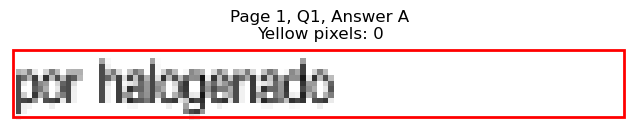

Page 1, Q1 - B: Detected box: x0=123.9, y0=133.5, x1=182.5, y1=145.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 312
Page 1, Q1, B: Yellow percentage: 0.0%


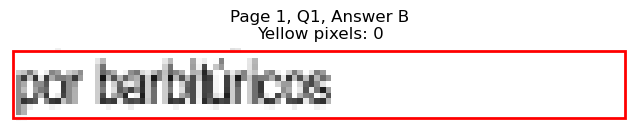

Page 1, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=133.0, y1=157.6
Page 1, Q1, C: Yellow pixels: 895
Page 1, Q1, C: Total non-white pixels: 1456
Page 1, Q1, C: Yellow percentage: 61.5%


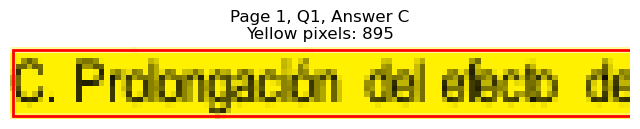

Page 1, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=379.3, y1=133.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 483
Page 1, Q1, D: Yellow percentage: 0.0%


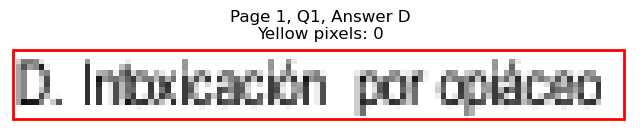

Page 1, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=374.8, y1=145.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 414
Page 1, Q1, E: Yellow percentage: 0.0%


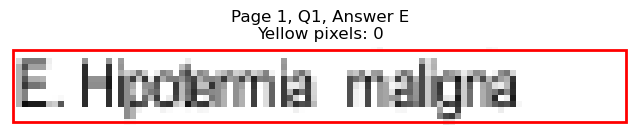


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=112.0, y1=193.6
Page 1, Q2, A: Yellow pixels: 204
Page 1, Q2, A: Total non-white pixels: 365
Page 1, Q2, A: Yellow percentage: 55.9%


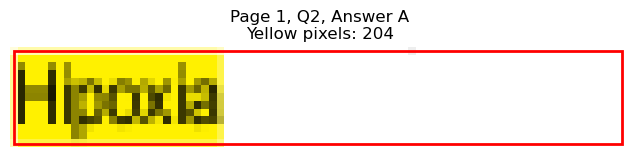

Page 1, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=127.7, y1=205.6
Page 1, Q2, B: Yellow pixels: 27
Page 1, Q2, B: Total non-white pixels: 321
Page 1, Q2, B: Yellow percentage: 8.4%


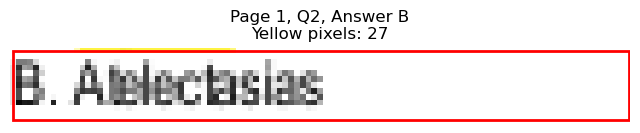

Page 1, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=146.5, y1=217.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 342
Page 1, Q2, C: Yellow percentage: 0.0%


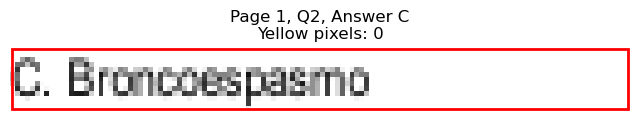

Page 1, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=400.3, y1=193.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 369
Page 1, Q2, D: Yellow percentage: 0.0%


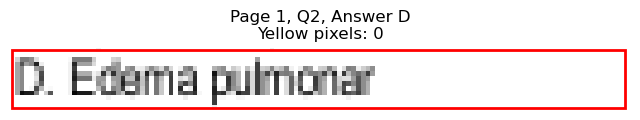

Page 1, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=380.8, y1=205.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 275
Page 1, Q2, E: Yellow percentage: 0.0%


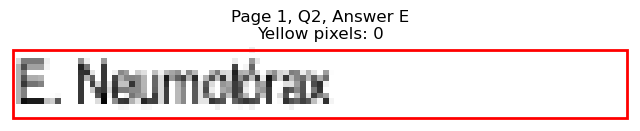


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=71.3, y0=241.6, x1=79.7, y1=253.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 64
Page 1, Q3, A: Yellow percentage: 0.0%


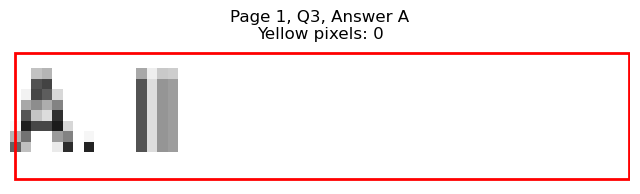

Page 1, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=86.5, y1=265.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 58
Page 1, Q3, B: Yellow percentage: 0.0%


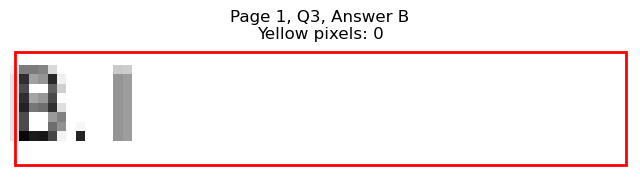

Page 1, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=89.5, y1=277.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 57
Page 1, Q3, C: Yellow percentage: 0.0%


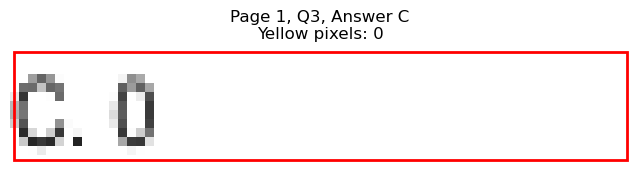

Page 1, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=343.3, y1=253.7
Page 1, Q3, D: Yellow pixels: 150
Page 1, Q3, D: Total non-white pixels: 249
Page 1, Q3, D: Yellow percentage: 60.2%


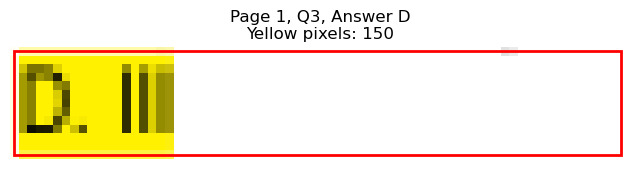

Page 1, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=343.3, y1=265.7
Page 1, Q3, E: Yellow pixels: 18
Page 1, Q3, E: Total non-white pixels: 99
Page 1, Q3, E: Yellow percentage: 18.2%


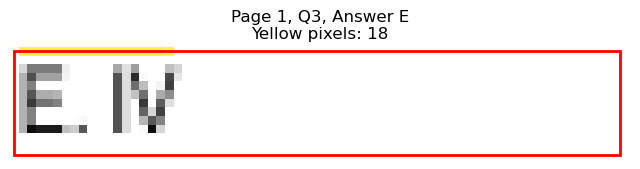


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=115.0, y1=326.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 160
Page 1, Q4, A: Yellow percentage: 0.0%


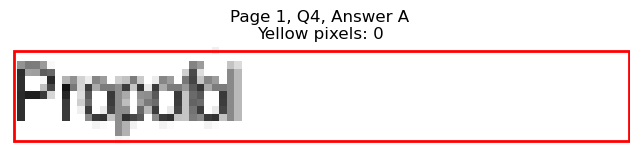

Page 1, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=125.5, y1=338.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 275
Page 1, Q4, B: Yellow percentage: 0.0%


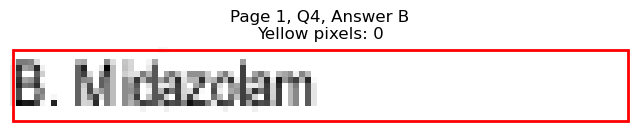

Page 1, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=117.3, y1=350.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 217
Page 1, Q4, C: Yellow percentage: 0.0%


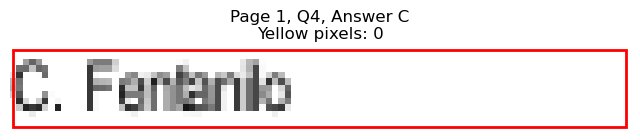

Page 1, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=394.4, y1=326.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 355
Page 1, Q4, D: Yellow percentage: 0.0%


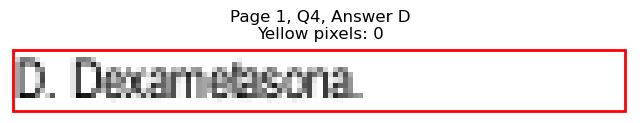

Page 1, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=370.4, y1=338.5
Page 1, Q4, E: Yellow pixels: 396
Page 1, Q4, E: Total non-white pixels: 598
Page 1, Q4, E: Yellow percentage: 66.2%


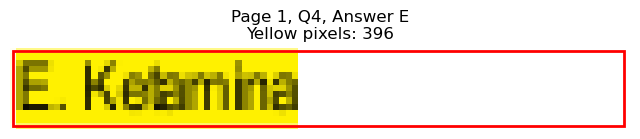


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=130.0, y1=386.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 406
Page 1, Q5, A: Yellow percentage: 0.0%


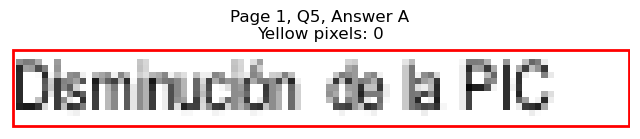

Page 1, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=163.0, y1=398.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 430
Page 1, Q5, B: Yellow percentage: 0.0%


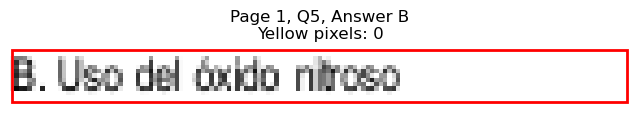

Page 1, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=146.5, y1=410.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 375
Page 1, Q5, C: Yellow percentage: 0.0%


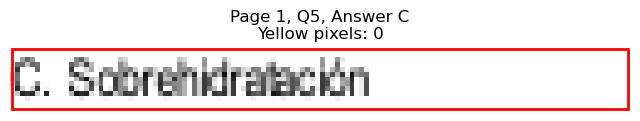

Page 1, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=430.4, y1=386.6
Page 1, Q5, D: Yellow pixels: 1304
Page 1, Q5, D: Total non-white pixels: 1898
Page 1, Q5, D: Yellow percentage: 68.7%


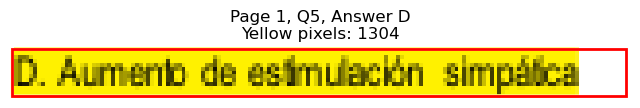

Page 1, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=391.3, y1=398.6
Page 1, Q5, E: Yellow pixels: 119
Page 1, Q5, E: Total non-white pixels: 419
Page 1, Q5, E: Yellow percentage: 28.4%


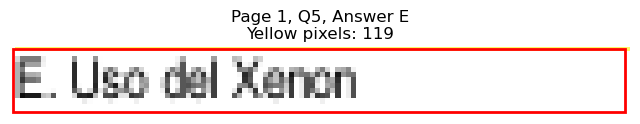


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=115.7, y0=434.6, x1=166.1, y1=446.6
Page 1, Q6, A: Yellow pixels: 379
Page 1, Q6, A: Total non-white pixels: 639
Page 1, Q6, A: Yellow percentage: 59.3%


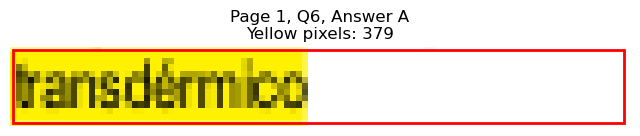

Page 1, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=126.3, y1=458.6
Page 1, Q6, B: Yellow pixels: 81
Page 1, Q6, B: Total non-white pixels: 341
Page 1, Q6, B: Yellow percentage: 23.8%


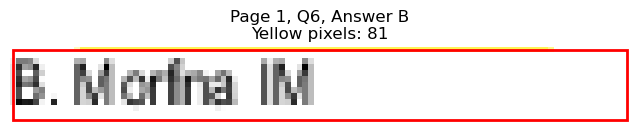

Page 1, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=158.6, y1=470.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 398
Page 1, Q6, C: Yellow percentage: 0.0%


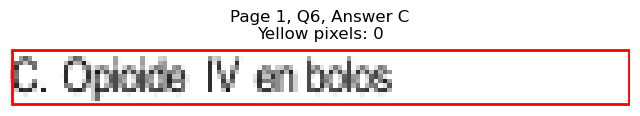

Page 1, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=410.1, y1=446.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 596
Page 1, Q6, D: Yellow percentage: 0.0%


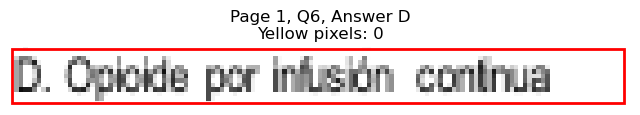

Page 1, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=407.1, y1=458.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 420
Page 1, Q6, E: Yellow percentage: 0.0%


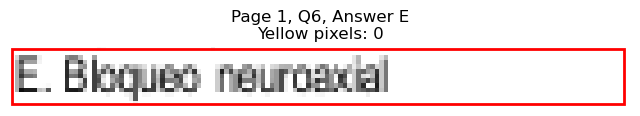


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=174.4, y1=507.4
Page 1, Q7, A: Yellow pixels: 776
Page 1, Q7, A: Total non-white pixels: 1170
Page 1, Q7, A: Yellow percentage: 66.3%


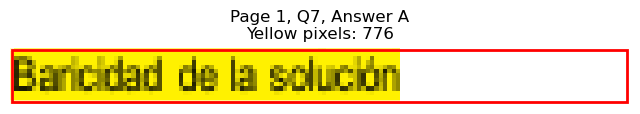

Page 1, Q7 - B: Detected box: x0=131.4, y0=507.4, x1=223.1, y1=519.4
Page 1, Q7, B: Yellow pixels: 41
Page 1, Q7, B: Total non-white pixels: 499
Page 1, Q7, B: Yellow percentage: 8.2%


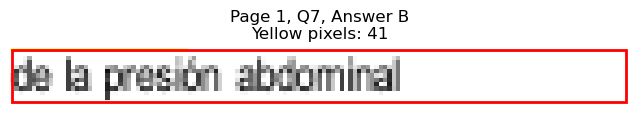

Page 1, Q7 - C: Detected box: x0=151.7, y0=519.4, x1=240.3, y1=531.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 419
Page 1, Q7, C: Yellow percentage: 0.0%


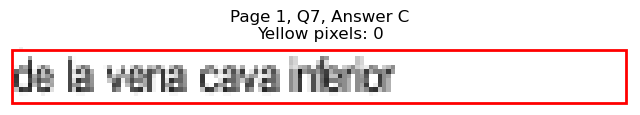

Page 1, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=427.4, y1=507.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 508
Page 1, Q7, D: Yellow percentage: 0.0%


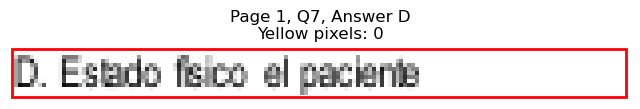

Page 1, Q7 - E: Detected box: x0=363.5, y0=507.4, x1=406.4, y1=519.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 224
Page 1, Q7, E: Yellow percentage: 0.0%


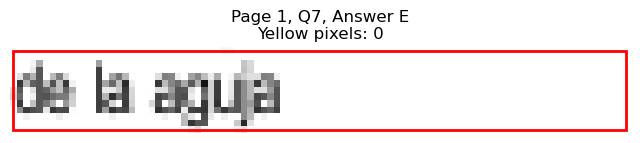


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=314.5, x1=115.0, y1=326.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 160
Page 1, Q8, A: Yellow percentage: 0.0%


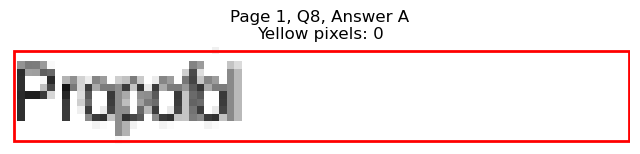

Page 1, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=117.3, y1=603.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 232
Page 1, Q8, B: Yellow percentage: 0.0%


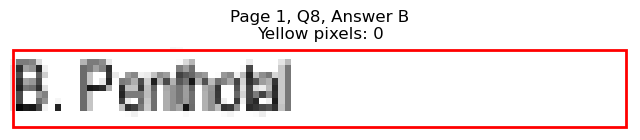

Page 1, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=120.3, y1=615.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 228
Page 1, Q8, C: Yellow percentage: 0.0%


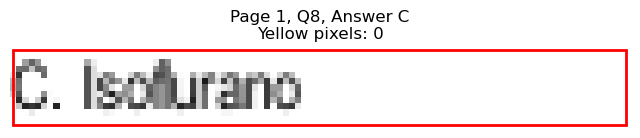

Page 1, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=371.1, y1=591.5
Page 1, Q8, D: Yellow pixels: 403
Page 1, Q8, D: Total non-white pixels: 611
Page 1, Q8, D: Yellow percentage: 66.0%


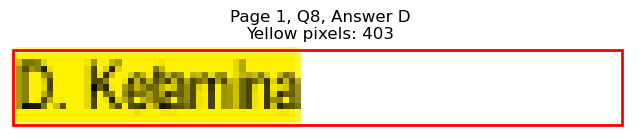

Page 1, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=371.8, y1=603.5
Page 1, Q8, E: Yellow pixels: 45
Page 1, Q8, E: Total non-white pixels: 288
Page 1, Q8, E: Yellow percentage: 15.6%


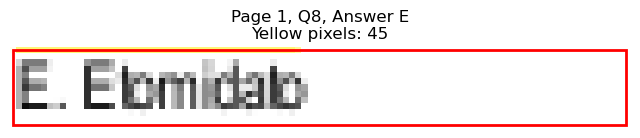


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=133.0, y1=651.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 251
Page 1, Q9, A: Yellow percentage: 0.0%


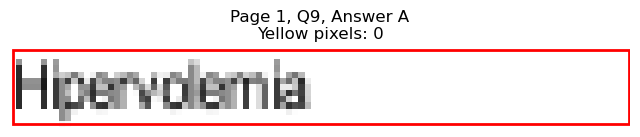

Page 1, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=139.8, y1=663.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 338
Page 1, Q9, B: Yellow percentage: 0.0%


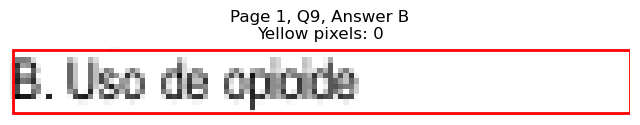

Page 1, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=166.1, y1=675.6
Page 1, Q9, C: Yellow pixels: 769
Page 1, Q9, C: Total non-white pixels: 1209
Page 1, Q9, C: Yellow percentage: 63.6%


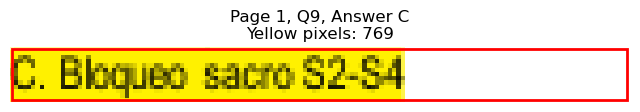

Page 1, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=400.3, y1=651.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 369
Page 1, Q9, D: Yellow percentage: 0.0%


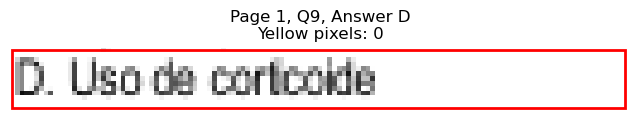

Page 1, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=385.4, y1=663.6
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 278
Page 1, Q9, E: Yellow percentage: 0.0%


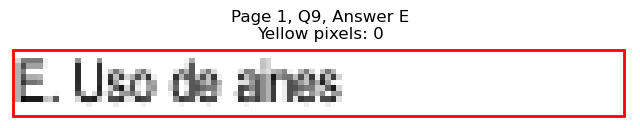


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=127.8, y1=712.3
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 243
Page 1, Q10, A: Yellow percentage: 0.0%


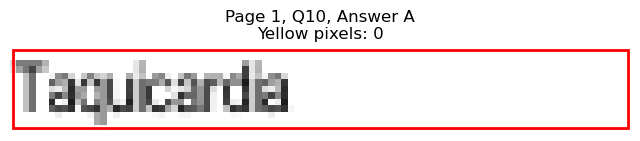

Page 1, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=134.6, y1=724.4
Page 1, Q10, B: Yellow pixels: 497
Page 1, Q10, B: Total non-white pixels: 806
Page 1, Q10, B: Yellow percentage: 61.7%


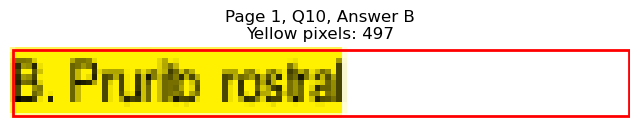

Page 1, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=127.0, y1=736.4
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 305
Page 1, Q10, C: Yellow percentage: 0.0%


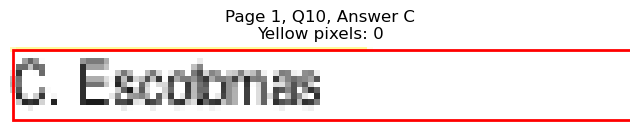

Page 1, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=357.6, y1=712.3
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 180
Page 1, Q10, D: Yellow percentage: 0.0%


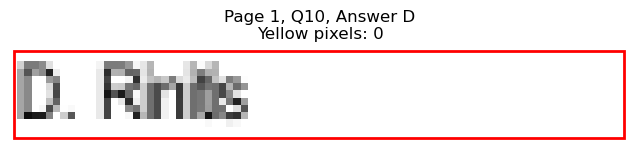

Page 1, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=374.2, y1=724.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 254
Page 1, Q10, E: Yellow percentage: 0.0%


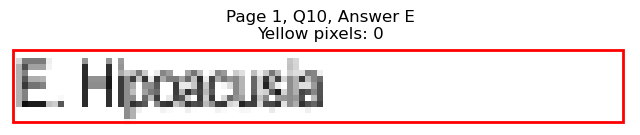


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=128.5, y1=108.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 233
Page 2, Q1, A: Yellow percentage: 0.0%


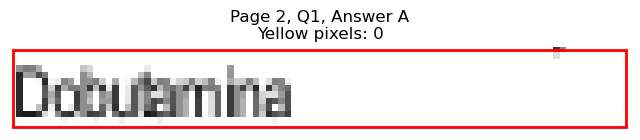

Page 2, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=114.2, y1=121.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 213
Page 2, Q1, B: Yellow percentage: 0.0%


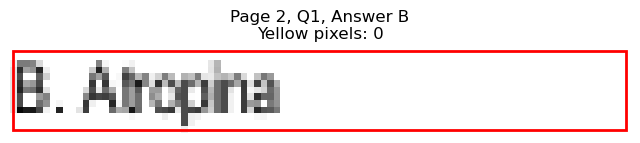

Page 2, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=118.0, y1=133.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 214
Page 2, Q1, C: Yellow percentage: 0.0%


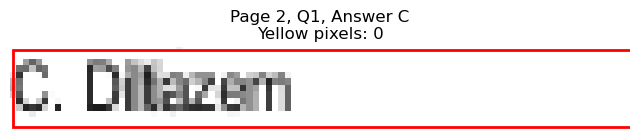

Page 2, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=375.6, y1=108.8
Page 2, Q1, D: Yellow pixels: 377
Page 2, Q1, D: Total non-white pixels: 686
Page 2, Q1, D: Yellow percentage: 55.0%


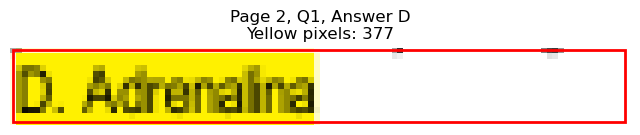

Page 2, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=370.3, y1=121.6
Page 2, Q1, E: Yellow pixels: 50
Page 2, Q1, E: Total non-white pixels: 271
Page 2, Q1, E: Yellow percentage: 18.5%


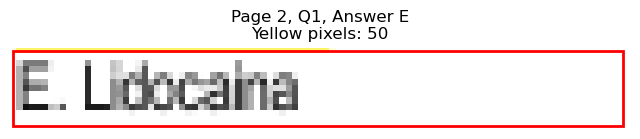


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=104.5, y1=169.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 101
Page 2, Q2, A: Yellow percentage: 0.0%


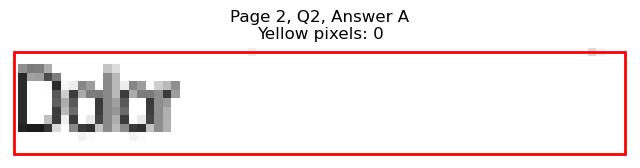

Page 2, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=107.5, y1=181.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 177
Page 2, Q2, B: Yellow percentage: 0.0%


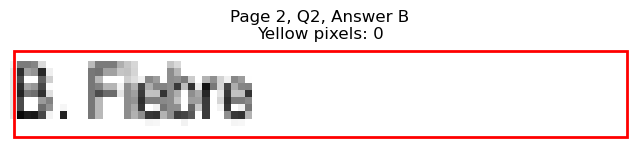

Page 2, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=172.9, y1=193.6
Page 2, Q2, C: Yellow pixels: 814
Page 2, Q2, C: Total non-white pixels: 1300
Page 2, Q2, C: Yellow percentage: 62.6%


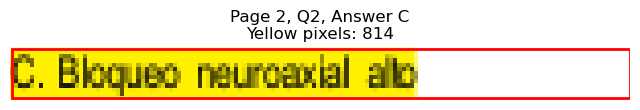

Page 2, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=371.1, y1=169.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 242
Page 2, Q2, D: Yellow percentage: 0.0%


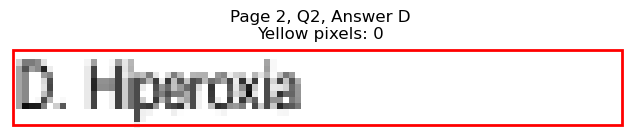

Page 2, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=415.4, y1=181.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 432
Page 2, Q2, E: Yellow percentage: 0.0%


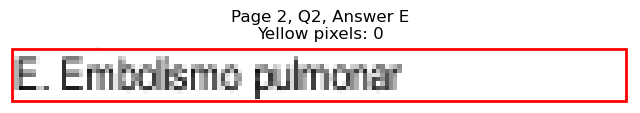


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=116.5, y1=241.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 168
Page 2, Q3, A: Yellow percentage: 0.0%


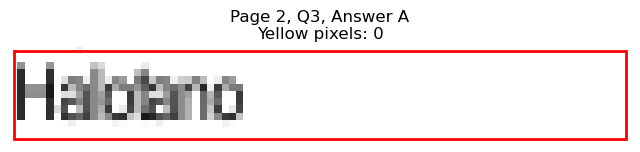

Page 2, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=123.3, y1=253.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 261
Page 2, Q3, B: Yellow percentage: 0.0%


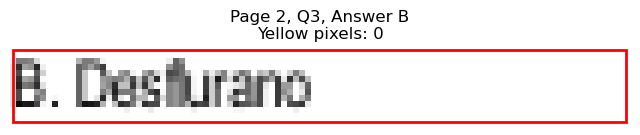

Page 2, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=121.0, y1=265.7
Page 2, Q3, C: Yellow pixels: 395
Page 2, Q3, C: Total non-white pixels: 624
Page 2, Q3, C: Yellow percentage: 63.3%


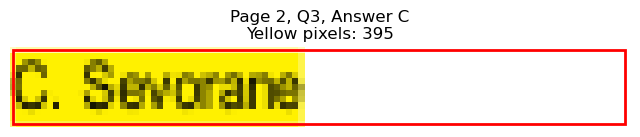

Page 2, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=371.8, y1=241.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 232
Page 2, Q3, D: Yellow percentage: 0.0%


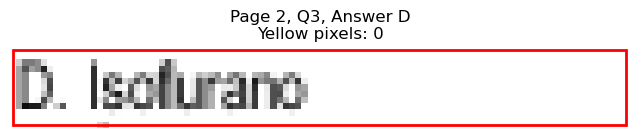

Page 2, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=384.6, y1=253.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 290
Page 2, Q3, E: Yellow percentage: 0.0%


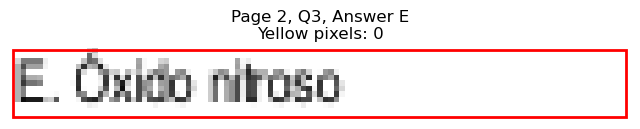


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=112.8, y1=301.8
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 170
Page 2, Q4, A: Yellow percentage: 0.0%


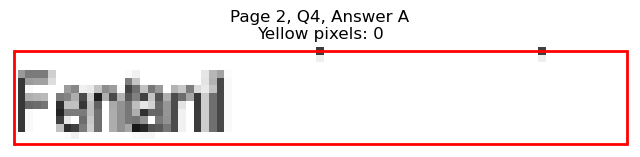

Page 2, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=133.7, y1=314.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 302
Page 2, Q4, B: Yellow percentage: 0.0%


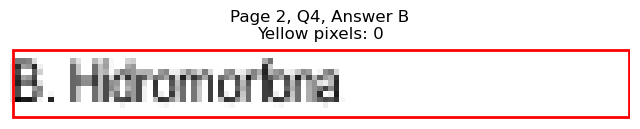

Page 2, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=121.0, y1=326.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 250
Page 2, Q4, C: Yellow percentage: 0.0%


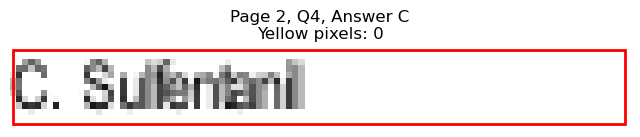

Page 2, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=398.9, y1=301.8
Page 2, Q4, D: Yellow pixels: 568
Page 2, Q4, D: Total non-white pixels: 975
Page 2, Q4, D: Yellow percentage: 58.3%


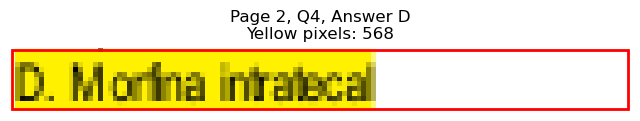

Page 2, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=375.6, y1=314.5
Page 2, Q4, E: Yellow pixels: 73
Page 2, Q4, E: Total non-white pixels: 321
Page 2, Q4, E: Yellow percentage: 22.7%


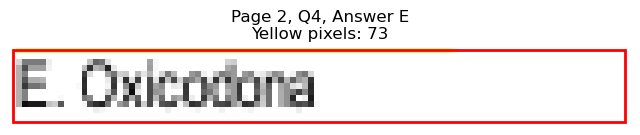


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=104.5, y1=362.5
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 105
Page 2, Q5, A: Yellow percentage: 0.0%


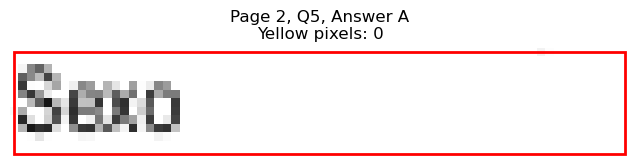

Page 2, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=101.5, y1=374.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 134
Page 2, Q5, B: Yellow percentage: 0.0%


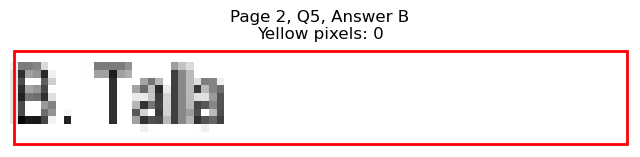

Page 2, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=136.0, y1=386.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 302
Page 2, Q5, C: Yellow percentage: 0.0%


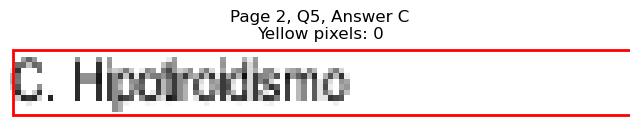

Page 2, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=390.6, y1=362.5
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 352
Page 2, Q5, D: Yellow percentage: 0.0%


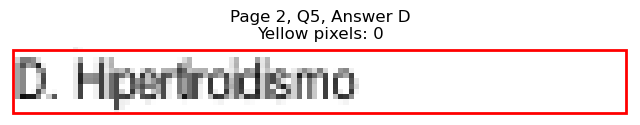

Page 2, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=383.1, y1=374.6
Page 2, Q5, E: Yellow pixels: 517
Page 2, Q5, E: Total non-white pixels: 767
Page 2, Q5, E: Yellow percentage: 67.4%


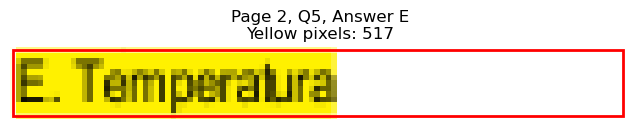


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=119.5, y1=422.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 187
Page 2, Q6, A: Yellow percentage: 0.0%


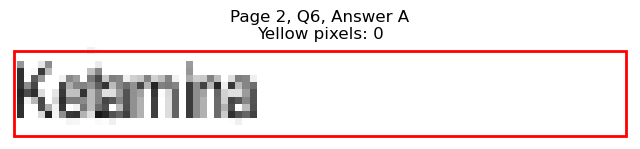

Page 2, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=125.5, y1=434.6
Page 2, Q6, B: Yellow pixels: 401
Page 2, Q6, B: Total non-white pixels: 689
Page 2, Q6, B: Yellow percentage: 58.2%


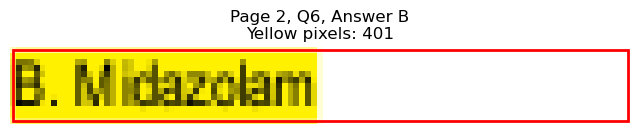

Page 2, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=118.0, y1=446.6
Page 2, Q6, C: Yellow pixels: 52
Page 2, Q6, C: Total non-white pixels: 255
Page 2, Q6, C: Yellow percentage: 20.4%


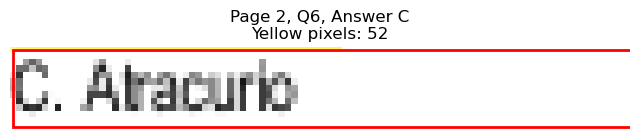

Page 2, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=366.6, y1=422.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 217
Page 2, Q6, D: Yellow percentage: 0.0%


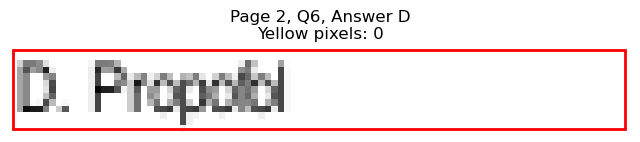

Page 2, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=384.6, y1=434.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 318
Page 2, Q6, E: Yellow percentage: 0.0%


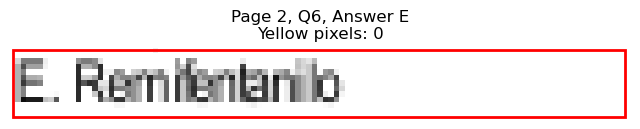


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=142.0, y1=507.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 313
Page 2, Q7, A: Yellow percentage: 0.0%


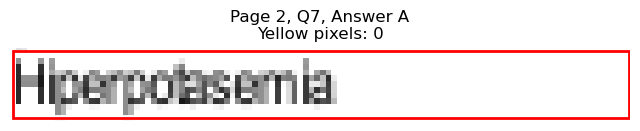

Page 2, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=132.3, y1=519.4
Page 2, Q7, B: Yellow pixels: 876
Page 2, Q7, B: Total non-white pixels: 1300
Page 2, Q7, B: Yellow percentage: 67.4%


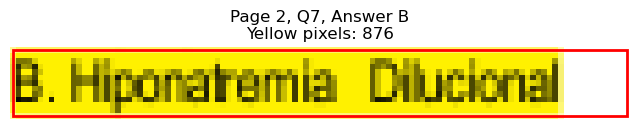

Page 2, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=136.0, y1=531.4
Page 2, Q7, C: Yellow pixels: 98
Page 2, Q7, C: Total non-white pixels: 402
Page 2, Q7, C: Yellow percentage: 24.4%


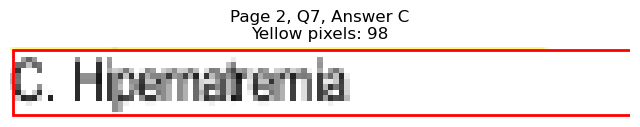

Page 2, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=411.6, y1=507.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 462
Page 2, Q7, D: Yellow percentage: 0.0%


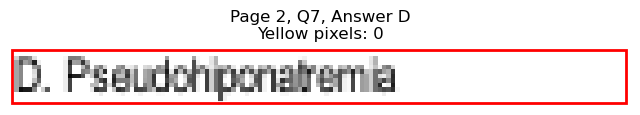

Page 2, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=397.3, y1=519.4
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 383
Page 2, Q7, E: Yellow percentage: 0.0%


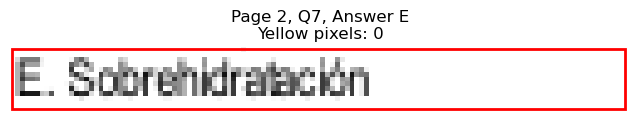


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=106.0, y1=579.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 97
Page 2, Q8, A: Yellow percentage: 0.0%


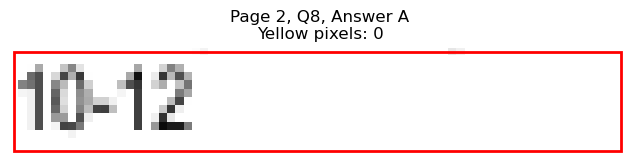

Page 2, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=105.3, y1=591.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 162
Page 2, Q8, B: Yellow percentage: 0.0%


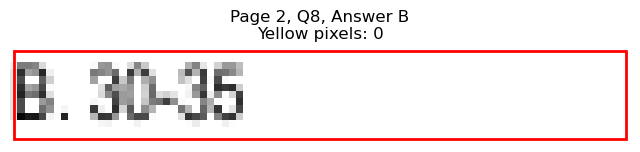

Page 2, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=109.0, y1=603.5
Page 2, Q8, C: Yellow pixels: 358
Page 2, Q8, C: Total non-white pixels: 468
Page 2, Q8, C: Yellow percentage: 76.5%


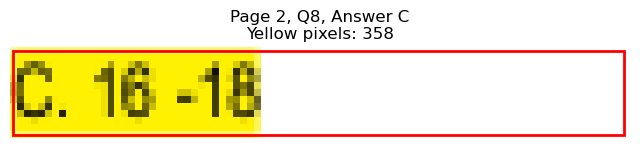

Page 2, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=357.6, y1=579.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 151
Page 2, Q8, D: Yellow percentage: 0.0%


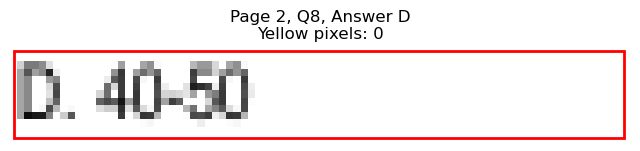

Page 2, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=351.5, y1=591.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 108
Page 2, Q8, E: Yellow percentage: 0.0%


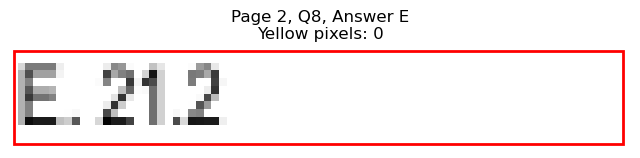


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=124.0, y1=651.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 206
Page 2, Q9, A: Yellow percentage: 0.0%


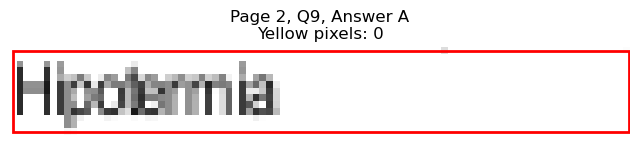

Page 2, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=145.0, y1=663.6
Page 2, Q9, B: Yellow pixels: 1071
Page 2, Q9, B: Total non-white pixels: 1560
Page 2, Q9, B: Yellow percentage: 68.7%


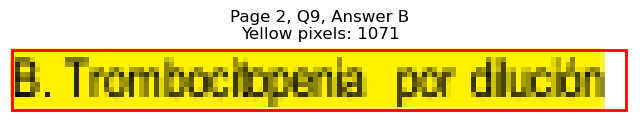

Page 2, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=131.5, y1=675.6
Page 2, Q9, C: Yellow pixels: 111
Page 2, Q9, C: Total non-white pixels: 660
Page 2, Q9, C: Yellow percentage: 16.8%


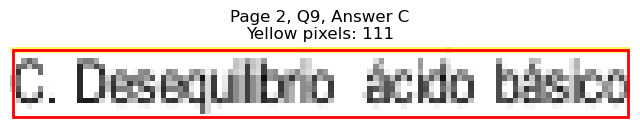

Page 2, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=393.6, y1=651.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 382
Page 2, Q9, D: Yellow percentage: 0.0%


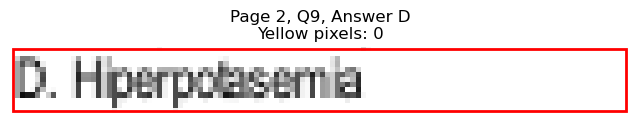

Page 2, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=368.1, y1=663.6
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 216
Page 2, Q9, E: Yellow percentage: 0.0%


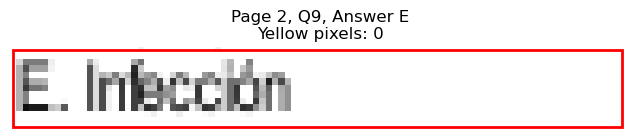


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=167.5, y1=712.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 432
Page 2, Q10, A: Yellow percentage: 0.0%


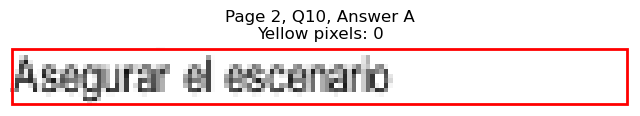

Page 2, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=112.7, y1=724.4
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 343
Page 2, Q10, B: Yellow percentage: 0.0%


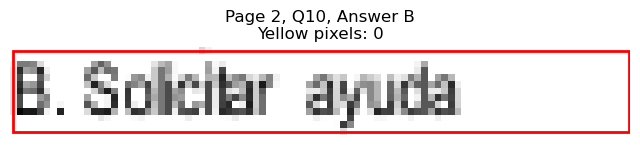

Page 2, Q10 - C: Detected box: x0=116.4, y0=724.3, x1=198.4, y1=736.4
Page 2, Q10, C: Yellow pixels: 633
Page 2, Q10, C: Total non-white pixels: 1040
Page 2, Q10, C: Yellow percentage: 60.9%


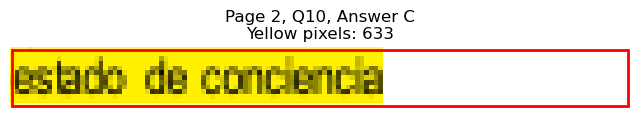

Page 2, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=494.1, y1=712.3
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 801
Page 2, Q10, D: Yellow percentage: 0.0%


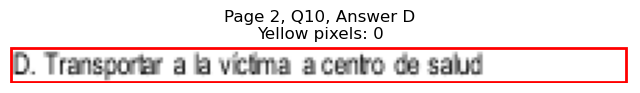

Page 2, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=407.8, y1=724.4
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 422
Page 2, Q10, E: Yellow percentage: 0.0%


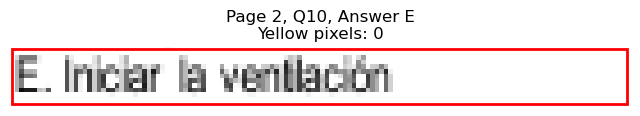


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=121.7, y1=108.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 222
Page 3, Q1, A: Yellow percentage: 0.0%


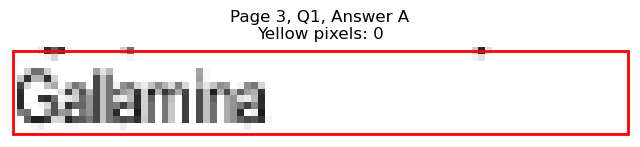

Page 3, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=121.0, y1=121.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 240
Page 3, Q1, B: Yellow percentage: 0.0%


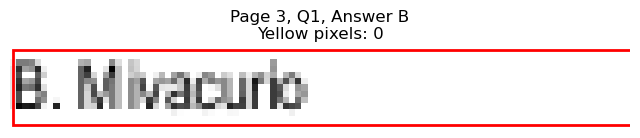

Page 3, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=127.0, y1=133.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 241
Page 3, Q1, C: Yellow percentage: 0.0%


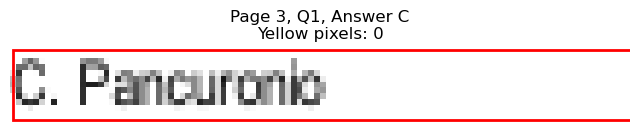

Page 3, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=386.1, y1=108.8
Page 3, Q1, D: Yellow pixels: 468
Page 3, Q1, D: Total non-white pixels: 806
Page 3, Q1, D: Yellow percentage: 58.1%


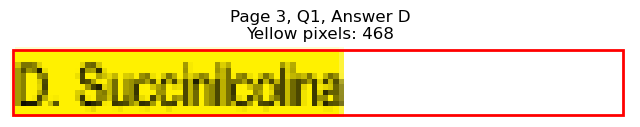

Page 3, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=373.3, y1=121.6
Page 3, Q1, E: Yellow pixels: 61
Page 3, Q1, E: Total non-white pixels: 288
Page 3, Q1, E: Yellow percentage: 21.2%


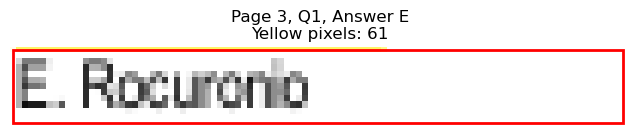


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=158.6, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 409
Page 3, Q2, A: Yellow percentage: 0.0%


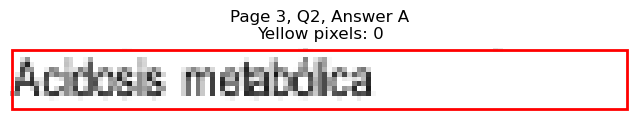

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=138.3, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 324
Page 3, Q2, B: Yellow percentage: 0.0%


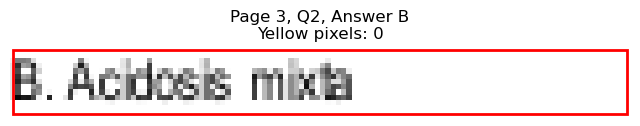

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=161.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 435
Page 3, Q2, C: Yellow percentage: 0.0%


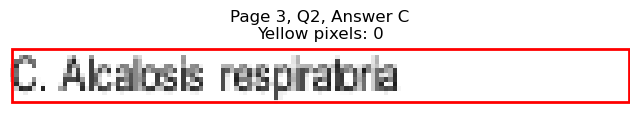

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=411.6, y1=181.6
Page 3, Q2, D: Yellow pixels: 1080
Page 3, Q2, D: Total non-white pixels: 1820
Page 3, Q2, D: Yellow percentage: 59.3%


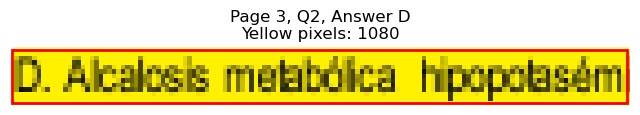

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=385.3, y1=193.6
Page 3, Q2, E: Yellow pixels: 113
Page 3, Q2, E: Total non-white pixels: 414
Page 3, Q2, E: Yellow percentage: 27.3%


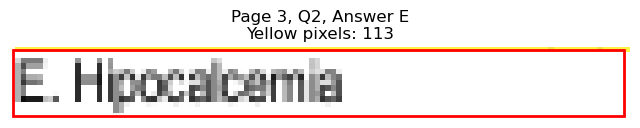


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=176.5, y1=241.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 476
Page 3, Q3, A: Yellow percentage: 0.0%


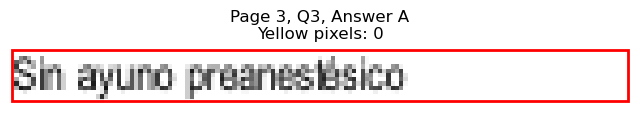

Page 3, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=142.0, y1=253.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 376
Page 3, Q3, B: Yellow percentage: 0.0%


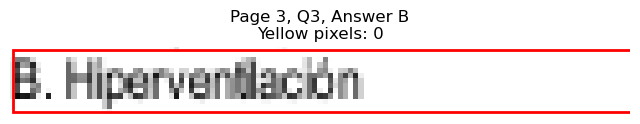

Page 3, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=161.6, y1=265.7
Page 3, Q3, C: Yellow pixels: 693
Page 3, Q3, C: Total non-white pixels: 1157
Page 3, Q3, C: Yellow percentage: 59.9%


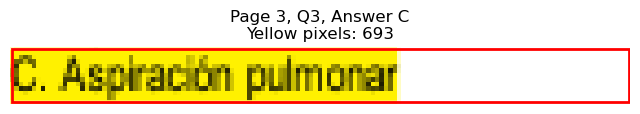

Page 3, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=405.6, y1=241.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 415
Page 3, Q3, D: Yellow percentage: 0.0%


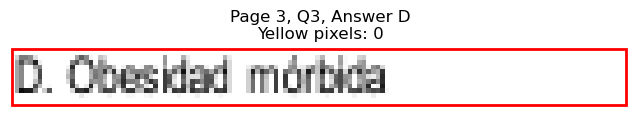

Page 3, Q3 - E: Detected box: x0=363.5, y0=241.6, x1=449.8, y1=253.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 451
Page 3, Q3, E: Yellow percentage: 0.0%


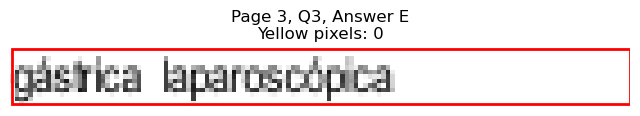


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=150.2, y1=314.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 347
Page 3, Q4, A: Yellow percentage: 0.0%


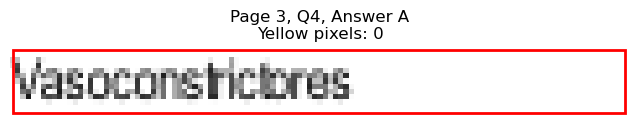

Page 3, Q4 - B: Detected box: x0=115.7, y0=314.5, x1=203.5, y1=326.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 440
Page 3, Q4, B: Yellow percentage: 0.0%


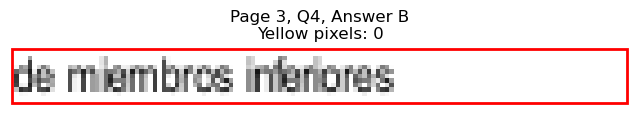

Page 3, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=141.3, y1=338.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 345
Page 3, Q4, C: Yellow percentage: 0.0%


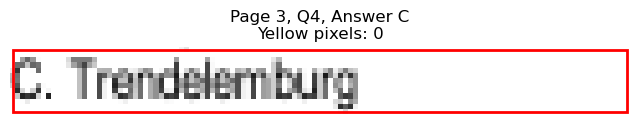

Page 3, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=366.6, y1=314.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 209
Page 3, Q4, D: Yellow percentage: 0.0%


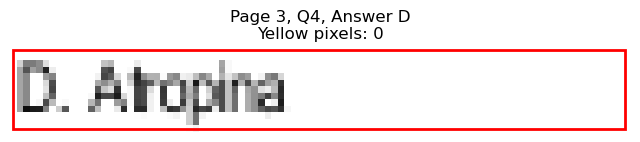

Page 3, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=417.6, y1=326.5
Page 3, Q4, E: Yellow pixels: 1369
Page 3, Q4, E: Total non-white pixels: 1898
Page 3, Q4, E: Yellow percentage: 72.1%


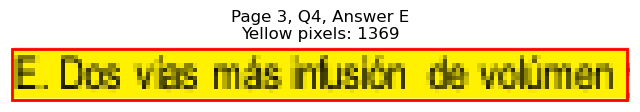


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=106.0, y1=386.6
Page 3, Q5, A: Yellow pixels: 191
Page 3, Q5, A: Total non-white pixels: 286
Page 3, Q5, A: Yellow percentage: 66.8%


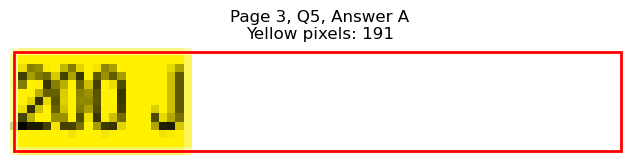

Page 3, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=105.2, y1=398.6
Page 3, Q5, B: Yellow pixels: 20
Page 3, Q5, B: Total non-white pixels: 155
Page 3, Q5, B: Yellow percentage: 12.9%


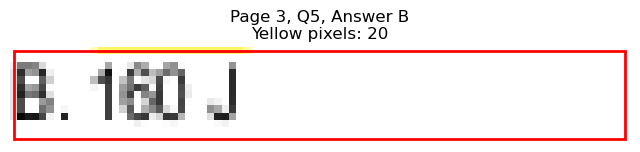

Page 3, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=106.0, y1=410.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 136
Page 3, Q5, C: Yellow percentage: 0.0%


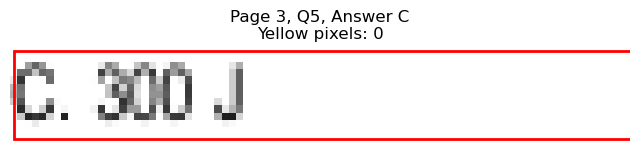

Page 3, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=357.5, y1=386.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 140
Page 3, Q5, D: Yellow percentage: 0.0%


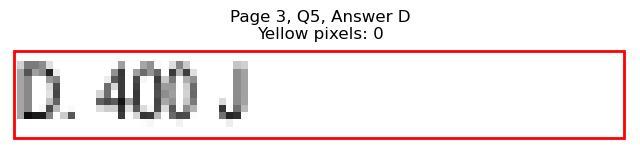

Page 3, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=356.8, y1=398.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 133
Page 3, Q5, E: Yellow percentage: 0.0%


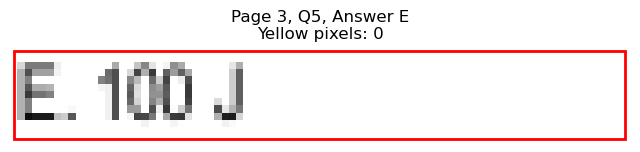


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=115.0, y1=446.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 170
Page 3, Q6, A: Yellow percentage: 0.0%


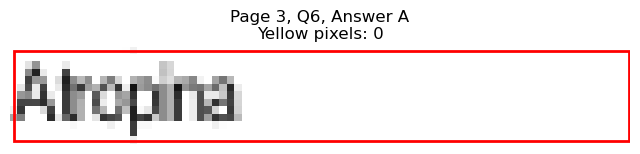

Page 3, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=123.3, y1=458.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 259
Page 3, Q6, B: Yellow percentage: 0.0%


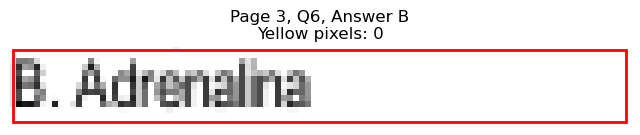

Page 3, Q6 - C: Detected box: x0=114.9, y0=458.6, x1=169.8, y1=470.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 276
Page 3, Q6, C: Yellow percentage: 0.0%


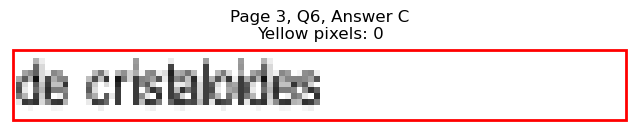

Page 3, Q6 - D: Detected box: x0=368.7, y0=434.6, x1=418.4, y1=446.6
Page 3, Q6, D: Yellow pixels: 369
Page 3, Q6, D: Total non-white pixels: 637
Page 3, Q6, D: Yellow percentage: 57.9%


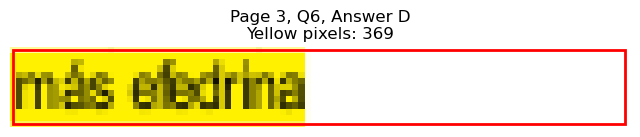

Page 3, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=392.1, y1=458.6
Page 3, Q6, E: Yellow pixels: 93
Page 3, Q6, E: Total non-white pixels: 445
Page 3, Q6, E: Yellow percentage: 20.9%


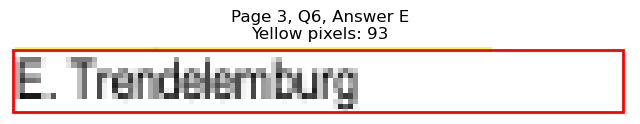


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=110.5, y1=507.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 141
Page 3, Q7, A: Yellow percentage: 0.0%


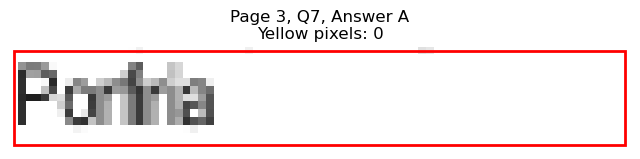

Page 3, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=145.7, y1=519.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 361
Page 3, Q7, B: Yellow percentage: 0.0%


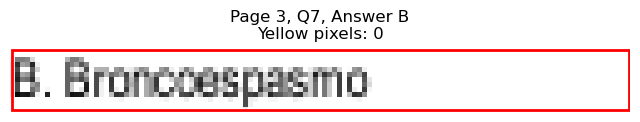

Page 3, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=129.3, y1=531.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 384
Page 3, Q7, C: Yellow percentage: 0.0%


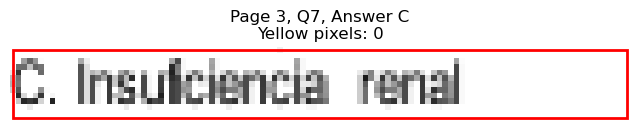

Page 3, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=377.0, y1=507.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 276
Page 3, Q7, D: Yellow percentage: 0.0%


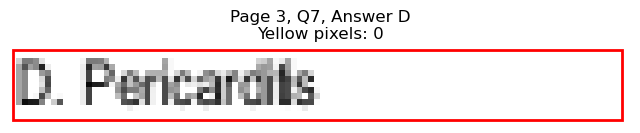

Page 3, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=379.3, y1=519.4
Page 3, Q7, E: Yellow pixels: 726
Page 3, Q7, E: Total non-white pixels: 1092
Page 3, Q7, E: Yellow percentage: 66.5%


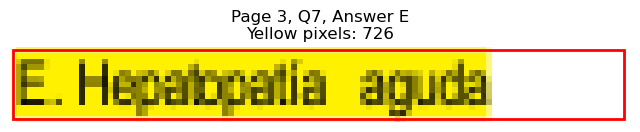


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=168.3, y1=567.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 443
Page 3, Q8, A: Yellow percentage: 0.0%


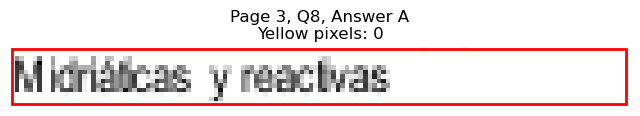

Page 3, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=179.6, y1=579.5
Page 3, Q8, B: Yellow pixels: 938
Page 3, Q8, B: Total non-white pixels: 1391
Page 3, Q8, B: Yellow percentage: 67.4%


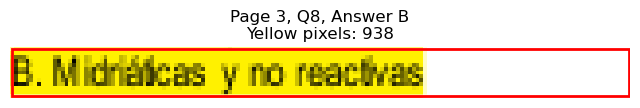

Page 3, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=115.7, y1=591.5
Page 3, Q8, C: Yellow pixels: 94
Page 3, Q8, C: Total non-white pixels: 299
Page 3, Q8, C: Yellow percentage: 31.4%


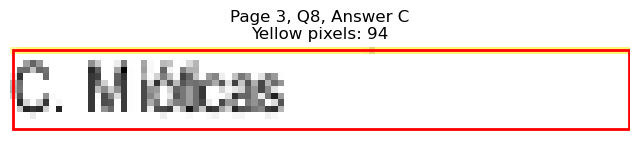

Page 3, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=374.1, y1=567.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 440
Page 3, Q8, D: Yellow percentage: 0.0%


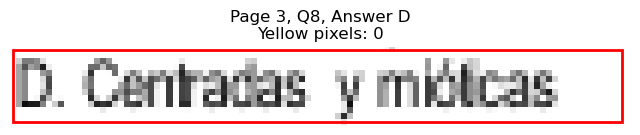

Page 3, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=368.8, y1=579.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 234
Page 3, Q8, E: Yellow percentage: 0.0%


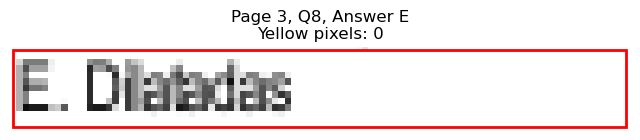


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=615.5, x1=119.5, y1=627.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 293
Page 3, Q9, A: Yellow percentage: 0.0%


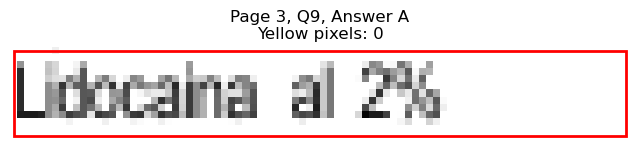

Page 3, Q9 - B: Detected box: x0=71.3, y0=627.5, x1=129.2, y1=639.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 444
Page 3, Q9, B: Yellow percentage: 0.0%


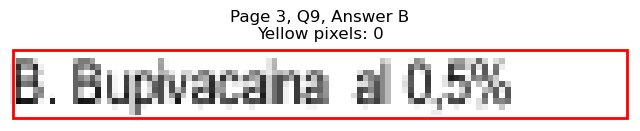

Page 3, Q9 - C: Detected box: x0=71.3, y0=639.5, x1=144.3, y1=651.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 339
Page 3, Q9, C: Yellow percentage: 0.0%


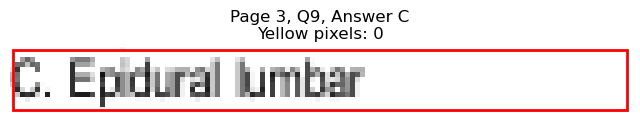

Page 3, Q9 - D: Detected box: x0=373.2, y0=615.5, x1=440.2, y1=627.5
Page 3, Q9, D: Yellow pixels: 553
Page 3, Q9, D: Total non-white pixels: 845
Page 3, Q9, D: Yellow percentage: 65.4%


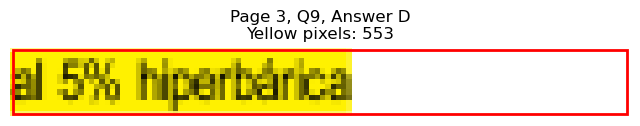

Page 3, Q9 - E: Detected box: x0=322.9, y0=627.5, x1=392.1, y1=639.6
Page 3, Q9, E: Yellow pixels: 115
Page 3, Q9, E: Total non-white pixels: 449
Page 3, Q9, E: Yellow percentage: 25.6%


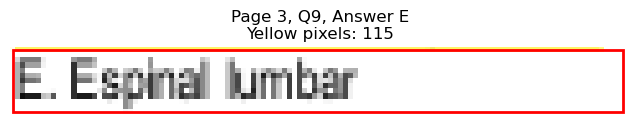


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=124.0, y1=700.3
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 223
Page 3, Q10, A: Yellow percentage: 0.0%


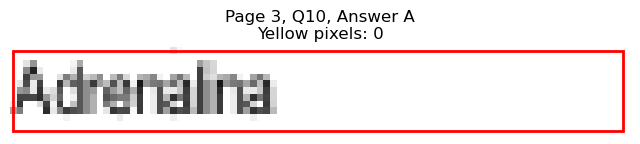

Page 3, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=130.0, y1=712.3
Page 3, Q10, B: Yellow pixels: 447
Page 3, Q10, B: Total non-white pixels: 741
Page 3, Q10, B: Yellow percentage: 60.3%


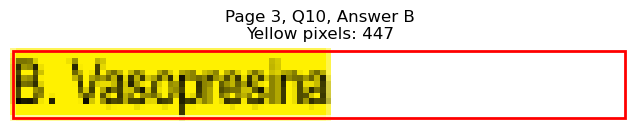

Page 3, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=121.7, y1=724.4
Page 3, Q10, C: Yellow pixels: 1
Page 3, Q10, C: Total non-white pixels: 304
Page 3, Q10, C: Yellow percentage: 0.3%


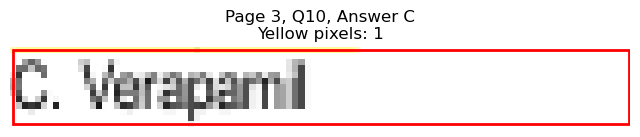

Page 3, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=369.6, y1=700.3
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 237
Page 3, Q10, D: Yellow percentage: 0.0%


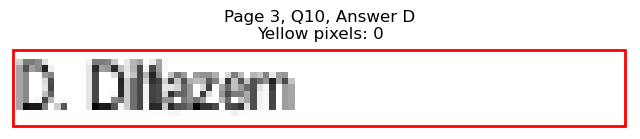

Page 3, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=380.8, y1=712.3
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 277
Page 3, Q10, E: Yellow percentage: 0.0%


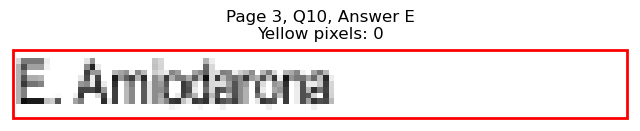


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=107.5, y1=760.4
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 127
Page 3, Q11, A: Yellow percentage: 0.0%


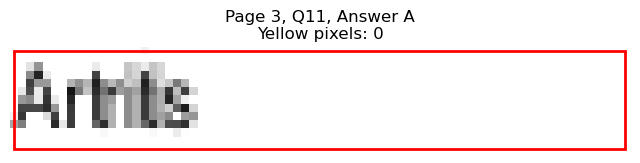

Page 3, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=124.7, y1=772.4
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 275
Page 3, Q11, B: Yellow percentage: 0.0%


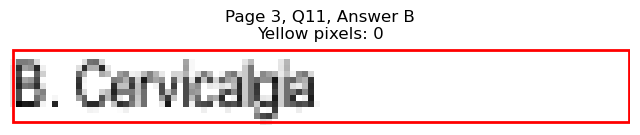

Page 3, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=116.5, y1=784.4
Page 3, Q11, C: Yellow pixels: 673
Page 3, Q11, C: Total non-white pixels: 975
Page 3, Q11, C: Yellow percentage: 69.0%


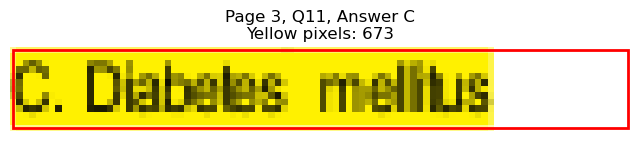

Page 3, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=377.8, y1=760.4
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 258
Page 3, Q11, D: Yellow percentage: 0.0%


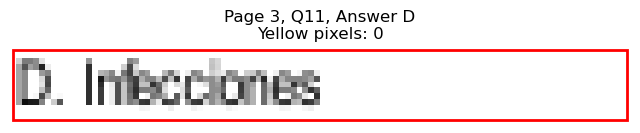

Page 3, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=417.6, y1=772.4
Page 3, Q11, E: Yellow pixels: 0
Page 3, Q11, E: Total non-white pixels: 470
Page 3, Q11, E: Yellow percentage: 0.0%


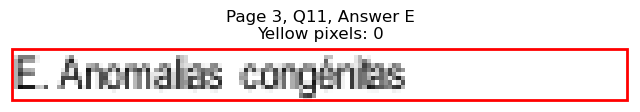


Page 3, Q11 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=71.3, y0=109.5, x1=79.7, y1=121.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 65
Page 4, Q1, A: Yellow percentage: 0.0%


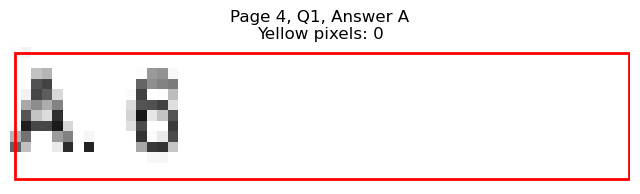

Page 4, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=88.7, y1=133.6
Page 4, Q1, B: Yellow pixels: 143
Page 4, Q1, B: Total non-white pixels: 208
Page 4, Q1, B: Yellow percentage: 68.8%


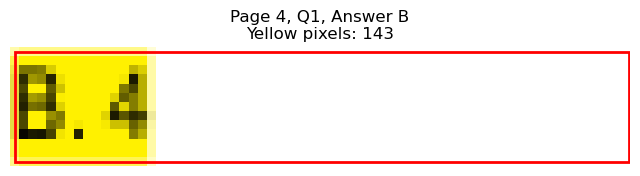

Page 4, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=89.5, y1=145.6
Page 4, Q1, C: Yellow pixels: 15
Page 4, Q1, C: Total non-white pixels: 73
Page 4, Q1, C: Yellow percentage: 20.5%


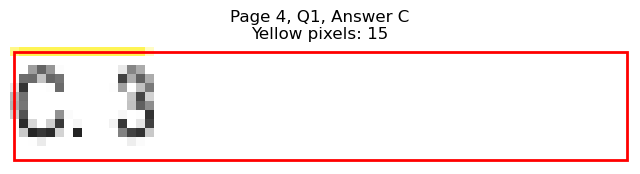

Page 4, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=341.0, y1=121.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 72
Page 4, Q1, D: Yellow percentage: 0.0%


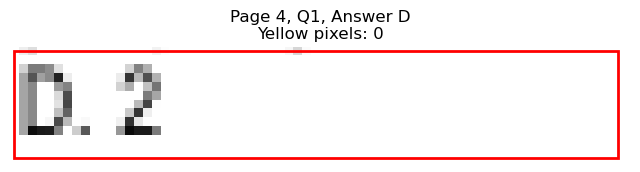

Page 4, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=340.3, y1=133.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 64
Page 4, Q1, E: Yellow percentage: 0.0%


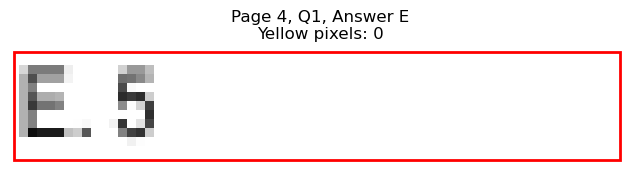


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=124.6, y0=169.6, x1=164.5, y1=181.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 197
Page 4, Q2, A: Yellow percentage: 0.0%


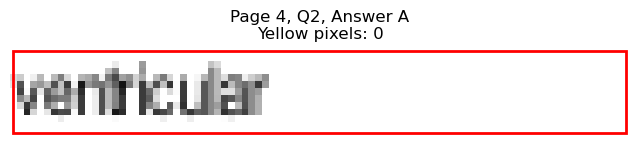

Page 4, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=148.0, y1=193.6
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 379
Page 4, Q2, B: Yellow percentage: 0.0%


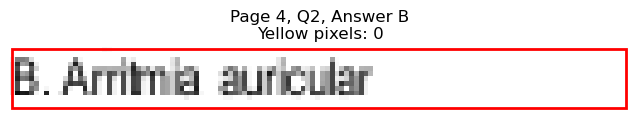

Page 4, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=173.6, y1=205.6
Page 4, Q2, C: Yellow pixels: 810
Page 4, Q2, C: Total non-white pixels: 1313
Page 4, Q2, C: Yellow percentage: 61.7%


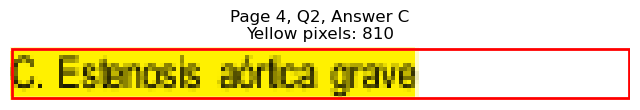

Page 4, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=434.1, y1=181.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 538
Page 4, Q2, D: Yellow percentage: 0.0%


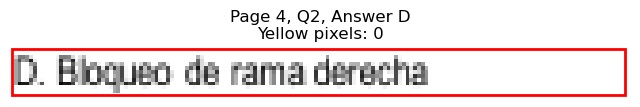

Page 4, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=426.6, y1=193.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 513
Page 4, Q2, E: Yellow percentage: 0.0%


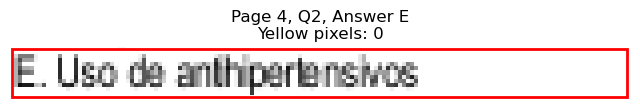


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=103.0, y1=241.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 94
Page 4, Q3, A: Yellow percentage: 0.0%


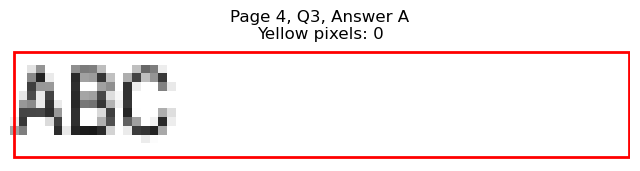

Page 4, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=102.2, y1=253.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 138
Page 4, Q3, B: Yellow percentage: 0.0%


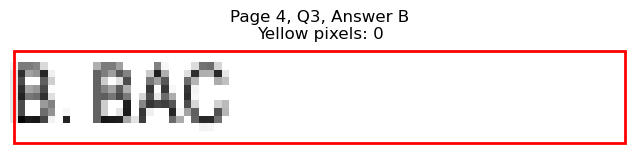

Page 4, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=102.9, y1=265.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 124
Page 4, Q3, C: Yellow percentage: 0.0%


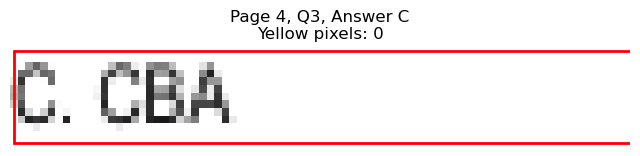

Page 4, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=360.5, y1=241.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 173
Page 4, Q3, D: Yellow percentage: 0.0%


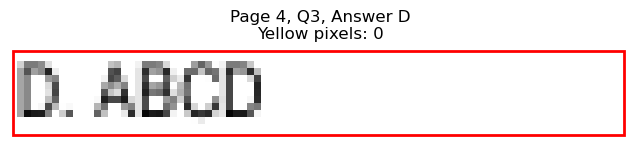

Page 4, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=353.8, y1=253.7
Page 4, Q3, E: Yellow pixels: 241
Page 4, Q3, E: Total non-white pixels: 390
Page 4, Q3, E: Yellow percentage: 61.8%


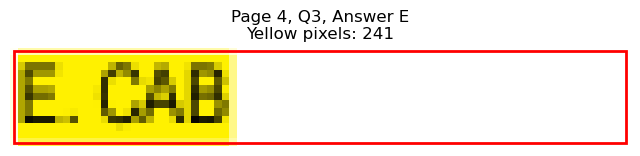


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=213.3, y1=301.8
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 650
Page 4, Q4, A: Yellow percentage: 0.0%


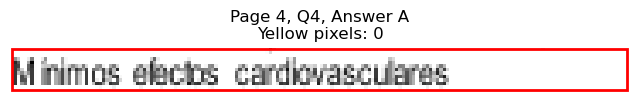

Page 4, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=205.0, y1=314.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 662
Page 4, Q4, B: Yellow percentage: 0.0%


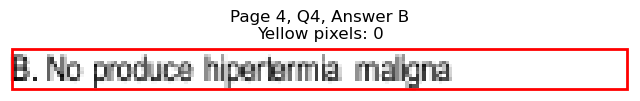

Page 4, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=178.8, y1=326.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 649
Page 4, Q4, C: Yellow percentage: 0.0%


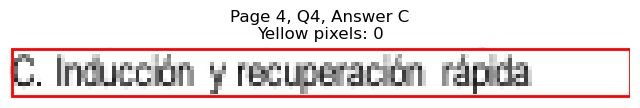

Page 4, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=431.9, y1=301.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 733
Page 4, Q4, D: Yellow percentage: 0.0%


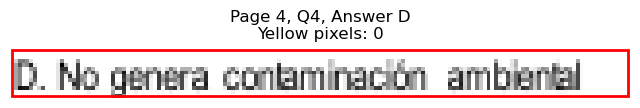

Page 4, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=387.6, y1=314.5
Page 4, Q4, E: Yellow pixels: 940
Page 4, Q4, E: Total non-white pixels: 1365
Page 4, Q4, E: Yellow percentage: 68.9%


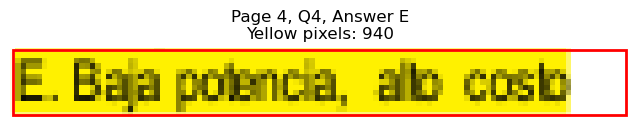


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=133.0, y1=362.5
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 255
Page 4, Q5, A: Yellow percentage: 0.0%


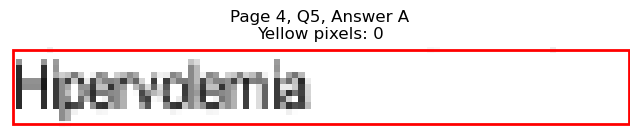

Page 4, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=129.3, y1=374.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 438
Page 4, Q5, B: Yellow percentage: 0.0%


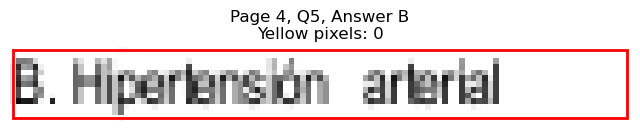

Page 4, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=166.1, y1=386.6
Page 4, Q5, C: Yellow pixels: 859
Page 4, Q5, C: Total non-white pixels: 1209
Page 4, Q5, C: Yellow percentage: 71.1%


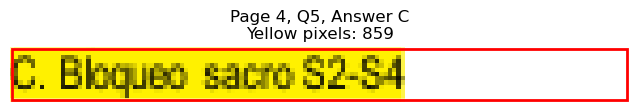

Page 4, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=398.9, y1=362.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 361
Page 4, Q5, D: Yellow percentage: 0.0%


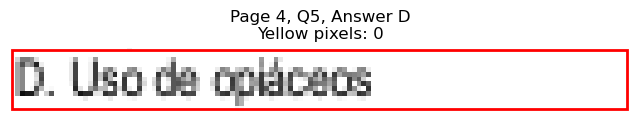

Page 4, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=404.8, y1=374.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 380
Page 4, Q5, E: Yellow percentage: 0.0%


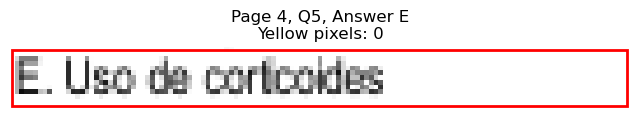


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=163.0, y1=422.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 367
Page 4, Q6, A: Yellow percentage: 0.0%


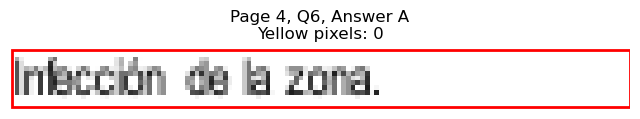

Page 4, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=126.2, y1=434.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 436
Page 4, Q6, B: Yellow percentage: 0.0%


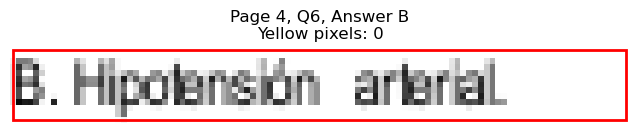

Page 4, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=210.2, y1=446.6
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 634
Page 4, Q6, C: Yellow percentage: 0.0%


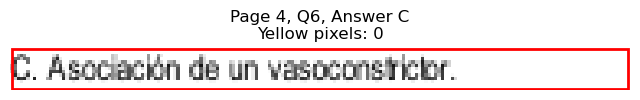

Page 4, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=415.3, y1=422.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 440
Page 4, Q6, D: Yellow percentage: 0.0%


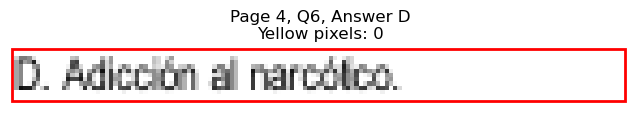

Page 4, Q6 - E: Detected box: x0=385.9, y0=422.5, x1=484.5, y1=434.6
Page 4, Q6, E: Yellow pixels: 763
Page 4, Q6, E: Total non-white pixels: 1274
Page 4, Q6, E: Yellow percentage: 59.9%


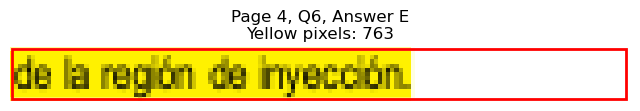


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=470.6, x1=119.5, y1=482.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 181
Page 4, Q7, A: Yellow percentage: 0.0%


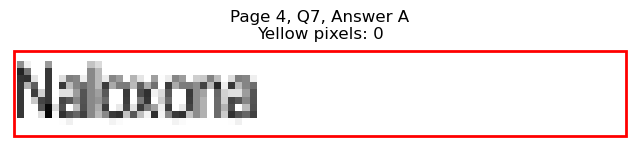

Page 4, Q7 - B: Detected box: x0=71.3, y0=483.4, x1=129.3, y1=495.4
Page 4, Q7, B: Yellow pixels: 477
Page 4, Q7, B: Total non-white pixels: 728
Page 4, Q7, B: Yellow percentage: 65.5%


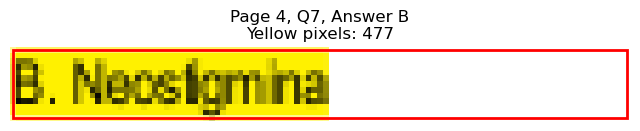

Page 4, Q7 - C: Detected box: x0=71.3, y0=495.4, x1=137.5, y1=507.4
Page 4, Q7, C: Yellow pixels: 55
Page 4, Q7, C: Total non-white pixels: 363
Page 4, Q7, C: Yellow percentage: 15.2%


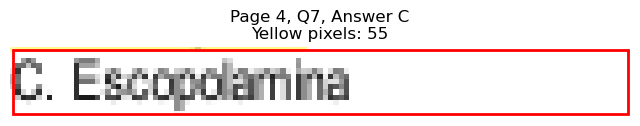

Page 4, Q7 - D: Detected box: x0=322.9, y0=470.6, x1=366.6, y1=482.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 209
Page 4, Q7, D: Yellow percentage: 0.0%


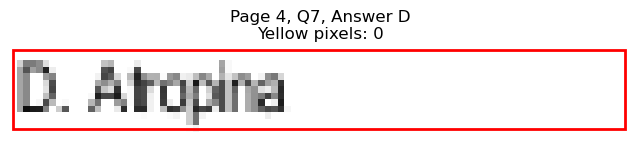

Page 4, Q7 - E: Detected box: x0=322.9, y0=483.4, x1=378.6, y1=495.4
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 270
Page 4, Q7, E: Yellow percentage: 0.0%


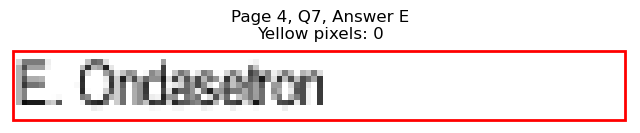


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=531.4, x1=117.3, y1=543.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 190
Page 4, Q8, A: Yellow percentage: 0.0%


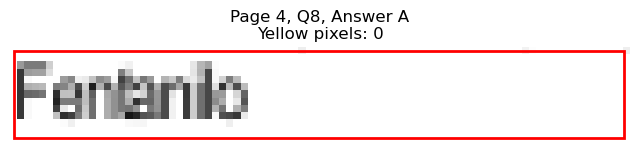

Page 4, Q8 - B: Detected box: x0=71.3, y0=543.4, x1=115.8, y1=555.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 237
Page 4, Q8, B: Yellow percentage: 0.0%


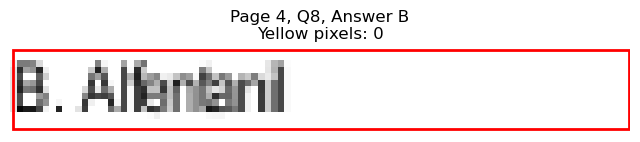

Page 4, Q8 - C: Detected box: x0=71.3, y0=555.4, x1=126.3, y1=567.5
Page 4, Q8, C: Yellow pixels: 464
Page 4, Q8, C: Total non-white pixels: 689
Page 4, Q8, C: Yellow percentage: 67.3%


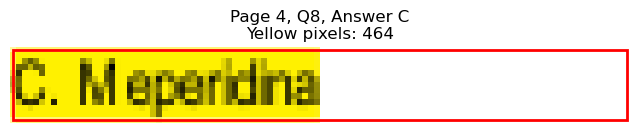

Page 4, Q8 - D: Detected box: x0=322.9, y0=531.4, x1=372.6, y1=543.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 269
Page 4, Q8, D: Yellow percentage: 0.0%


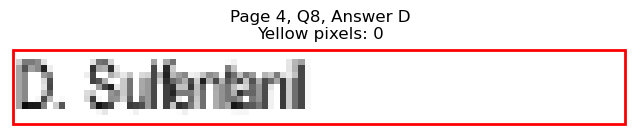

Page 4, Q8 - E: Detected box: x0=322.9, y0=543.4, x1=380.1, y1=555.5
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 295
Page 4, Q8, E: Yellow percentage: 0.0%


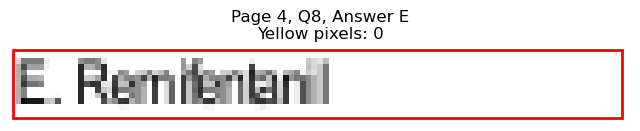


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=603.5, x1=123.2, y1=615.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 204
Page 4, Q9, A: Yellow percentage: 0.0%


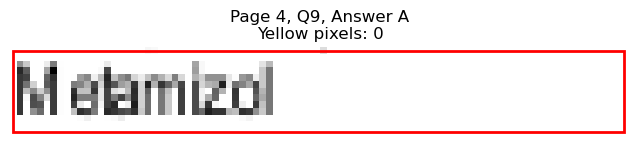

Page 4, Q9 - B: Detected box: x0=71.3, y0=615.5, x1=124.8, y1=627.5
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 265
Page 4, Q9, B: Yellow percentage: 0.0%


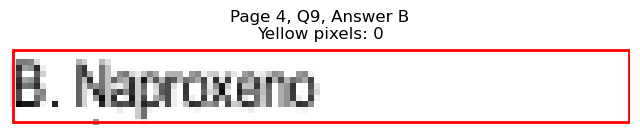

Page 4, Q9 - C: Detected box: x0=71.3, y0=627.5, x1=157.8, y1=639.6
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 440
Page 4, Q9, C: Yellow percentage: 0.0%


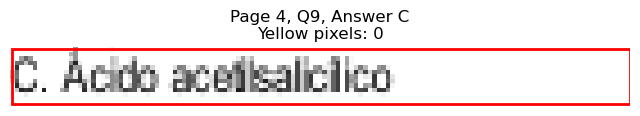

Page 4, Q9 - D: Detected box: x0=322.9, y0=603.5, x1=376.3, y1=615.5
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 246
Page 4, Q9, D: Yellow percentage: 0.0%


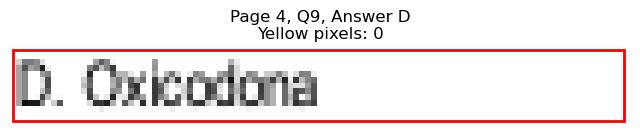

Page 4, Q9 - E: Detected box: x0=322.9, y0=615.5, x1=382.4, y1=627.5
Page 4, Q9, E: Yellow pixels: 508
Page 4, Q9, E: Total non-white pixels: 754
Page 4, Q9, E: Yellow percentage: 67.4%


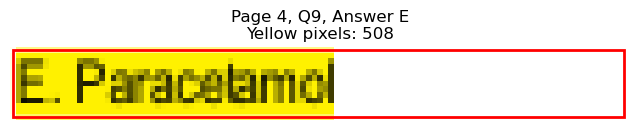


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=82.6, y0=663.5, x1=147.3, y1=675.6
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 349
Page 4, Q10, A: Yellow percentage: 0.0%


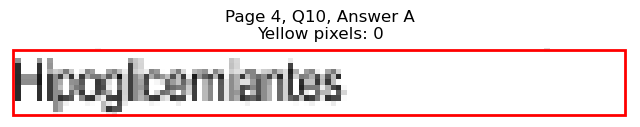

Page 4, Q10 - B: Detected box: x0=71.3, y0=676.3, x1=116.5, y1=688.3
Page 4, Q10, B: Yellow pixels: 337
Page 4, Q10, B: Total non-white pixels: 572
Page 4, Q10, B: Yellow percentage: 58.9%


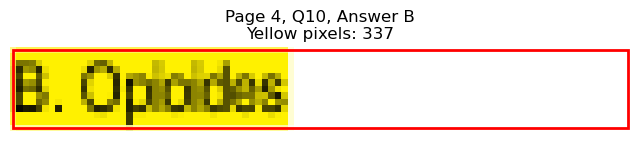

Page 4, Q10 - C: Detected box: x0=71.3, y0=688.3, x1=104.5, y1=700.3
Page 4, Q10, C: Yellow pixels: 1
Page 4, Q10, C: Total non-white pixels: 185
Page 4, Q10, C: Yellow percentage: 0.5%


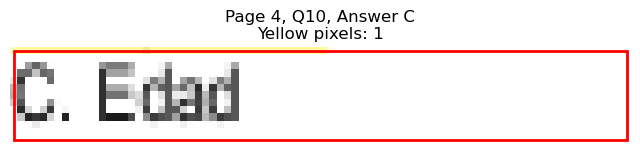

Page 4, Q10 - D: Detected box: x0=322.9, y0=663.5, x1=371.8, y1=675.6
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 247
Page 4, Q10, D: Yellow percentage: 0.0%


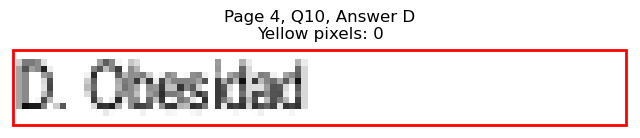

Page 4, Q10 - E: Detected box: x0=322.9, y0=676.3, x1=401.1, y1=688.3
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 600
Page 4, Q10, E: Yellow percentage: 0.0%


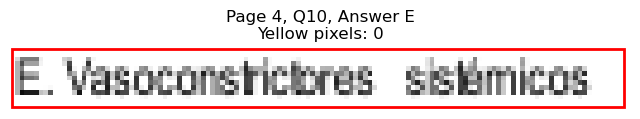


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=71.3, y0=736.4, x1=79.7, y1=748.4
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 59
Page 4, Q11, A: Yellow percentage: 0.0%


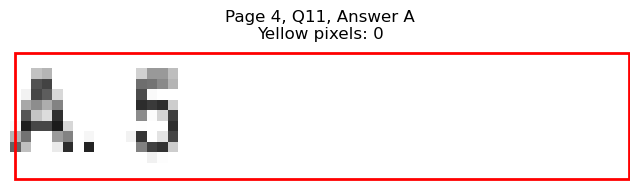

Page 4, Q11 - B: Detected box: x0=71.3, y0=121.5, x1=88.7, y1=133.6
Page 4, Q11, B: Yellow pixels: 143
Page 4, Q11, B: Total non-white pixels: 208
Page 4, Q11, B: Yellow percentage: 68.8%


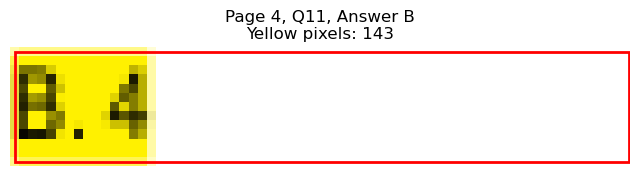

Page 4, Q11 - C: Detected box: x0=71.3, y0=133.5, x1=89.5, y1=145.6
Page 4, Q11, C: Yellow pixels: 15
Page 4, Q11, C: Total non-white pixels: 73
Page 4, Q11, C: Yellow percentage: 20.5%


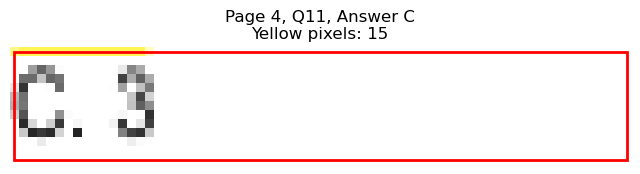

Page 4, Q11 - D: Detected box: x0=322.9, y0=109.5, x1=341.0, y1=121.6
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 72
Page 4, Q11, D: Yellow percentage: 0.0%


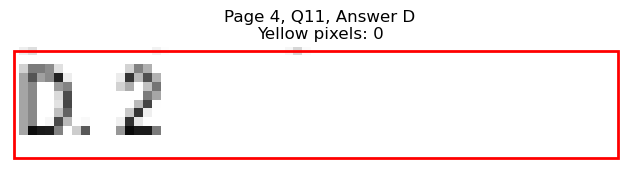

Page 4, Q11 - E: Detected box: x0=322.9, y0=748.4, x1=350.1, y1=760.4
Page 4, Q11, E: Yellow pixels: 0
Page 4, Q11, E: Total non-white pixels: 93
Page 4, Q11, E: Yellow percentage: 0.0%


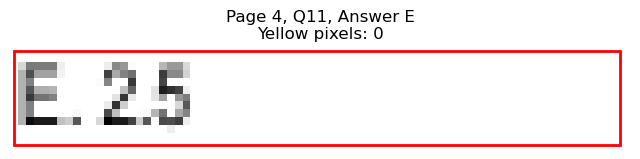


Page 4, Q11 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=132.3, y1=108.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 254
Page 5, Q1, A: Yellow percentage: 0.0%


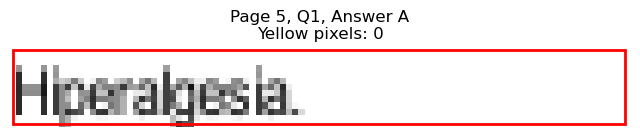

Page 5, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=124.0, y1=121.6
Page 5, Q1, B: Yellow pixels: 448
Page 5, Q1, B: Total non-white pixels: 663
Page 5, Q1, B: Yellow percentage: 67.6%


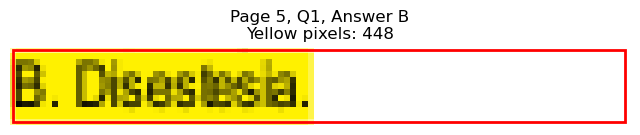

Page 5, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=123.2, y1=133.6
Page 5, Q1, C: Yellow pixels: 51
Page 5, Q1, C: Total non-white pixels: 296
Page 5, Q1, C: Yellow percentage: 17.2%


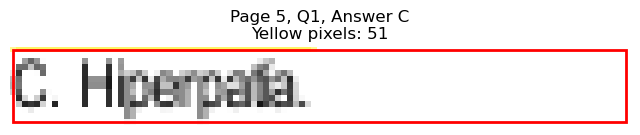

Page 5, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=367.3, y1=108.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 213
Page 5, Q1, D: Yellow percentage: 0.0%


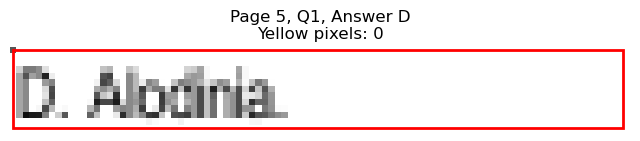

Page 5, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=383.0, y1=121.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 297
Page 5, Q1, E: Yellow percentage: 0.0%


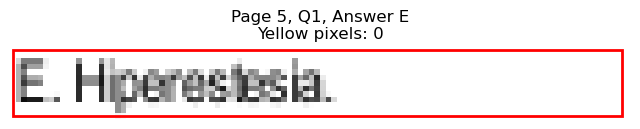


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=94.0, y1=181.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 41
Page 5, Q2, A: Yellow percentage: 0.0%


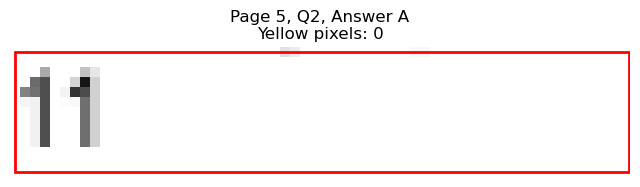

Page 5, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=93.2, y1=193.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 85
Page 5, Q2, B: Yellow percentage: 0.0%


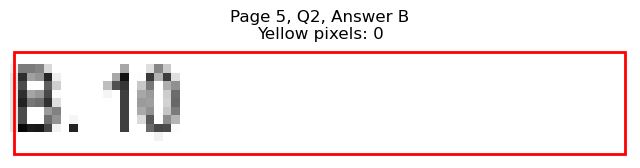

Page 5, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=94.0, y1=205.6
Page 5, Q2, C: Yellow pixels: 194
Page 5, Q2, C: Total non-white pixels: 273
Page 5, Q2, C: Yellow percentage: 71.1%


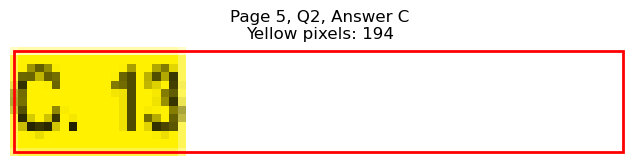

Page 5, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=341.0, y1=181.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 73
Page 5, Q2, D: Yellow percentage: 0.0%


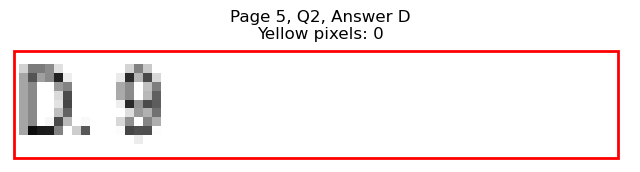

Page 5, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=340.3, y1=193.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 58
Page 5, Q2, E: Yellow percentage: 0.0%


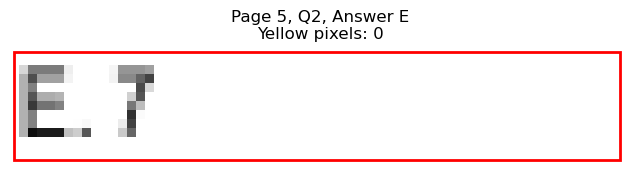


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=109.6, y0=229.6, x1=136.0, y1=241.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 142
Page 5, Q3, A: Yellow percentage: 0.0%


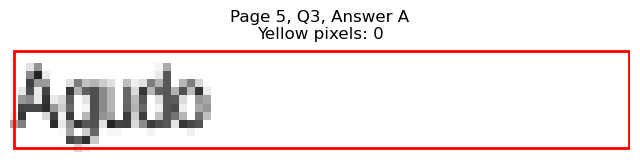

Page 5, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=124.7, y1=253.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 481
Page 5, Q3, B: Yellow percentage: 0.0%


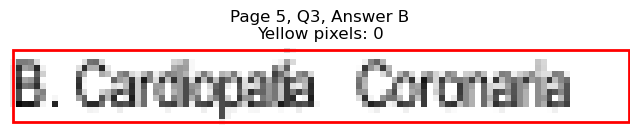

Page 5, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=147.3, y1=265.7
Page 5, Q3, C: Yellow pixels: 573
Page 5, Q3, C: Total non-white pixels: 962
Page 5, Q3, C: Yellow percentage: 59.6%


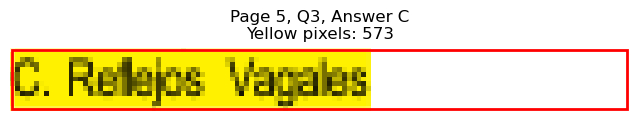

Page 5, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=435.5, y1=241.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 535
Page 5, Q3, D: Yellow percentage: 0.0%


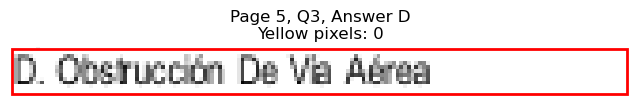

Page 5, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=413.0, y1=253.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 465
Page 5, Q3, E: Yellow percentage: 0.0%


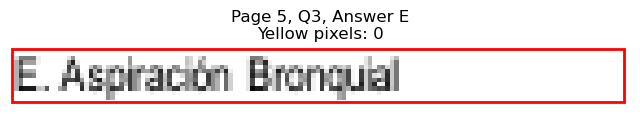


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=133.1, y1=314.5
Page 5, Q4, A: Yellow pixels: 433
Page 5, Q4, A: Total non-white pixels: 637
Page 5, Q4, A: Yellow percentage: 68.0%


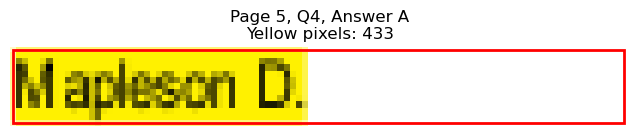

Page 5, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=103.0, y1=326.5
Page 5, Q4, B: Yellow pixels: 47
Page 5, Q4, B: Total non-white pixels: 189
Page 5, Q4, B: Yellow percentage: 24.9%


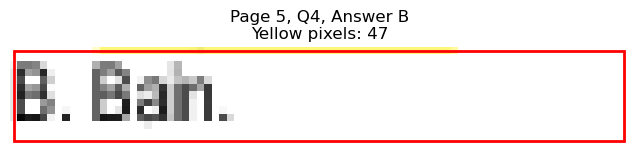

Page 5, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=132.3, y1=338.5
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 257
Page 5, Q4, C: Yellow percentage: 0.0%


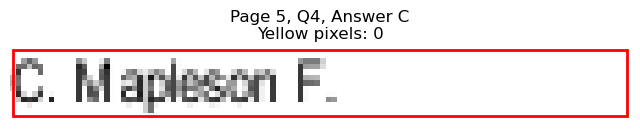

Page 5, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=398.9, y1=314.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 363
Page 5, Q4, D: Yellow percentage: 0.0%


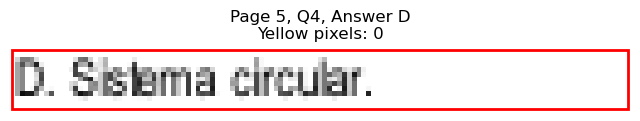

Page 5, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=389.9, y1=326.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 301
Page 5, Q4, E: Yellow percentage: 0.0%


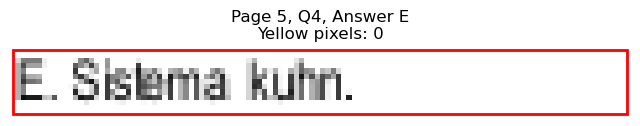


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=130.0, y1=398.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 473
Page 5, Q5, A: Yellow percentage: 0.0%


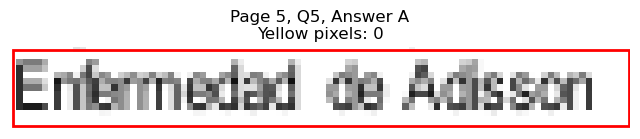

Page 5, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=135.2, y1=410.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 343
Page 5, Q5, B: Yellow percentage: 0.0%


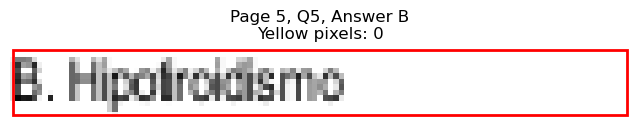

Page 5, Q5 - C: Detected box: x0=132.2, y0=410.5, x1=260.7, y1=422.6
Page 5, Q5, C: Yellow pixels: 988
Page 5, Q5, C: Total non-white pixels: 1651
Page 5, Q5, C: Yellow percentage: 59.8%


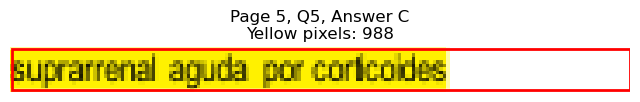

Page 5, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=381.6, y1=398.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 438
Page 5, Q5, D: Yellow percentage: 0.0%


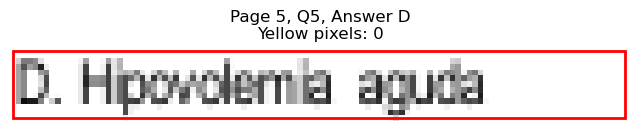

Page 5, Q5 - E: Detected box: x0=360.5, y0=398.5, x1=434.1, y1=410.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 381
Page 5, Q5, E: Yellow percentage: 0.0%


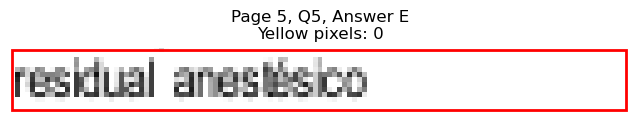


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=184.8, y1=470.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 487
Page 5, Q6, A: Yellow percentage: 0.0%


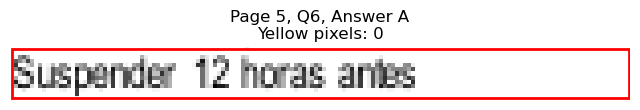

Page 5, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=184.0, y1=482.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 543
Page 5, Q6, B: Yellow percentage: 0.0%


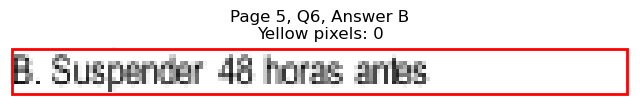

Page 5, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=175.8, y1=495.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 492
Page 5, Q6, C: Yellow percentage: 0.0%


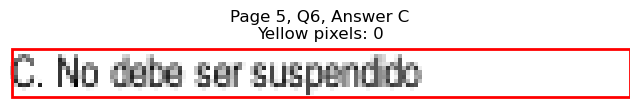

Page 5, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=431.9, y1=470.6
Page 5, Q6, D: Yellow pixels: 852
Page 5, Q6, D: Total non-white pixels: 1404
Page 5, Q6, D: Yellow percentage: 60.7%


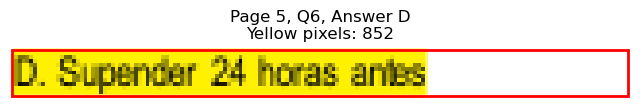

Page 5, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=430.4, y1=482.6
Page 5, Q6, E: Yellow pixels: 107
Page 5, Q6, E: Total non-white pixels: 611
Page 5, Q6, E: Yellow percentage: 17.5%


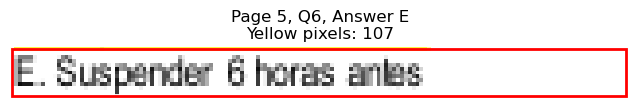


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=71.3, y0=519.4, x1=79.7, y1=531.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 51
Page 5, Q7, A: Yellow percentage: 0.0%


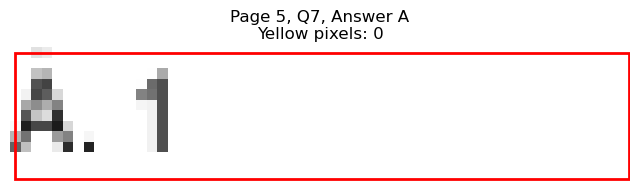

Page 5, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=100.0, y1=543.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 122
Page 5, Q7, B: Yellow percentage: 0.0%


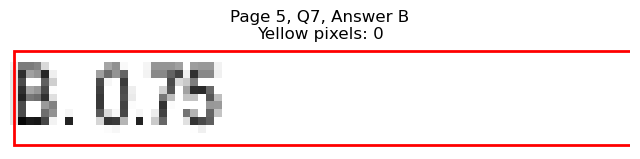

Page 5, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=89.5, y1=555.5
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 62
Page 5, Q7, C: Yellow percentage: 0.0%


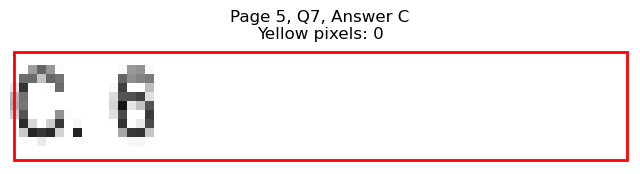

Page 5, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=341.1, y1=531.4
Page 5, Q7, D: Yellow pixels: 149
Page 5, Q7, D: Total non-white pixels: 221
Page 5, Q7, D: Yellow percentage: 67.4%


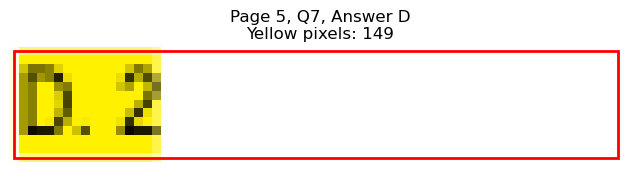

Page 5, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=347.0, y1=543.5
Page 5, Q7, E: Yellow pixels: 15
Page 5, Q7, E: Total non-white pixels: 101
Page 5, Q7, E: Yellow percentage: 14.9%


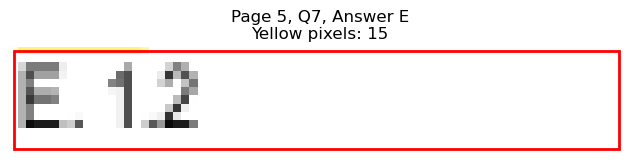


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=196.9, y1=603.5
Page 5, Q8, A: Yellow pixels: 997
Page 5, Q8, A: Total non-white pixels: 1469
Page 5, Q8, A: Yellow percentage: 67.9%


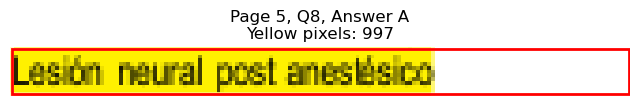

Page 5, Q8 - B: Detected box: x0=118.7, y0=603.5, x1=168.3, y1=615.5
Page 5, Q8, B: Yellow pixels: 76
Page 5, Q8, B: Total non-white pixels: 326
Page 5, Q8, B: Yellow percentage: 23.3%


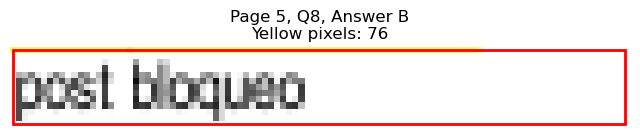

Page 5, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=156.3, y1=627.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 409
Page 5, Q8, C: Yellow percentage: 0.0%


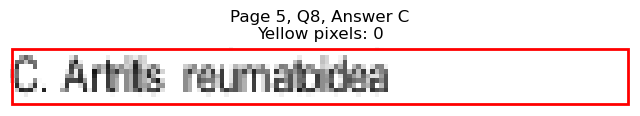

Page 5, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=406.4, y1=603.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 580
Page 5, Q8, D: Yellow percentage: 0.0%


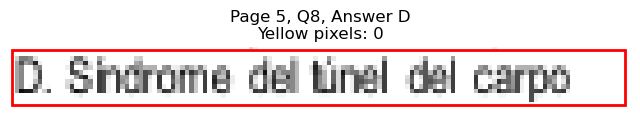

Page 5, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=390.6, y1=615.5
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 319
Page 5, Q8, E: Yellow percentage: 0.0%


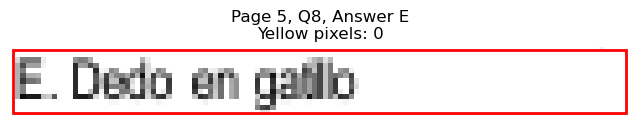


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=124.8, y1=675.6
Page 5, Q9, A: Yellow pixels: 299
Page 5, Q9, A: Total non-white pixels: 533
Page 5, Q9, A: Yellow percentage: 56.1%


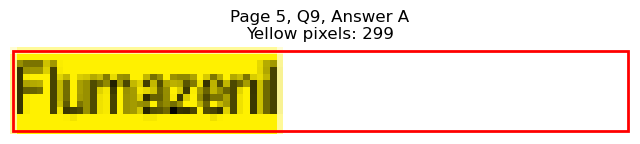

Page 5, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=118.8, y1=688.3
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 274
Page 5, Q9, B: Yellow percentage: 0.0%


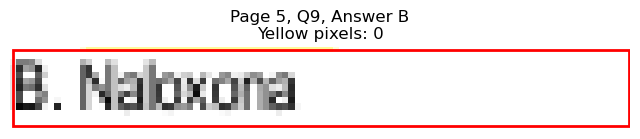

Page 5, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=124.0, y1=700.3
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 240
Page 5, Q9, C: Yellow percentage: 0.0%


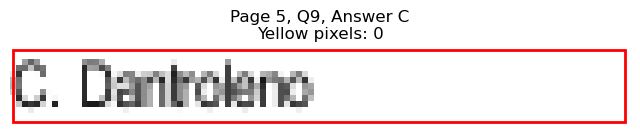

Page 5, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=379.3, y1=675.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 274
Page 5, Q9, D: Yellow percentage: 0.0%


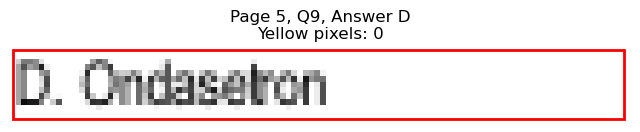

Page 5, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=373.3, y1=688.3
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 236
Page 5, Q9, E: Yellow percentage: 0.0%


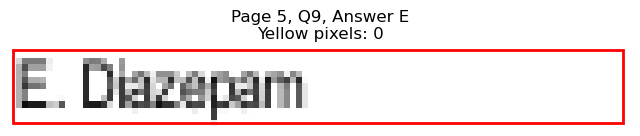


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=129.9, y0=748.4, x1=186.3, y1=760.4
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 287
Page 5, Q10, A: Yellow percentage: 0.0%


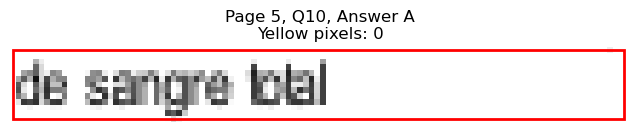

Page 5, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=175.8, y1=772.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 530
Page 5, Q10, B: Yellow percentage: 0.0%


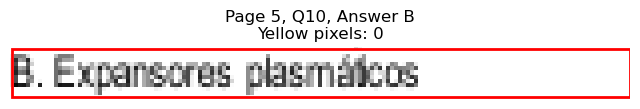

Page 5, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=127.8, y1=784.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 275
Page 5, Q10, C: Yellow percentage: 0.0%


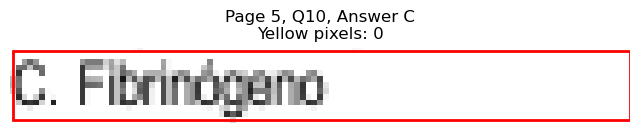

Page 5, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=392.1, y1=760.4
Page 5, Q10, D: Yellow pixels: 977
Page 5, Q10, D: Total non-white pixels: 1443
Page 5, Q10, D: Yellow percentage: 67.7%


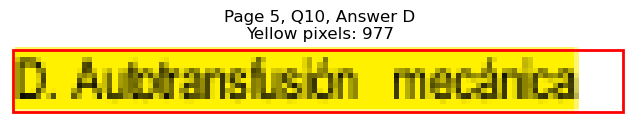

Page 5, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=377.8, y1=772.4
Page 5, Q10, E: Yellow pixels: 105
Page 5, Q10, E: Total non-white pixels: 374
Page 5, Q10, E: Yellow percentage: 28.1%


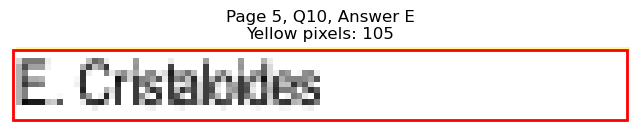


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=122.5, y1=108.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 219
Page 6, Q1, A: Yellow percentage: 0.0%


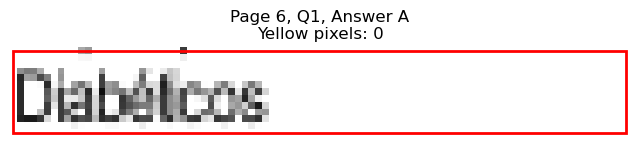

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=123.3, y1=121.6
Page 6, Q1, B: Yellow pixels: 458
Page 6, Q1, B: Total non-white pixels: 650
Page 6, Q1, B: Yellow percentage: 70.5%


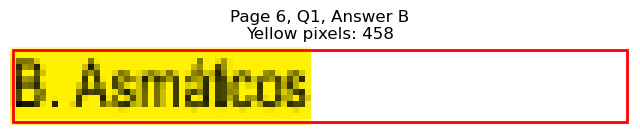

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=134.5, y1=133.6
Page 6, Q1, C: Yellow pixels: 50
Page 6, Q1, C: Total non-white pixels: 353
Page 6, Q1, C: Yellow percentage: 14.2%


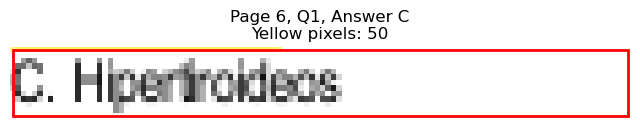

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=413.1, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 424
Page 6, Q1, D: Yellow percentage: 0.0%


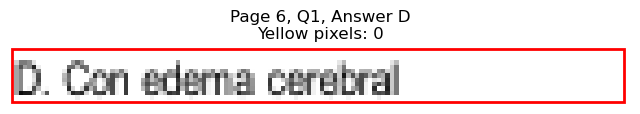

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=431.9, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 531
Page 6, Q1, E: Yellow percentage: 0.0%


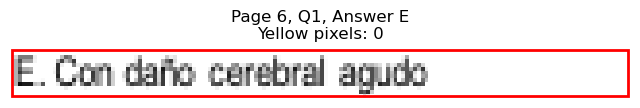


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=124.0, y1=169.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 205
Page 6, Q2, A: Yellow percentage: 0.0%


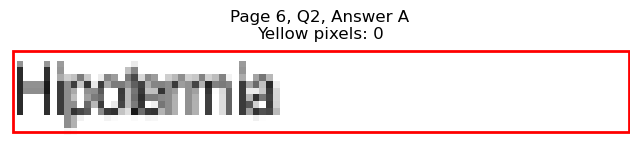

Page 6, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=129.3, y1=181.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 574
Page 6, Q2, B: Yellow percentage: 0.0%


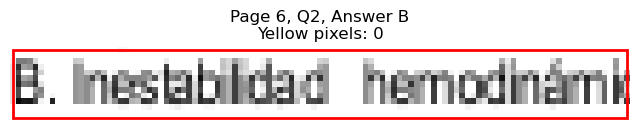

Page 6, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=128.5, y1=193.6
Page 6, Q2, C: Yellow pixels: 815
Page 6, Q2, C: Total non-white pixels: 1326
Page 6, Q2, C: Yellow percentage: 61.5%


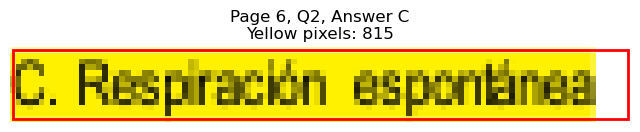

Page 6, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=412.4, y1=169.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 443
Page 6, Q2, D: Yellow percentage: 0.0%


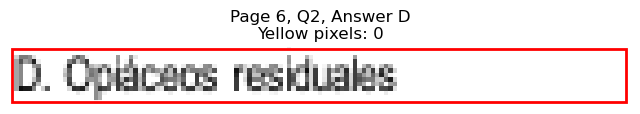

Page 6, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=373.3, y1=181.6
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 491
Page 6, Q2, E: Yellow percentage: 0.0%


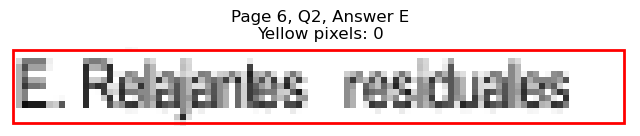


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=71.3, y0=217.6, x1=79.7, y1=229.7
Page 6, Q3, A: Yellow pixels: 27
Page 6, Q3, A: Total non-white pixels: 112
Page 6, Q3, A: Yellow percentage: 24.1%


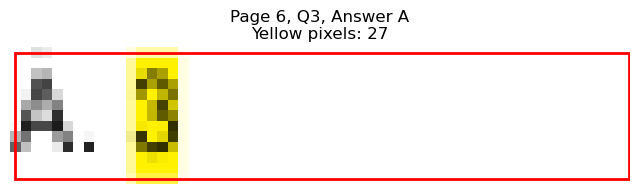

Page 6, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=88.7, y1=241.7
Page 6, Q3, B: Yellow pixels: 4
Page 6, Q3, B: Total non-white pixels: 67
Page 6, Q3, B: Yellow percentage: 6.0%


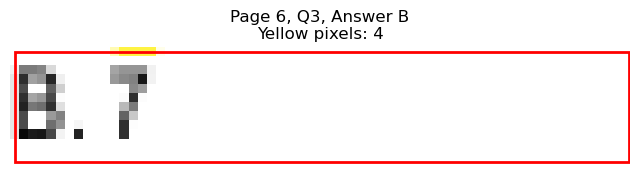

Page 6, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=89.5, y1=253.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 57
Page 6, Q3, C: Yellow percentage: 0.0%


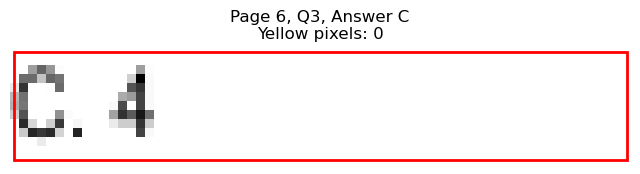

Page 6, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=341.0, y1=229.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 74
Page 6, Q3, D: Yellow percentage: 0.0%


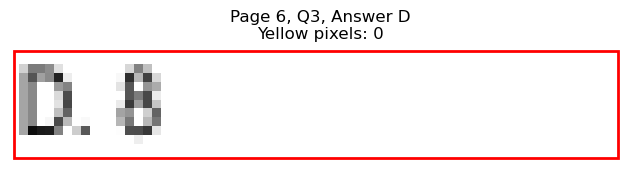

Page 6, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=340.3, y1=241.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 54
Page 6, Q3, E: Yellow percentage: 0.0%


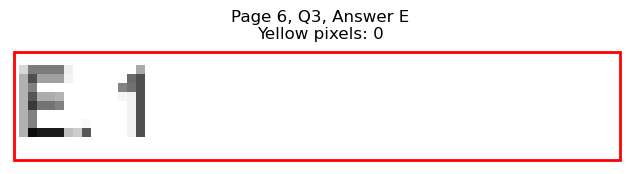


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=117.3, y1=301.8
Page 6, Q4, A: Yellow pixels: 234
Page 6, Q4, A: Total non-white pixels: 429
Page 6, Q4, A: Yellow percentage: 54.5%


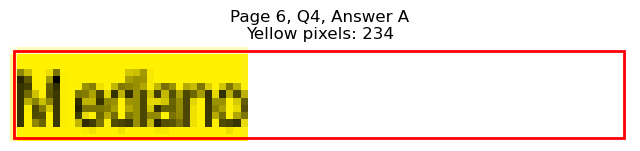

Page 6, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=108.3, y1=314.5
Page 6, Q4, B: Yellow pixels: 32
Page 6, Q4, B: Total non-white pixels: 222
Page 6, Q4, B: Yellow percentage: 14.4%


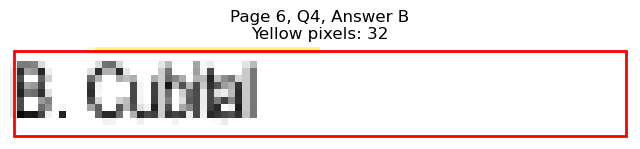

Page 6, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=107.5, y1=326.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 162
Page 6, Q4, C: Yellow percentage: 0.0%


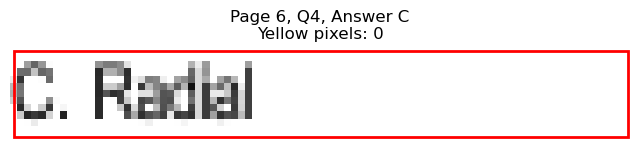

Page 6, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=372.6, y1=301.8
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 258
Page 6, Q4, D: Yellow percentage: 0.0%


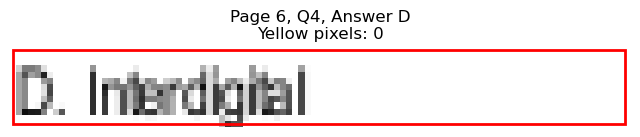

Page 6, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=365.8, y1=314.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 422
Page 6, Q4, E: Yellow percentage: 0.0%


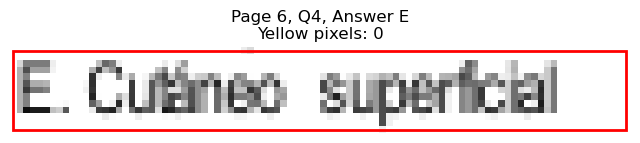


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=121.8, y1=374.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 192
Page 6, Q5, A: Yellow percentage: 0.0%


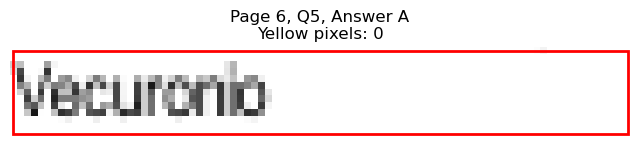

Page 6, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=118.7, y1=386.6
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 231
Page 6, Q5, B: Yellow percentage: 0.0%


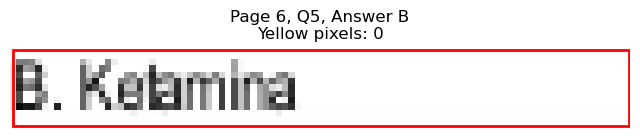

Page 6, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=115.0, y1=398.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 189
Page 6, Q5, C: Yellow percentage: 0.0%


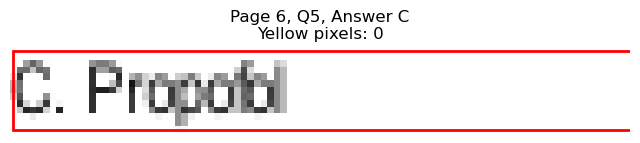

Page 6, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=386.1, y1=374.6
Page 6, Q5, D: Yellow pixels: 528
Page 6, Q5, D: Total non-white pixels: 806
Page 6, Q5, D: Yellow percentage: 65.5%


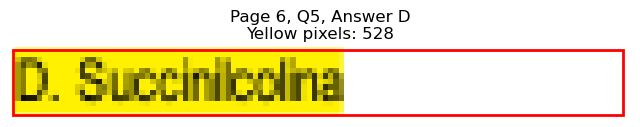

Page 6, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=368.1, y1=386.6
Page 6, Q5, E: Yellow pixels: 61
Page 6, Q5, E: Total non-white pixels: 286
Page 6, Q5, E: Yellow percentage: 21.3%


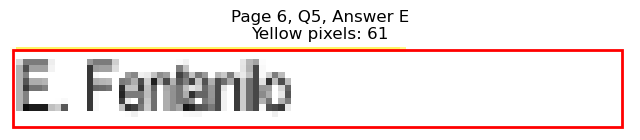


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=174.3, y1=434.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 686
Page 6, Q6, A: Yellow percentage: 0.0%


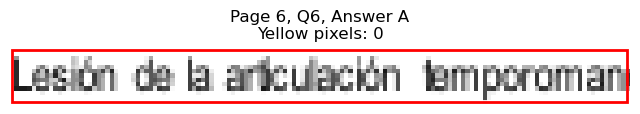

Page 6, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=206.5, y1=446.6
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 660
Page 6, Q6, B: Yellow percentage: 0.0%


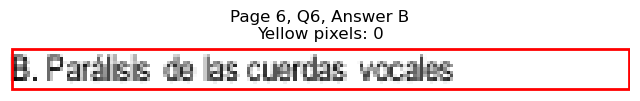

Page 6, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=156.3, y1=458.6
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 400
Page 6, Q6, C: Yellow percentage: 0.0%


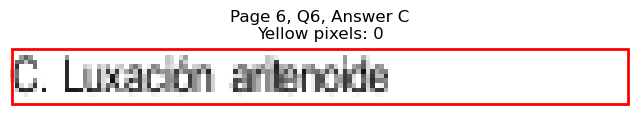

Page 6, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=416.1, y1=434.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 464
Page 6, Q6, D: Yellow percentage: 0.0%


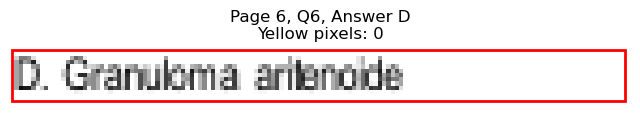

Page 6, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=409.4, y1=446.6
Page 6, Q6, E: Yellow pixels: 661
Page 6, Q6, E: Total non-white pixels: 1118
Page 6, Q6, E: Yellow percentage: 59.1%


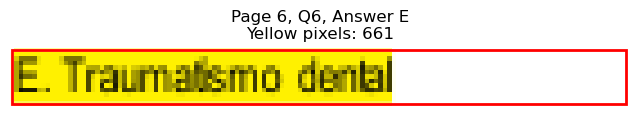


Page 6, Q6 - Selected Answer: E (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=174.3, y1=507.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 458
Page 6, Q7, A: Yellow percentage: 0.0%


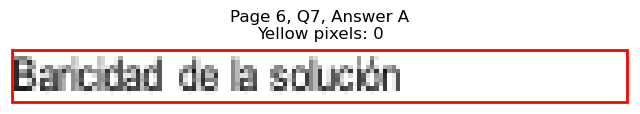

Page 6, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=163.1, y1=519.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 458
Page 6, Q7, B: Yellow percentage: 0.0%


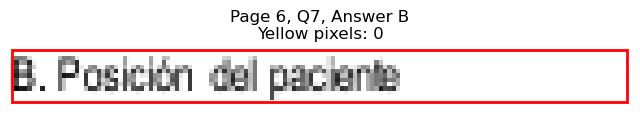

Page 6, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=154.8, y1=531.4
Page 6, Q7, C: Yellow pixels: 740
Page 6, Q7, C: Total non-white pixels: 1066
Page 6, Q7, C: Yellow percentage: 69.4%


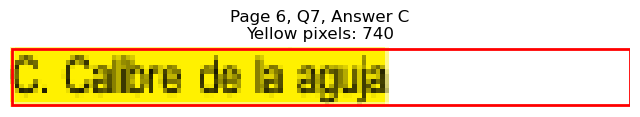

Page 6, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=402.6, y1=507.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 383
Page 6, Q7, D: Yellow percentage: 0.0%


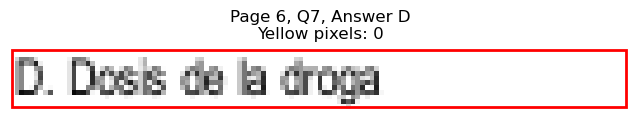

Page 6, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=368.1, y1=519.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 424
Page 6, Q7, E: Yellow percentage: 0.0%


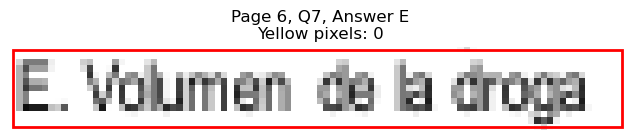


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=136.8, y1=567.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 261
Page 6, Q8, A: Yellow percentage: 0.0%


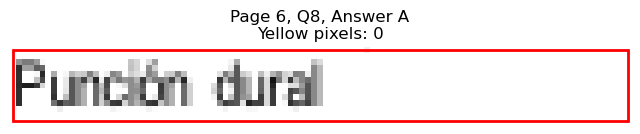

Page 6, Q8 - B: Detected box: x0=114.2, y0=567.5, x1=185.6, y1=579.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 363
Page 6, Q8, B: Yellow percentage: 0.0%


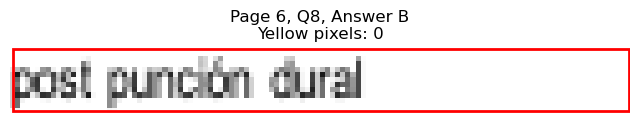

Page 6, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=169.8, y1=591.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 474
Page 6, Q8, C: Yellow percentage: 0.0%


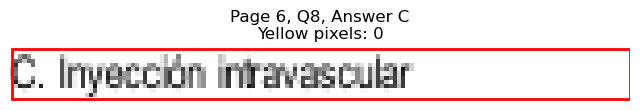

Page 6, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=400.4, y1=567.5
Page 6, Q8, D: Yellow pixels: 663
Page 6, Q8, D: Total non-white pixels: 988
Page 6, Q8, D: Yellow percentage: 67.1%


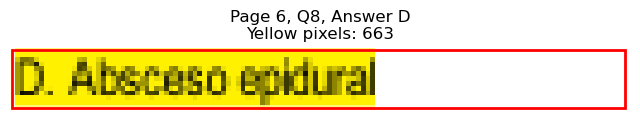

Page 6, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=455.1, y1=579.5
Page 6, Q8, E: Yellow pixels: 75
Page 6, Q8, E: Total non-white pixels: 731
Page 6, Q8, E: Yellow percentage: 10.3%


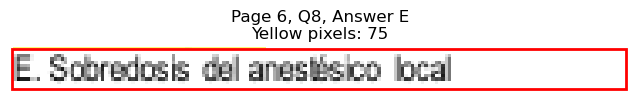


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=615.5, x1=148.8, y1=627.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 321
Page 6, Q9, A: Yellow percentage: 0.0%


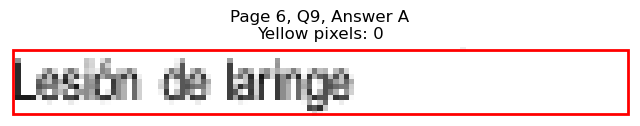

Page 6, Q9 - B: Detected box: x0=71.3, y0=627.5, x1=165.3, y1=639.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 659
Page 6, Q9, B: Yellow percentage: 0.0%


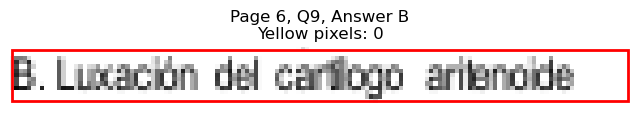

Page 6, Q9 - C: Detected box: x0=71.3, y0=639.5, x1=127.0, y1=651.6
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 430
Page 6, Q9, C: Yellow percentage: 0.0%


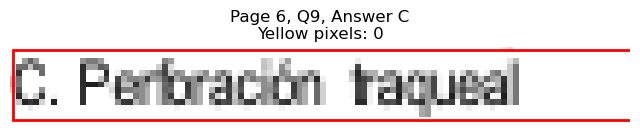

Page 6, Q9 - D: Detected box: x0=322.9, y0=615.5, x1=398.9, y1=627.5
Page 6, Q9, D: Yellow pixels: 650
Page 6, Q9, D: Total non-white pixels: 976
Page 6, Q9, D: Yellow percentage: 66.6%


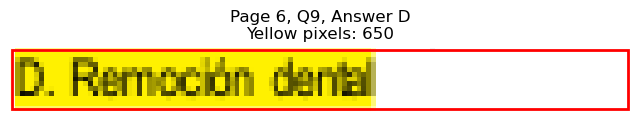

Page 6, Q9 - E: Detected box: x0=322.9, y0=627.5, x1=397.3, y1=639.6
Page 6, Q9, E: Yellow pixels: 73
Page 6, Q9, E: Total non-white pixels: 424
Page 6, Q9, E: Yellow percentage: 17.2%


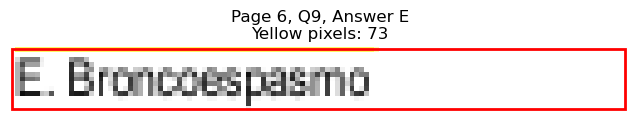


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=676.3, x1=113.5, y1=688.3
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 151
Page 6, Q10, A: Yellow percentage: 0.0%


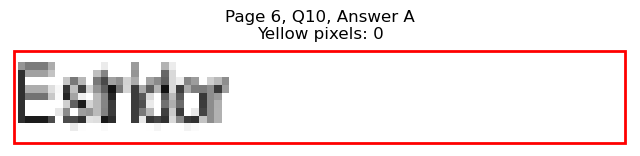

Page 6, Q10 - B: Detected box: x0=71.3, y0=688.3, x1=112.8, y1=700.3
Page 6, Q10, B: Yellow pixels: 305
Page 6, Q10, B: Total non-white pixels: 520
Page 6, Q10, B: Yellow percentage: 58.7%


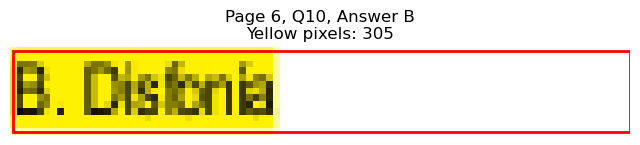

Page 6, Q10 - C: Detected box: x0=71.3, y0=700.3, x1=129.3, y1=712.3
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 560
Page 6, Q10, C: Yellow percentage: 0.0%


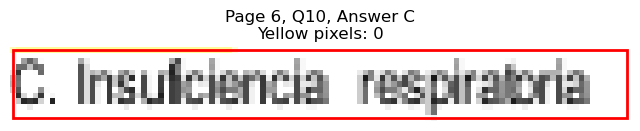

Page 6, Q10 - D: Detected box: x0=322.9, y0=676.3, x1=358.3, y1=688.3
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 302
Page 6, Q10, D: Yellow percentage: 0.0%


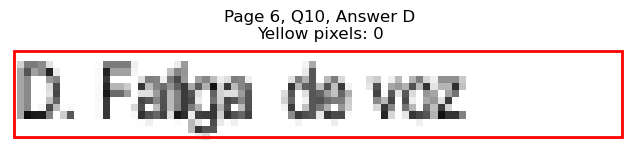

Page 6, Q10 - E: Detected box: x0=322.9, y0=688.3, x1=358.3, y1=700.3
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 169
Page 6, Q10, E: Yellow percentage: 0.0%


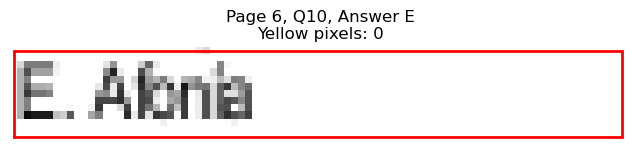


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=121.0, y1=760.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 399
Page 6, Q11, A: Yellow percentage: 0.0%


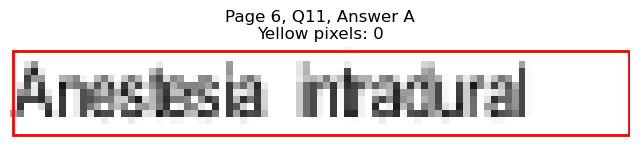

Page 6, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=120.2, y1=772.4
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 406
Page 6, Q11, B: Yellow percentage: 0.0%


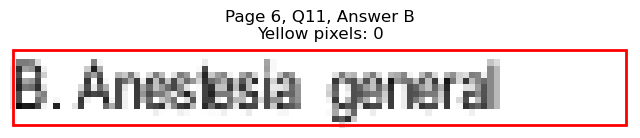

Page 6, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=176.6, y1=784.4
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 522
Page 6, Q11, C: Yellow percentage: 0.0%


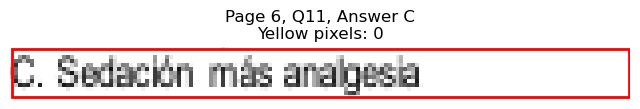

Page 6, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=404.9, y1=760.4
Page 6, Q11, D: Yellow pixels: 697
Page 6, Q11, D: Total non-white pixels: 1053
Page 6, Q11, D: Yellow percentage: 66.2%


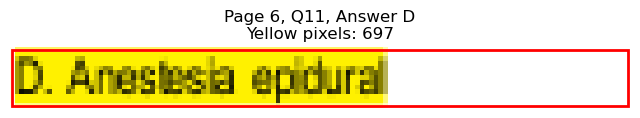

Page 6, Q11 - E: Detected box: x0=374.0, y0=760.4, x1=447.6, y1=772.4
Page 6, Q11, E: Yellow pixels: 29
Page 6, Q11, E: Total non-white pixels: 398
Page 6, Q11, E: Yellow percentage: 7.3%


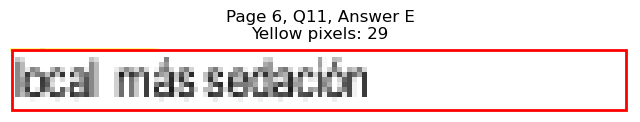


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=115.0, y1=108.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 168
Page 7, Q1, A: Yellow percentage: 0.0%


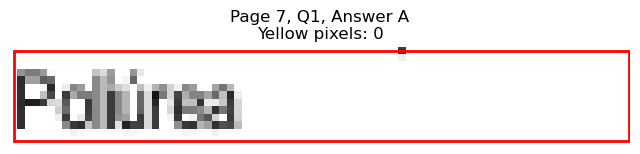

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=106.7, y1=121.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 182
Page 7, Q1, B: Yellow percentage: 0.0%


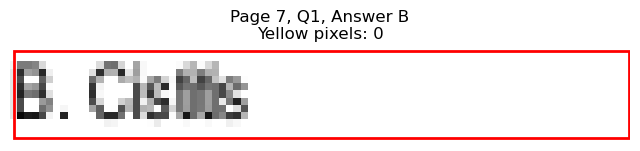

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=142.8, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 329
Page 7, Q1, C: Yellow percentage: 0.0%


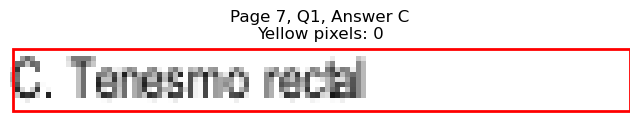

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=372.6, y1=108.8
Page 7, Q1, D: Yellow pixels: 643
Page 7, Q1, D: Total non-white pixels: 1053
Page 7, Q1, D: Yellow percentage: 61.1%


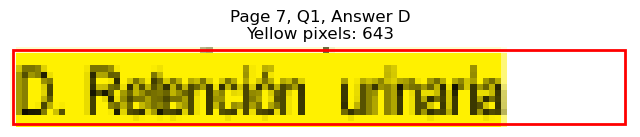

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=385.3, y1=121.6
Page 7, Q1, E: Yellow pixels: 79
Page 7, Q1, E: Total non-white pixels: 388
Page 7, Q1, E: Yellow percentage: 20.4%


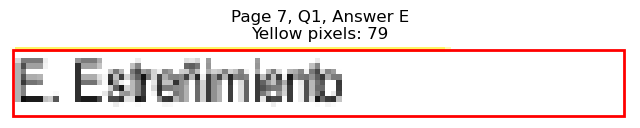


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=128.5, y1=169.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 234
Page 7, Q2, A: Yellow percentage: 0.0%


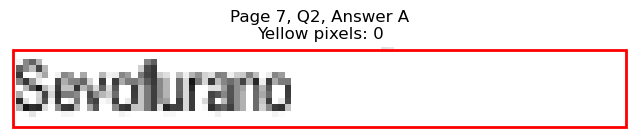

Page 7, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=115.8, y1=181.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 224
Page 7, Q2, B: Yellow percentage: 0.0%


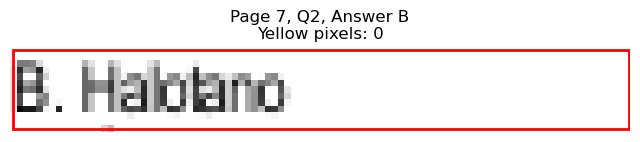

Page 7, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=133.8, y1=193.6
Page 7, Q2, C: Yellow pixels: 504
Page 7, Q2, C: Total non-white pixels: 793
Page 7, Q2, C: Yellow percentage: 63.6%


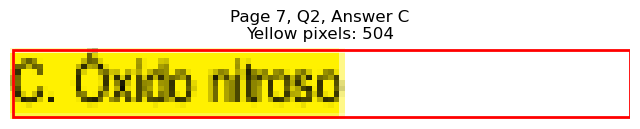

Page 7, Q2 - D: Detected box: x0=322.9, y0=398.5, x1=371.9, y1=410.6
Page 7, Q2, D: Yellow pixels: 416
Page 7, Q2, D: Total non-white pixels: 626
Page 7, Q2, D: Yellow percentage: 66.5%


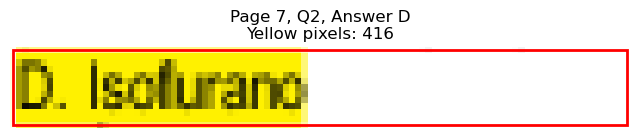

Page 7, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=374.8, y1=181.6
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 247
Page 7, Q2, E: Yellow percentage: 0.0%


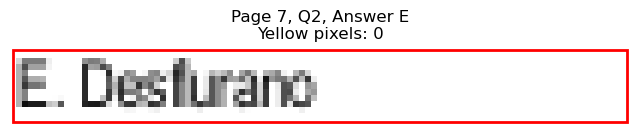


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=174.2, y1=229.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 700
Page 7, Q3, A: Yellow percentage: 0.0%


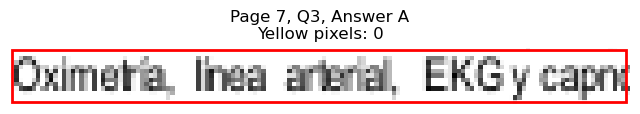

Page 7, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=190.8, y1=241.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 828
Page 7, Q3, B: Yellow percentage: 0.0%


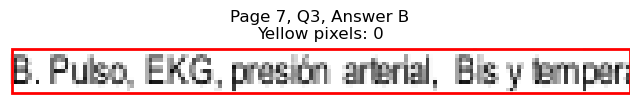

Page 7, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=190.8, y1=253.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 787
Page 7, Q3, C: Yellow percentage: 0.0%


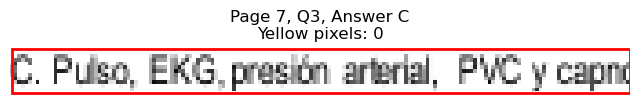

Page 7, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=481.5, y1=229.7
Page 7, Q3, D: Yellow pixels: 1354
Page 7, Q3, D: Total non-white pixels: 2171
Page 7, Q3, D: Yellow percentage: 62.4%


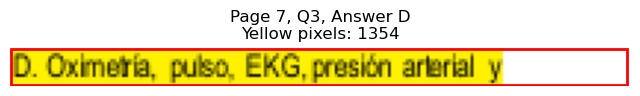

Page 7, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=442.4, y1=253.7
Page 7, Q3, E: Yellow pixels: 46
Page 7, Q3, E: Total non-white pixels: 849
Page 7, Q3, E: Yellow percentage: 5.4%


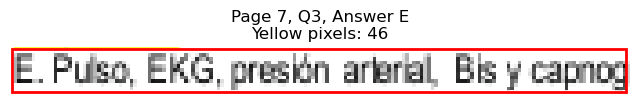


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=127.7, y0=277.7, x1=193.1, y1=289.7
Page 7, Q4, A: Yellow pixels: 485
Page 7, Q4, A: Total non-white pixels: 839
Page 7, Q4, A: Yellow percentage: 57.8%


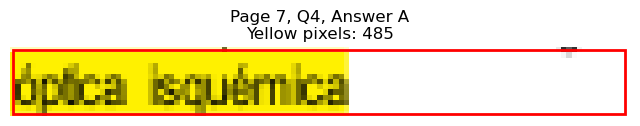

Page 7, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=160.1, y1=301.8
Page 7, Q4, B: Yellow pixels: 102
Page 7, Q4, B: Total non-white pixels: 543
Page 7, Q4, B: Yellow percentage: 18.8%


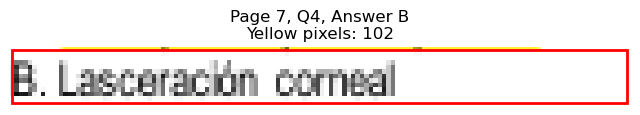

Page 7, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=130.7, y1=314.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 282
Page 7, Q4, C: Yellow percentage: 0.0%


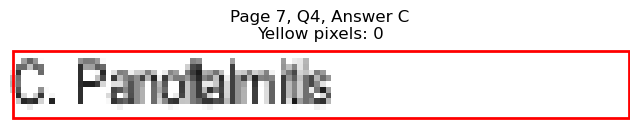

Page 7, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=404.1, y1=289.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 573
Page 7, Q4, D: Yellow percentage: 0.0%


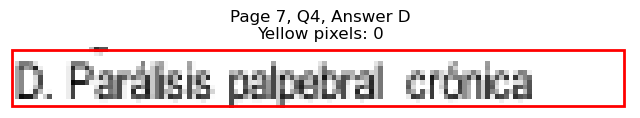

Page 7, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=364.3, y1=301.8
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 207
Page 7, Q4, E: Yellow percentage: 0.0%


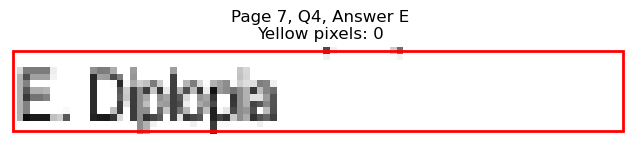


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=338.5, x1=121.8, y1=350.5
Page 7, Q5, A: Yellow pixels: 296
Page 7, Q5, A: Total non-white pixels: 496
Page 7, Q5, A: Yellow percentage: 59.7%


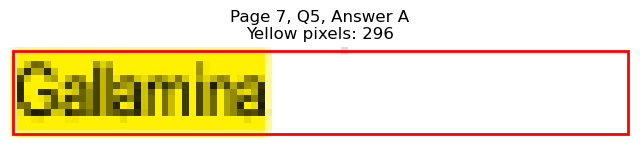

Page 7, Q5 - B: Detected box: x0=71.3, y0=350.5, x1=121.8, y1=362.5
Page 7, Q5, B: Yellow pixels: 36
Page 7, Q5, B: Total non-white pixels: 279
Page 7, Q5, B: Yellow percentage: 12.9%


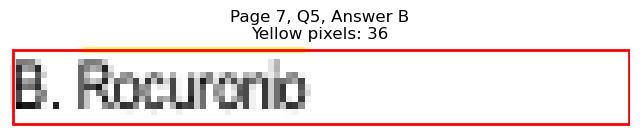

Page 7, Q5 - C: Detected box: x0=71.3, y0=362.5, x1=121.8, y1=374.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 221
Page 7, Q5, C: Yellow percentage: 0.0%


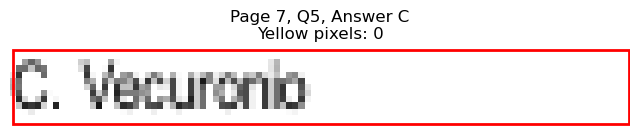

Page 7, Q5 - D: Detected box: x0=322.9, y0=338.5, x1=369.5, y1=350.5
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 218
Page 7, Q5, D: Yellow percentage: 0.0%


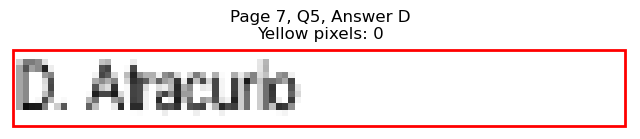

Page 7, Q5 - E: Detected box: x0=322.9, y0=350.5, x1=379.3, y1=362.5
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 267
Page 7, Q5, E: Yellow percentage: 0.0%


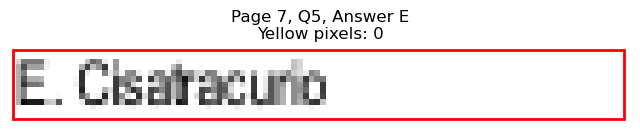


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=398.5, x1=116.5, y1=410.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 169
Page 7, Q6, A: Yellow percentage: 0.0%


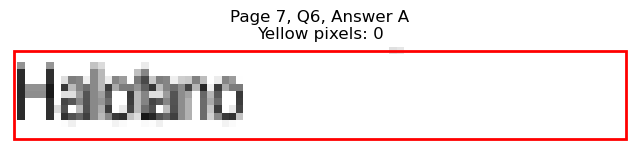

Page 7, Q6 - B: Detected box: x0=71.3, y0=410.5, x1=123.3, y1=422.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 261
Page 7, Q6, B: Yellow percentage: 0.0%


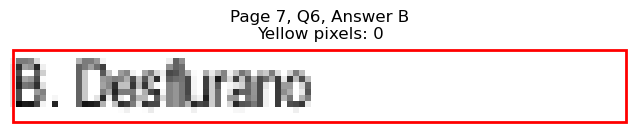

Page 7, Q6 - C: Detected box: x0=71.3, y0=422.5, x1=128.5, y1=434.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 262
Page 7, Q6, C: Yellow percentage: 0.0%


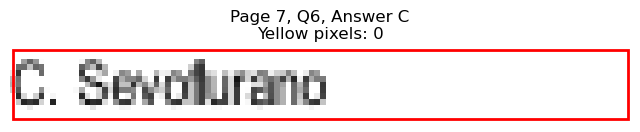

Page 7, Q6 - D: Detected box: x0=322.9, y0=398.5, x1=371.9, y1=410.6
Page 7, Q6, D: Yellow pixels: 416
Page 7, Q6, D: Total non-white pixels: 626
Page 7, Q6, D: Yellow percentage: 66.5%


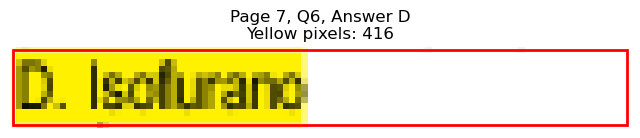

Page 7, Q6 - E: Detected box: x0=322.9, y0=410.5, x1=350.8, y1=422.6
Page 7, Q6, E: Yellow pixels: 45
Page 7, Q6, E: Total non-white pixels: 164
Page 7, Q6, E: Yellow percentage: 27.4%


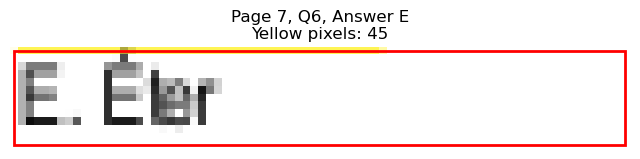


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=458.6, x1=138.3, y1=470.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 266
Page 7, Q7, A: Yellow percentage: 0.0%


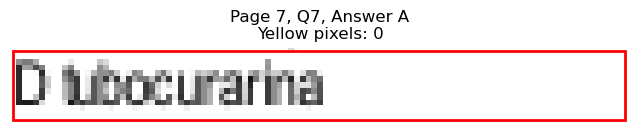

Page 7, Q7 - B: Detected box: x0=71.3, y0=470.6, x1=117.2, y1=482.6
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 221
Page 7, Q7, B: Yellow percentage: 0.0%


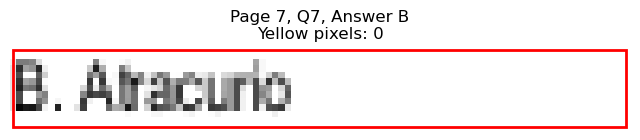

Page 7, Q7 - C: Detected box: x0=71.3, y0=483.4, x1=121.7, y1=495.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 219
Page 7, Q7, C: Yellow percentage: 0.0%


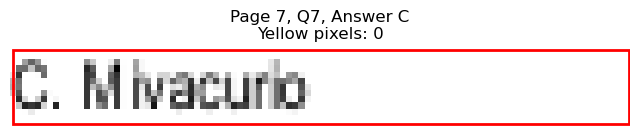

Page 7, Q7 - D: Detected box: x0=322.9, y0=458.6, x1=374.1, y1=470.6
Page 7, Q7, D: Yellow pixels: 392
Page 7, Q7, D: Total non-white pixels: 650
Page 7, Q7, D: Yellow percentage: 60.3%


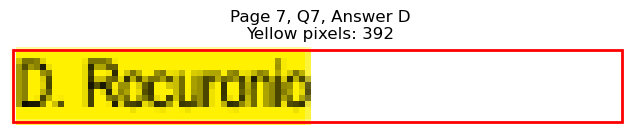

Page 7, Q7 - E: Detected box: x0=322.9, y0=470.6, x1=385.3, y1=482.6
Page 7, Q7, E: Yellow pixels: 49
Page 7, Q7, E: Total non-white pixels: 358
Page 7, Q7, E: Yellow percentage: 13.7%


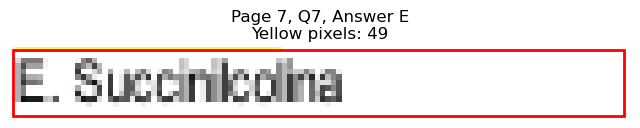


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=543.4, x1=157.0, y1=555.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 379
Page 7, Q8, A: Yellow percentage: 0.0%


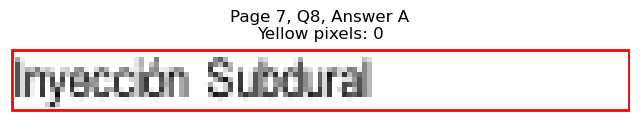

Page 7, Q8 - B: Detected box: x0=71.3, y0=555.4, x1=212.7, y1=567.5
Page 7, Q8, B: Yellow pixels: 1241
Page 7, Q8, B: Total non-white pixels: 1820
Page 7, Q8, B: Yellow percentage: 68.2%


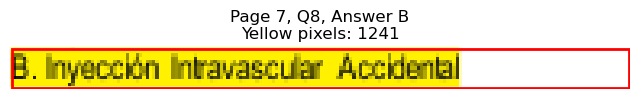

Page 7, Q8 - C: Detected box: x0=71.3, y0=567.5, x1=153.2, y1=579.5
Page 7, Q8, C: Yellow pixels: 132
Page 7, Q8, C: Total non-white pixels: 525
Page 7, Q8, C: Yellow percentage: 25.1%


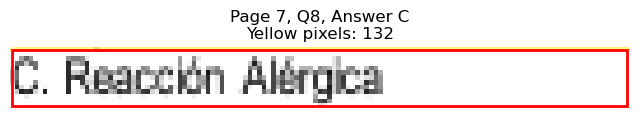

Page 7, Q8 - D: Detected box: x0=382.2, y0=543.4, x1=489.5, y1=555.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 526
Page 7, Q8, D: Yellow percentage: 0.0%


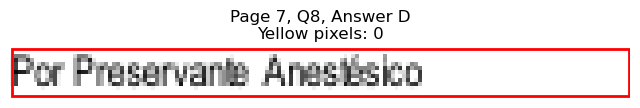

Page 7, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=413.0, y1=567.5
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 430
Page 7, Q8, E: Yellow percentage: 0.0%


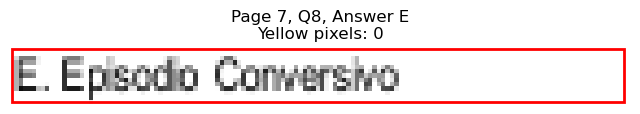


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=603.5, x1=106.0, y1=615.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 109
Page 7, Q9, A: Yellow percentage: 0.0%


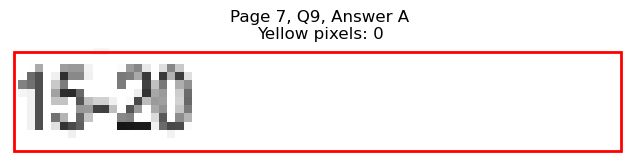

Page 7, Q9 - B: Detected box: x0=71.3, y0=615.5, x1=107.5, y1=627.5
Page 7, Q9, B: Yellow pixels: 333
Page 7, Q9, B: Total non-white pixels: 455
Page 7, Q9, B: Yellow percentage: 73.2%


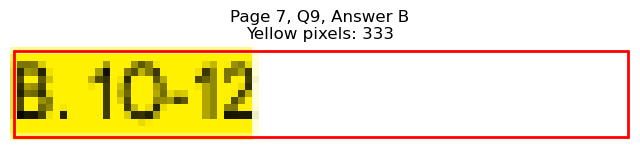

Page 7, Q9 - C: Detected box: x0=71.3, y0=627.5, x1=106.0, y1=639.6
Page 7, Q9, C: Yellow pixels: 34
Page 7, Q9, C: Total non-white pixels: 183
Page 7, Q9, C: Yellow percentage: 18.6%


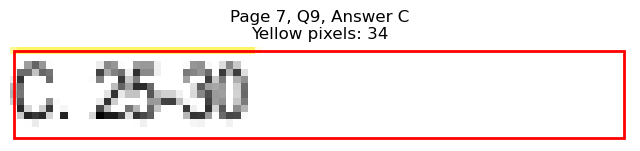

Page 7, Q9 - D: Detected box: x0=322.9, y0=603.5, x1=350.8, y1=615.5
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 121
Page 7, Q9, D: Yellow percentage: 0.0%


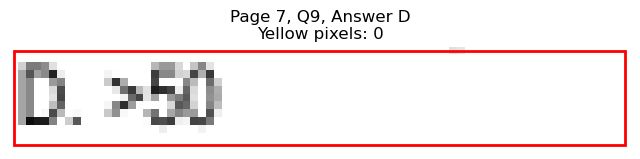

Page 7, Q9 - E: Detected box: x0=322.9, y0=615.5, x1=354.5, y1=627.5
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 131
Page 7, Q9, E: Yellow percentage: 0.0%


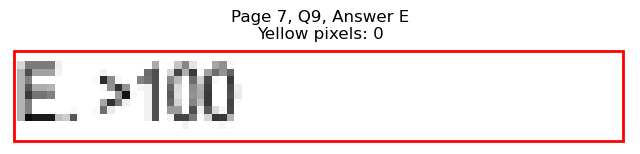


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=676.3, x1=136.0, y1=688.3
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 457
Page 7, Q10, A: Yellow percentage: 0.0%


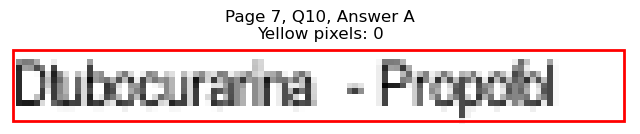

Page 7, Q10 - B: Detected box: x0=71.3, y0=688.3, x1=158.5, y1=700.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 424
Page 7, Q10, B: Yellow percentage: 0.0%


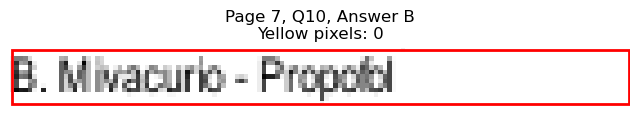

Page 7, Q10 - C: Detected box: x0=71.3, y0=700.3, x1=166.1, y1=712.3
Page 7, Q10, C: Yellow pixels: 773
Page 7, Q10, C: Total non-white pixels: 1209
Page 7, Q10, C: Yellow percentage: 63.9%


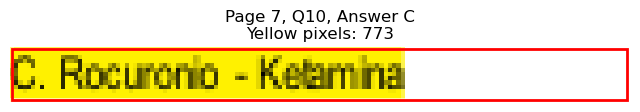

Page 7, Q10 - D: Detected box: x0=322.9, y0=676.3, x1=413.1, y1=688.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 439
Page 7, Q10, D: Yellow percentage: 0.0%


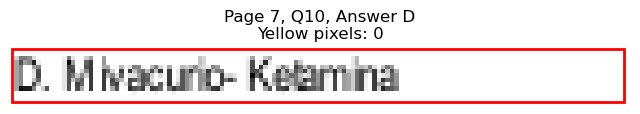

Page 7, Q10 - E: Detected box: x0=322.9, y0=688.3, x1=388.4, y1=700.3
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 491
Page 7, Q10, E: Yellow percentage: 0.0%


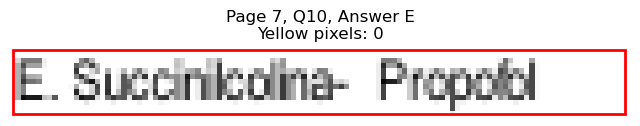


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=82.6, y0=736.4, x1=180.3, y1=748.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 456
Page 7, Q11, A: Yellow percentage: 0.0%


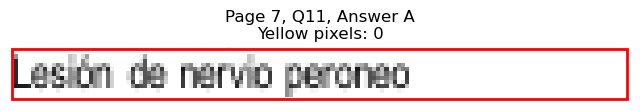

Page 7, Q11 - B: Detected box: x0=71.3, y0=748.4, x1=175.8, y1=760.4
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 511
Page 7, Q11, B: Yellow percentage: 0.0%


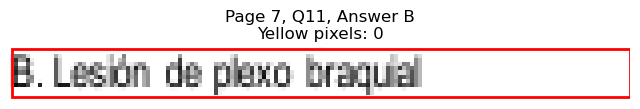

Page 7, Q11 - C: Detected box: x0=71.3, y0=760.4, x1=175.0, y1=772.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 473
Page 7, Q11, C: Yellow percentage: 0.0%


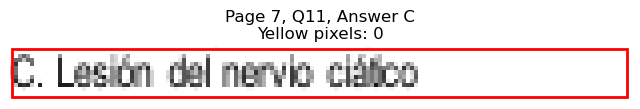

Page 7, Q11 - D: Detected box: x0=322.9, y0=736.4, x1=375.6, y1=748.4
Page 7, Q11, D: Yellow pixels: 703
Page 7, Q11, D: Total non-white pixels: 1040
Page 7, Q11, D: Yellow percentage: 67.6%


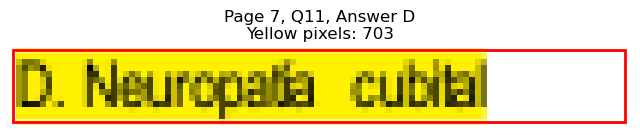

Page 7, Q11 - E: Detected box: x0=322.9, y0=748.4, x1=430.3, y1=760.4
Page 7, Q11, E: Yellow pixels: 78
Page 7, Q11, E: Total non-white pixels: 569
Page 7, Q11, E: Yellow percentage: 13.7%


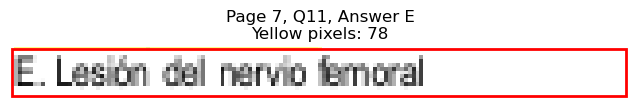


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=133.0, y1=108.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 256
Page 8, Q1, A: Yellow percentage: 0.0%


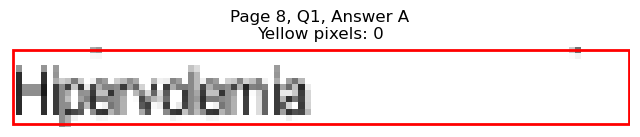

Page 8, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=154.0, y1=121.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 395
Page 8, Q1, B: Yellow percentage: 0.0%


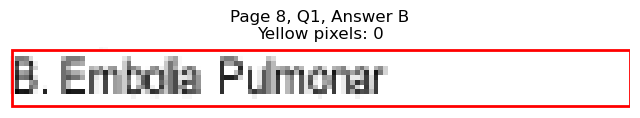

Page 8, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=166.1, y1=133.6
Page 8, Q1, C: Yellow pixels: 833
Page 8, Q1, C: Total non-white pixels: 1209
Page 8, Q1, C: Yellow percentage: 68.9%


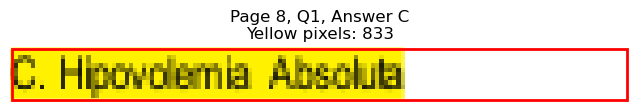

Page 8, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=374.8, y1=108.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 461
Page 8, Q1, D: Yellow percentage: 0.0%


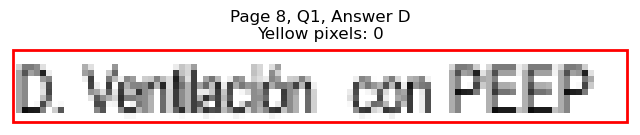

Page 8, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=471.6, y1=121.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 736
Page 8, Q1, E: Yellow percentage: 0.0%


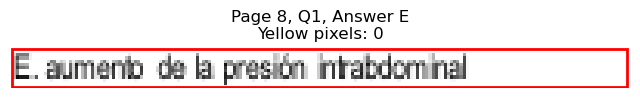


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=121.8, y1=169.6
Page 8, Q2, A: Yellow pixels: 277
Page 8, Q2, A: Total non-white pixels: 496
Page 8, Q2, A: Yellow percentage: 55.8%


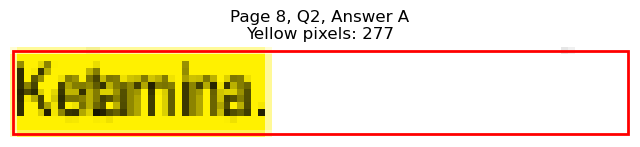

Page 8, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=116.5, y1=181.6
Page 8, Q2, B: Yellow pixels: 36
Page 8, Q2, B: Total non-white pixels: 247
Page 8, Q2, B: Yellow percentage: 14.6%


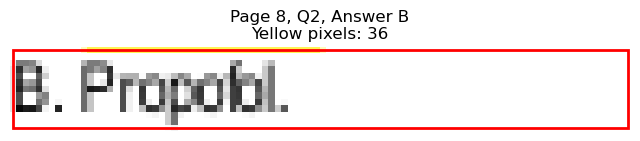

Page 8, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=150.3, y1=193.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 388
Page 8, Q2, C: Yellow percentage: 0.0%


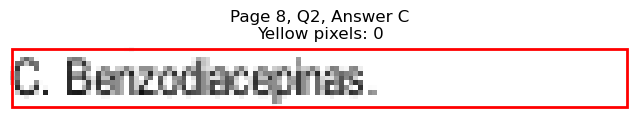

Page 8, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=387.6, y1=169.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 340
Page 8, Q2, D: Yellow percentage: 0.0%


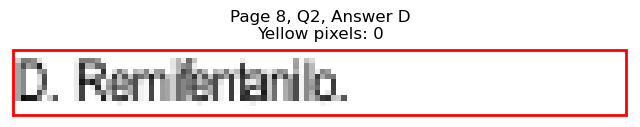

Page 8, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=374.9, y1=181.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 258
Page 8, Q2, E: Yellow percentage: 0.0%


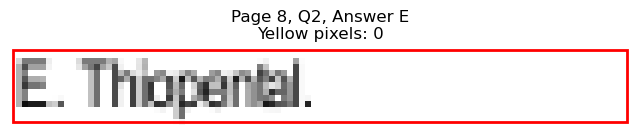


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=163.1, y1=229.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 386
Page 8, Q3, A: Yellow percentage: 0.0%


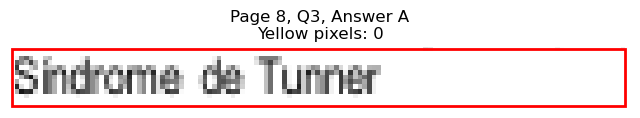

Page 8, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=182.6, y1=241.7
Page 8, Q3, B: Yellow pixels: 881
Page 8, Q3, B: Total non-white pixels: 1430
Page 8, Q3, B: Yellow percentage: 61.6%


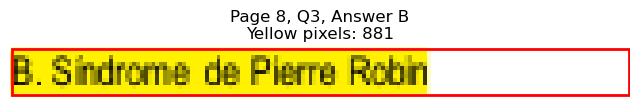

Page 8, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=174.3, y1=253.7
Page 8, Q3, C: Yellow pixels: 109
Page 8, Q3, C: Total non-white pixels: 608
Page 8, Q3, C: Yellow percentage: 17.9%


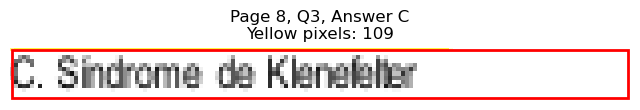

Page 8, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=390.6, y1=229.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 350
Page 8, Q3, D: Yellow percentage: 0.0%


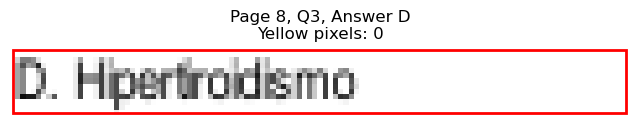

Page 8, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=407.1, y1=241.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 387
Page 8, Q3, E: Yellow percentage: 0.0%


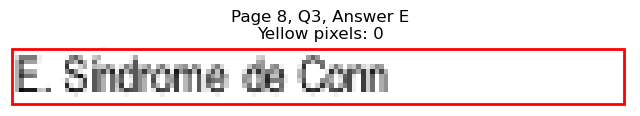


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=71.3, y0=289.7, x1=79.7, y1=301.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 61
Page 8, Q4, A: Yellow percentage: 0.0%


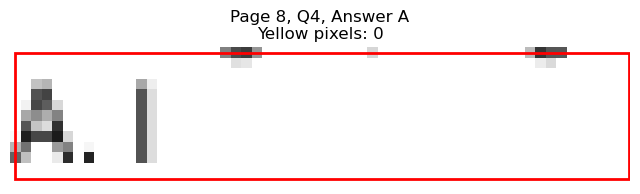

Page 8, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=91.0, y1=314.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 82
Page 8, Q4, B: Yellow percentage: 0.0%


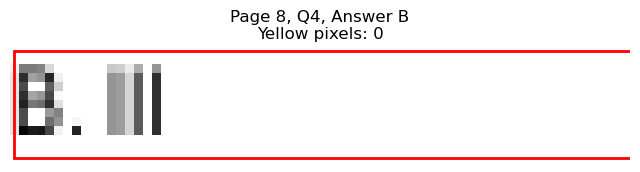

Page 8, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=92.5, y1=326.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 73
Page 8, Q4, C: Yellow percentage: 0.0%


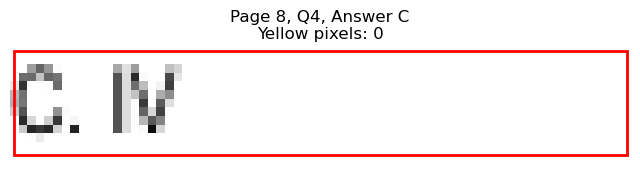

Page 8, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=341.0, y1=301.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 71
Page 8, Q4, D: Yellow percentage: 0.0%


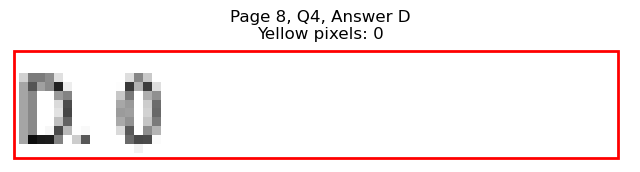

Page 8, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=340.3, y1=314.5
Page 8, Q4, E: Yellow pixels: 138
Page 8, Q4, E: Total non-white pixels: 208
Page 8, Q4, E: Yellow percentage: 66.3%


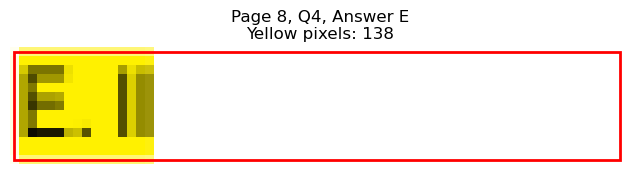


Page 8, Q4 - Selected Answer: E (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=127.0, y1=362.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 214
Page 8, Q5, A: Yellow percentage: 0.0%


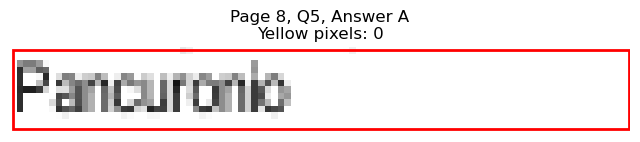

Page 8, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=121.0, y1=374.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 254
Page 8, Q5, B: Yellow percentage: 0.0%


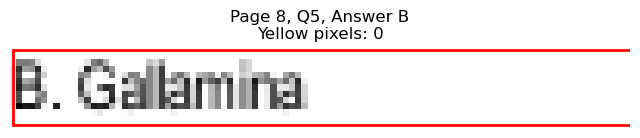

Page 8, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=142.0, y1=386.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 319
Page 8, Q5, C: Yellow percentage: 0.0%


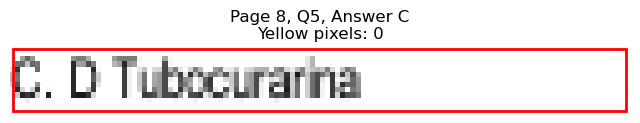

Page 8, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=374.1, y1=362.5
Page 8, Q5, D: Yellow pixels: 440
Page 8, Q5, D: Total non-white pixels: 650
Page 8, Q5, D: Yellow percentage: 67.7%


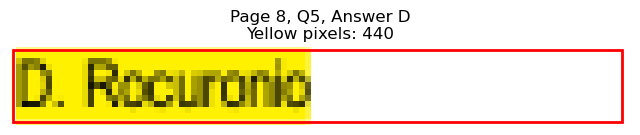

Page 8, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=379.3, y1=374.6
Page 8, Q5, E: Yellow pixels: 49
Page 8, Q5, E: Total non-white pixels: 310
Page 8, Q5, E: Yellow percentage: 15.8%


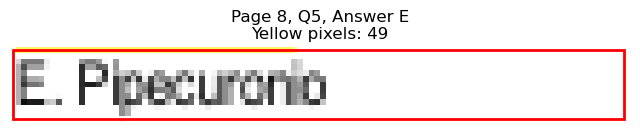


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=115.0, y1=422.6
Page 8, Q6, A: Yellow pixels: 220
Page 8, Q6, A: Total non-white pixels: 405
Page 8, Q6, A: Yellow percentage: 54.3%


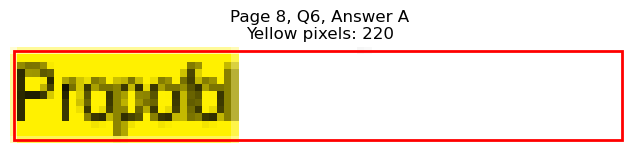

Page 8, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=118.7, y1=434.6
Page 8, Q6, B: Yellow pixels: 30
Page 8, Q6, B: Total non-white pixels: 262
Page 8, Q6, B: Yellow percentage: 11.5%


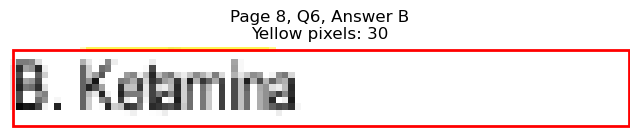

Page 8, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=109.0, y1=446.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 157
Page 8, Q6, C: Yellow percentage: 0.0%


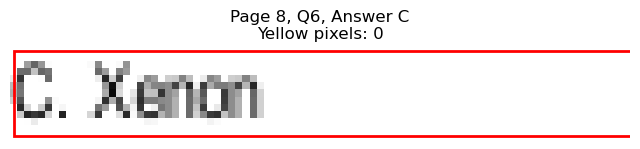

Page 8, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=366.6, y1=422.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 211
Page 8, Q6, D: Yellow percentage: 0.0%


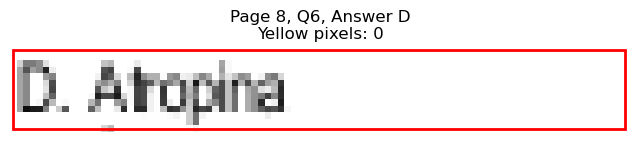

Page 8, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=386.0, y1=434.6
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 315
Page 8, Q6, E: Yellow percentage: 0.0%


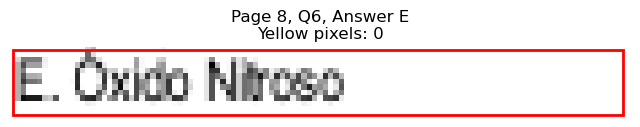


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=123.2, y0=470.6, x1=208.8, y1=482.6
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 434
Page 8, Q7, A: Yellow percentage: 0.0%


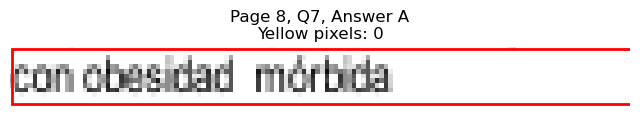

Page 8, Q7 - B: Detected box: x0=71.3, y0=483.4, x1=120.2, y1=495.4
Page 8, Q7, B: Yellow pixels: 756
Page 8, Q7, B: Total non-white pixels: 1053
Page 8, Q7, B: Yellow percentage: 71.8%


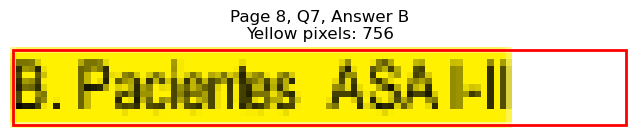

Page 8, Q7 - C: Detected box: x0=117.2, y0=495.4, x1=204.3, y1=507.4
Page 8, Q7, C: Yellow pixels: 34
Page 8, Q7, C: Total non-white pixels: 708
Page 8, Q7, C: Yellow percentage: 4.8%


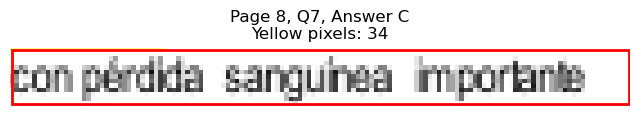

Page 8, Q7 - D: Detected box: x0=322.9, y0=470.6, x1=402.6, y1=482.6
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 386
Page 8, Q7, D: Yellow percentage: 0.0%


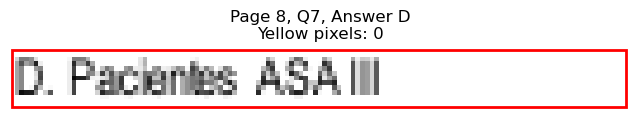

Page 8, Q7 - E: Detected box: x0=374.0, y0=483.4, x1=506.9, y1=495.4
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 633
Page 8, Q7, E: Yellow percentage: 0.0%


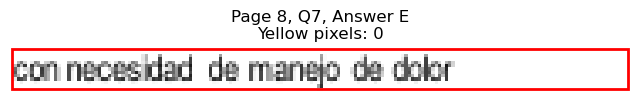


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=71.3, y0=543.4, x1=79.7, y1=555.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 65
Page 8, Q8, A: Yellow percentage: 0.0%


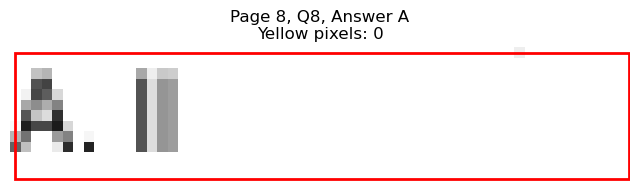

Page 8, Q8 - B: Detected box: x0=71.3, y0=555.4, x1=86.5, y1=567.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 58
Page 8, Q8, B: Yellow percentage: 0.0%


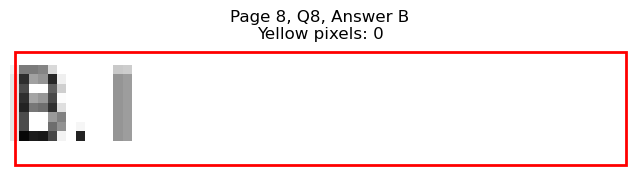

Page 8, Q8 - C: Detected box: x0=71.3, y0=314.5, x1=92.5, y1=326.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 73
Page 8, Q8, C: Yellow percentage: 0.0%


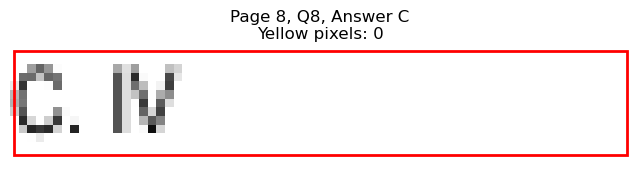

Page 8, Q8 - D: Detected box: x0=322.9, y0=543.4, x1=341.8, y1=555.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 67
Page 8, Q8, D: Yellow percentage: 0.0%


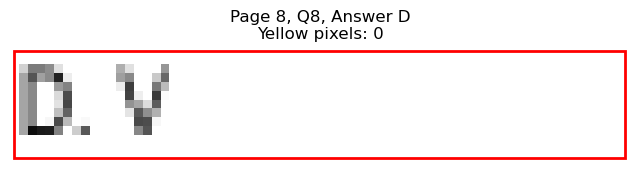

Page 8, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=342.6, y1=567.5
Page 8, Q8, E: Yellow pixels: 148
Page 8, Q8, E: Total non-white pixels: 247
Page 8, Q8, E: Yellow percentage: 59.9%


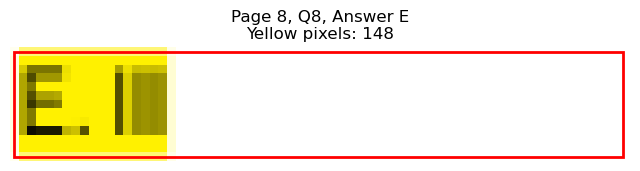


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=615.5, x1=112.8, y1=627.5
Page 8, Q9, A: Yellow pixels: 217
Page 8, Q9, A: Total non-white pixels: 377
Page 8, Q9, A: Yellow percentage: 57.6%


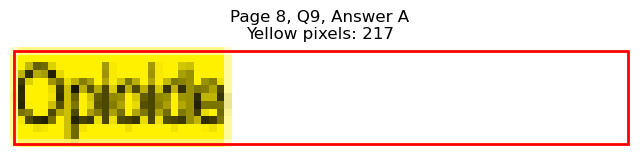

Page 8, Q9 - B: Detected box: x0=71.3, y0=627.5, x1=145.0, y1=639.6
Page 8, Q9, B: Yellow pixels: 27
Page 8, Q9, B: Total non-white pixels: 390
Page 8, Q9, B: Yellow percentage: 6.9%


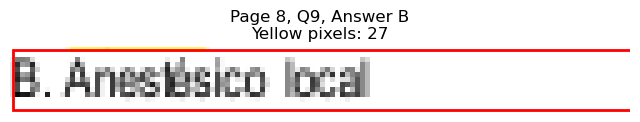

Page 8, Q9 - C: Detected box: x0=71.3, y0=639.5, x1=206.5, y1=651.6
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 631
Page 8, Q9, C: Yellow percentage: 0.0%


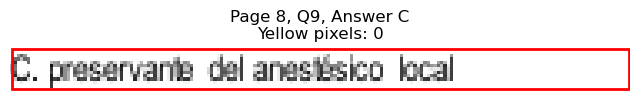

Page 8, Q9 - D: Detected box: x0=322.9, y0=615.5, x1=392.1, y1=627.5
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 354
Page 8, Q9, D: Yellow percentage: 0.0%


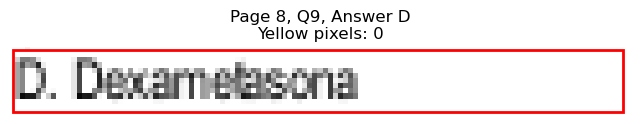

Page 8, Q9 - E: Detected box: x0=322.9, y0=627.5, x1=379.3, y1=639.6
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 271
Page 8, Q9, E: Yellow percentage: 0.0%


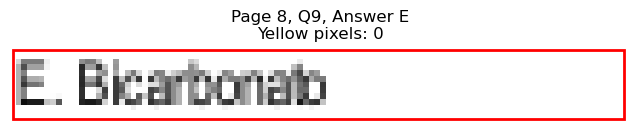


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=176.4, y0=700.3, x1=250.1, y1=712.3
Page 8, Q10, A: Yellow pixels: 564
Page 8, Q10, A: Total non-white pixels: 936
Page 8, Q10, A: Yellow percentage: 60.3%


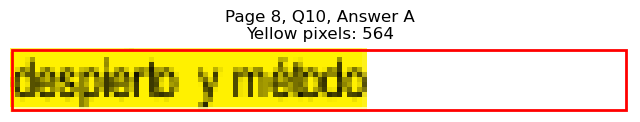

Page 8, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=148.1, y1=736.4
Page 8, Q10, B: Yellow pixels: 1
Page 8, Q10, B: Total non-white pixels: 451
Page 8, Q10, B: Yellow percentage: 0.2%


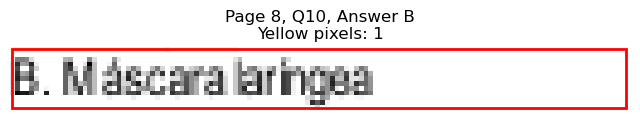

Page 8, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=134.6, y1=748.4
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 529
Page 8, Q10, C: Yellow percentage: 0.0%


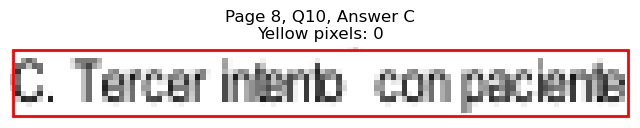

Page 8, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=373.3, y1=712.3
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 459
Page 8, Q10, D: Yellow percentage: 0.0%


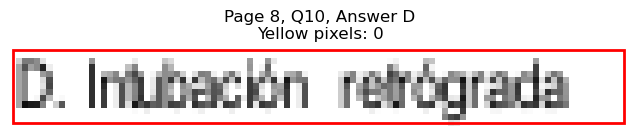

Page 8, Q10 - E: Detected box: x0=374.0, y0=712.3, x1=477.0, y1=724.4
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 515
Page 8, Q10, E: Yellow percentage: 0.0%


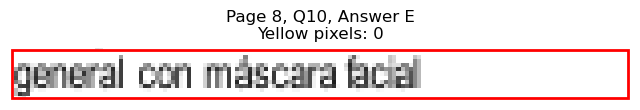


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=115.0, y1=108.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 157
Page 9, Q1, A: Yellow percentage: 0.0%


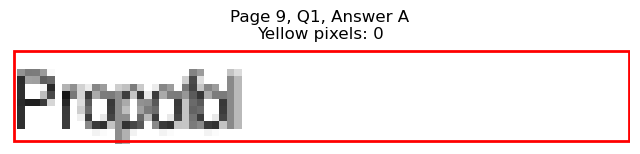

Page 9, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=133.0, y1=121.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 325
Page 9, Q1, B: Yellow percentage: 0.0%


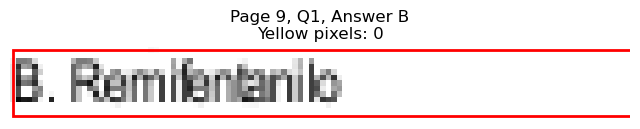

Page 9, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=121.8, y1=133.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 250
Page 9, Q1, C: Yellow percentage: 0.0%


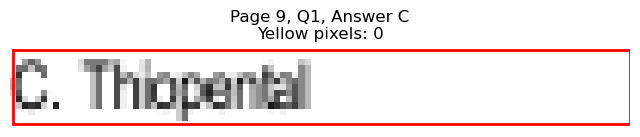

Page 9, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=371.1, y1=108.8
Page 9, Q1, D: Yellow pixels: 359
Page 9, Q1, D: Total non-white pixels: 611
Page 9, Q1, D: Yellow percentage: 58.8%


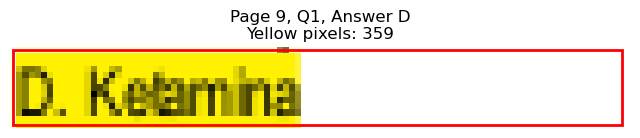

Page 9, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=371.1, y1=121.6
Page 9, Q1, E: Yellow pixels: 46
Page 9, Q1, E: Total non-white pixels: 282
Page 9, Q1, E: Yellow percentage: 16.3%


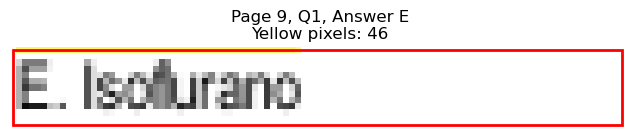


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=151.7, y1=193.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 335
Page 9, Q2, A: Yellow percentage: 0.0%


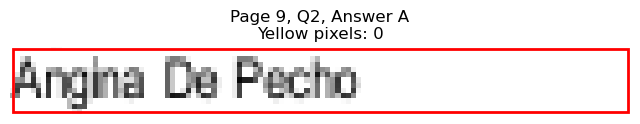

Page 9, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=128.5, y1=205.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 484
Page 9, Q2, B: Yellow percentage: 0.0%


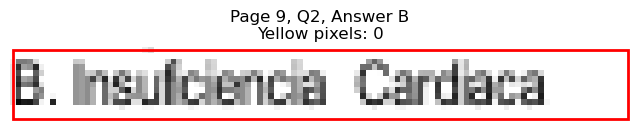

Page 9, Q2 - C: Detected box: x0=130.7, y0=205.6, x1=207.4, y1=217.7
Page 9, Q2, C: Yellow pixels: 604
Page 9, Q2, C: Total non-white pixels: 975
Page 9, Q2, C: Yellow percentage: 61.9%


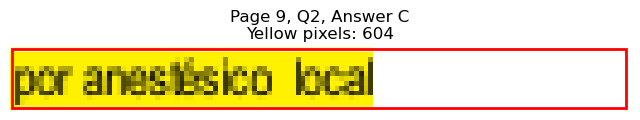

Page 9, Q2 - D: Detected box: x0=370.2, y0=181.6, x1=434.1, y1=193.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 343
Page 9, Q2, D: Yellow percentage: 0.0%


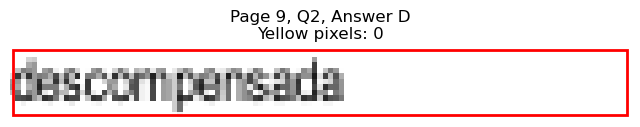

Page 9, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=411.6, y1=205.6
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 414
Page 9, Q2, E: Yellow percentage: 0.0%


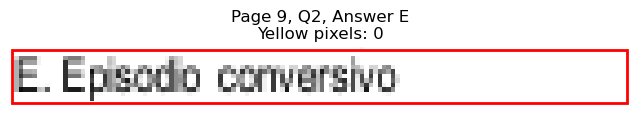


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=100.8, y1=253.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 78
Page 9, Q3, A: Yellow percentage: 0.0%


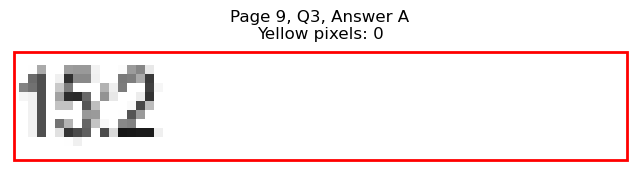

Page 9, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=95.5, y1=265.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 94
Page 9, Q3, B: Yellow percentage: 0.0%


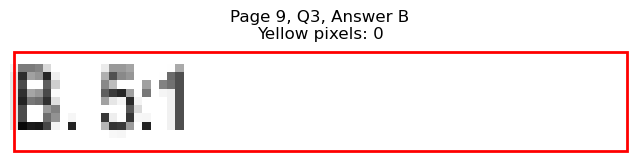

Page 9, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=100.7, y1=277.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 98
Page 9, Q3, C: Yellow percentage: 0.0%


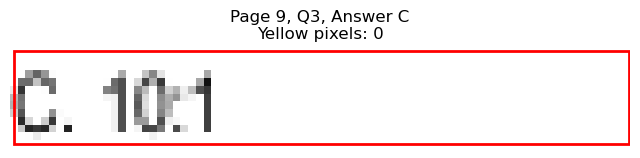

Page 9, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=352.3, y1=253.7
Page 9, Q3, D: Yellow pixels: 226
Page 9, Q3, D: Total non-white pixels: 364
Page 9, Q3, D: Yellow percentage: 62.1%


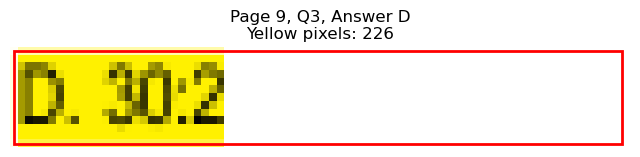

Page 9, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=351.5, y1=265.7
Page 9, Q3, E: Yellow pixels: 27
Page 9, Q3, E: Total non-white pixels: 152
Page 9, Q3, E: Yellow percentage: 17.8%


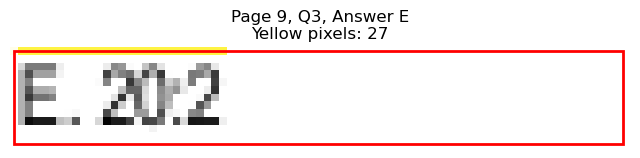


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=122.5, y1=314.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 191
Page 9, Q4, A: Yellow percentage: 0.0%


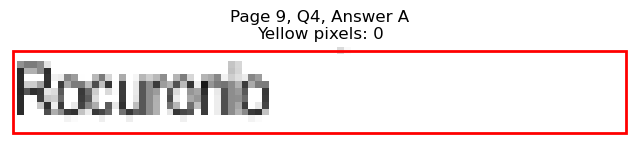

Page 9, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=121.0, y1=326.5
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 234
Page 9, Q4, B: Yellow percentage: 0.0%


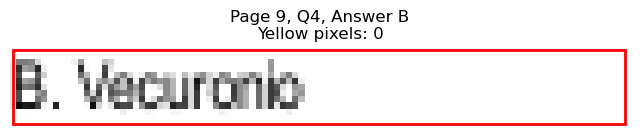

Page 9, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=134.5, y1=338.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 301
Page 9, Q4, C: Yellow percentage: 0.0%


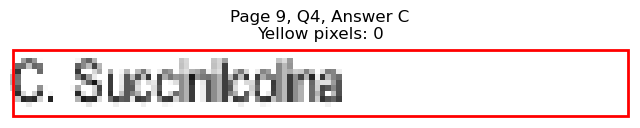

Page 9, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=369.5, y1=314.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 218
Page 9, Q4, D: Yellow percentage: 0.0%


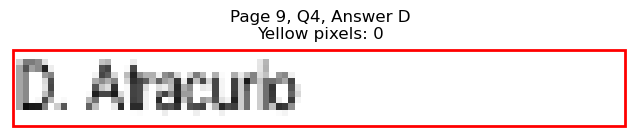

Page 9, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=371.1, y1=326.5
Page 9, Q4, E: Yellow pixels: 403
Page 9, Q4, E: Total non-white pixels: 611
Page 9, Q4, E: Yellow percentage: 66.0%


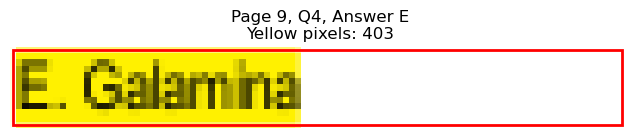


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=121.8, y1=374.6
Page 9, Q5, A: Yellow pixels: 322
Page 9, Q5, A: Total non-white pixels: 494
Page 9, Q5, A: Yellow percentage: 65.2%


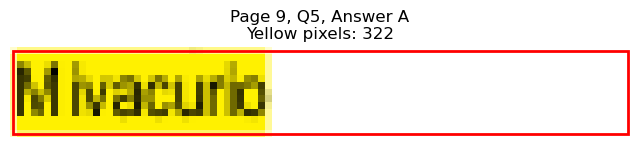

Page 9, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=117.2, y1=386.6
Page 9, Q5, B: Yellow pixels: 36
Page 9, Q5, B: Total non-white pixels: 259
Page 9, Q5, B: Yellow percentage: 13.9%


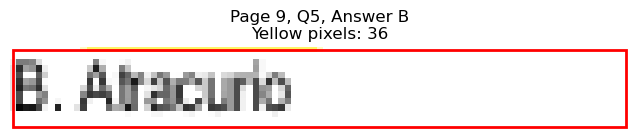

Page 9, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=128.5, y1=398.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 260
Page 9, Q5, C: Yellow percentage: 0.0%


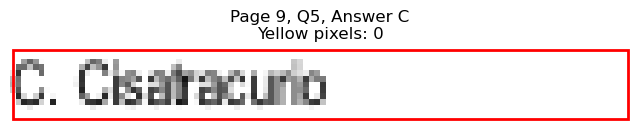

Page 9, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=394.3, y1=374.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 324
Page 9, Q5, D: Yellow percentage: 0.0%


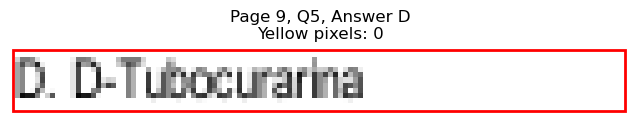

Page 9, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=377.8, y1=386.6
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 248
Page 9, Q5, E: Yellow percentage: 0.0%


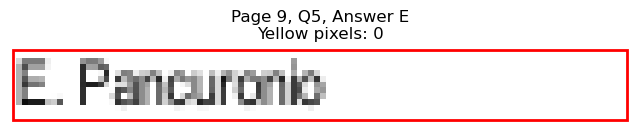


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=106.0, y1=434.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 120
Page 9, Q6, A: Yellow percentage: 0.0%


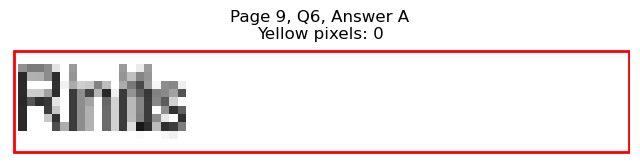

Page 9, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=127.0, y1=446.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 275
Page 9, Q6, B: Yellow percentage: 0.0%


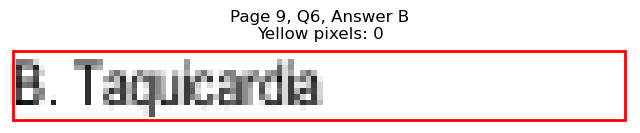

Page 9, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=113.5, y1=458.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 198
Page 9, Q6, C: Yellow percentage: 0.0%


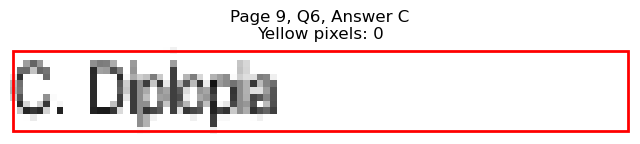

Page 9, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=380.9, y1=434.6
Page 9, Q6, D: Yellow pixels: 644
Page 9, Q6, D: Total non-white pixels: 1042
Page 9, Q6, D: Yellow percentage: 61.8%


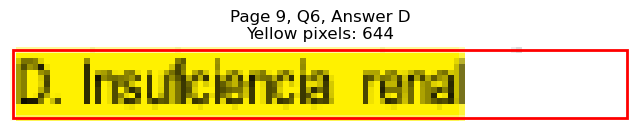

Page 9, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=368.8, y1=446.6
Page 9, Q6, E: Yellow pixels: 79
Page 9, Q6, E: Total non-white pixels: 295
Page 9, Q6, E: Yellow percentage: 26.8%


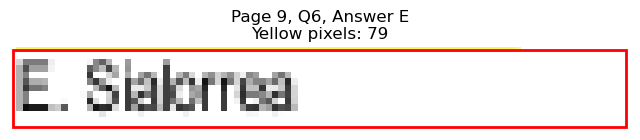


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=98.5, y1=507.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 78
Page 9, Q7, A: Yellow percentage: 0.0%


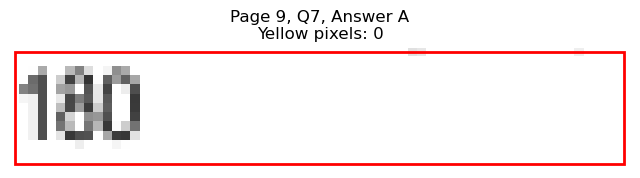

Page 9, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=97.8, y1=519.4
Page 9, Q7, B: Yellow pixels: 228
Page 9, Q7, B: Total non-white pixels: 325
Page 9, Q7, B: Yellow percentage: 70.2%


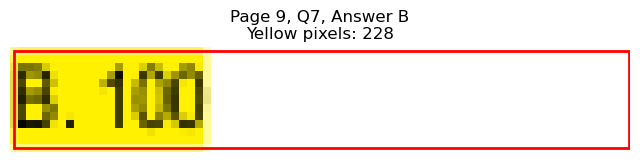

Page 9, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=98.5, y1=531.4
Page 9, Q7, C: Yellow pixels: 23
Page 9, Q7, C: Total non-white pixels: 127
Page 9, Q7, C: Yellow percentage: 18.1%


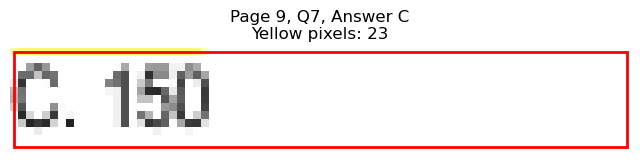

Page 9, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=350.0, y1=507.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 123
Page 9, Q7, D: Yellow percentage: 0.0%


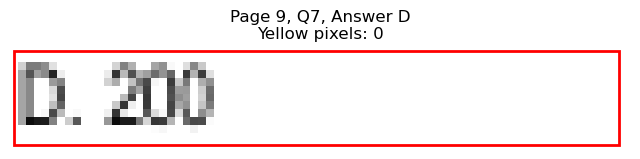

Page 9, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=349.3, y1=519.4
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 116
Page 9, Q7, E: Yellow percentage: 0.0%


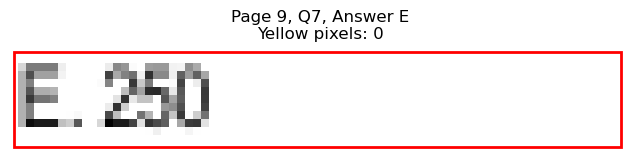


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=123.2, y1=567.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 217
Page 9, Q8, A: Yellow percentage: 0.0%


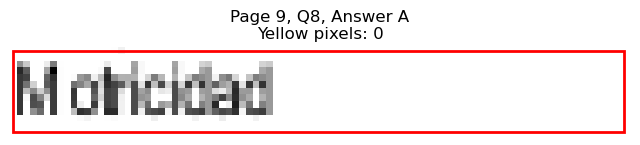

Page 9, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=146.5, y1=579.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 358
Page 9, Q8, B: Yellow percentage: 0.0%


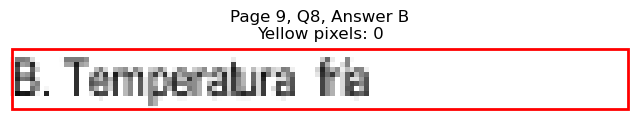

Page 9, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=159.2, y1=591.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 427
Page 9, Q8, C: Yellow percentage: 0.0%


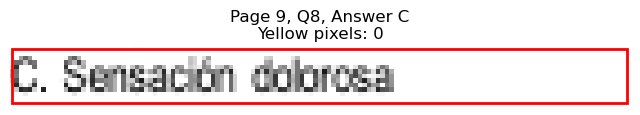

Page 9, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=383.1, y1=567.5
Page 9, Q8, D: Yellow pixels: 502
Page 9, Q8, D: Total non-white pixels: 768
Page 9, Q8, D: Yellow percentage: 65.4%


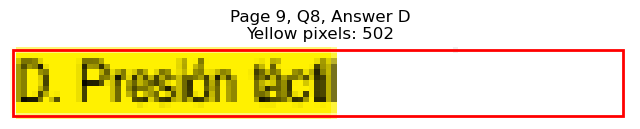

Page 9, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=414.6, y1=579.5
Page 9, Q8, E: Yellow pixels: 57
Page 9, Q8, E: Total non-white pixels: 510
Page 9, Q8, E: Yellow percentage: 11.2%


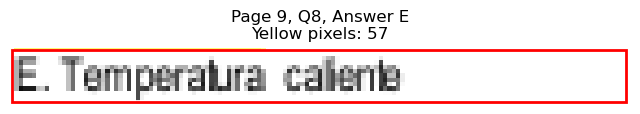


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=131.4, y0=615.5, x1=200.6, y1=627.5
Page 9, Q9, A: Yellow pixels: 584
Page 9, Q9, A: Total non-white pixels: 885
Page 9, Q9, A: Yellow percentage: 66.0%


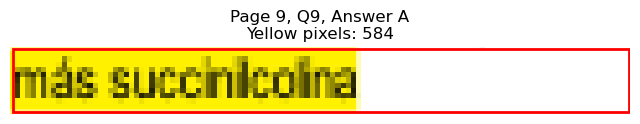

Page 9, Q9 - B: Detected box: x0=130.7, y0=627.5, x1=189.3, y1=639.6
Page 9, Q9, B: Yellow pixels: 68
Page 9, Q9, B: Total non-white pixels: 360
Page 9, Q9, B: Yellow percentage: 18.9%


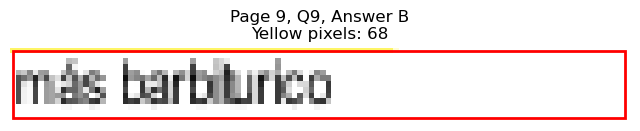

Page 9, Q9 - C: Detected box: x0=71.3, y0=639.5, x1=128.5, y1=651.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 530
Page 9, Q9, C: Yellow percentage: 0.0%


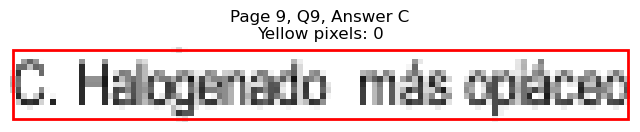

Page 9, Q9 - D: Detected box: x0=322.9, y0=96.8, x1=371.1, y1=108.8
Page 9, Q9, D: Yellow pixels: 359
Page 9, Q9, D: Total non-white pixels: 611
Page 9, Q9, D: Yellow percentage: 58.8%


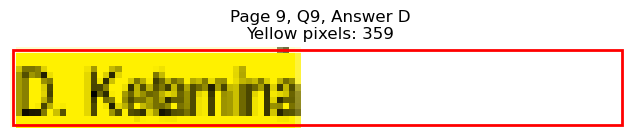

Page 9, Q9 - E: Detected box: x0=322.9, y0=627.5, x1=428.0, y1=639.6
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 512
Page 9, Q9, E: Yellow percentage: 0.0%


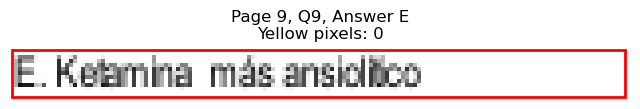


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=127.0, y1=700.3
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 234
Page 9, Q10, A: Yellow percentage: 0.0%


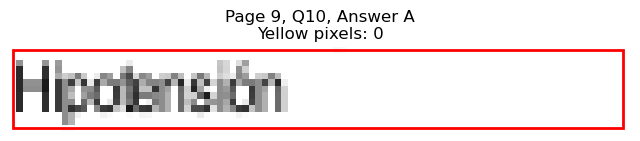

Page 9, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=123.2, y1=712.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 262
Page 9, Q10, B: Yellow percentage: 0.0%


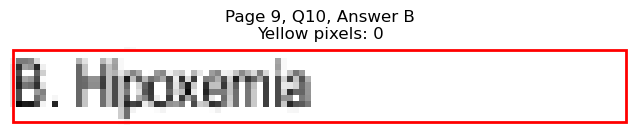

Page 9, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=112.0, y1=724.4
Page 9, Q10, C: Yellow pixels: 307
Page 9, Q10, C: Total non-white pixels: 507
Page 9, Q10, C: Yellow percentage: 60.6%


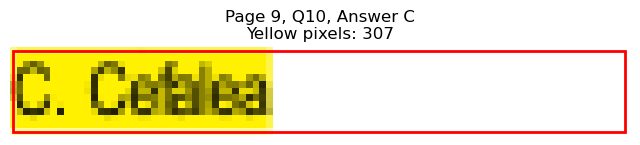

Page 9, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=380.0, y1=700.3
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 289
Page 9, Q10, D: Yellow percentage: 0.0%


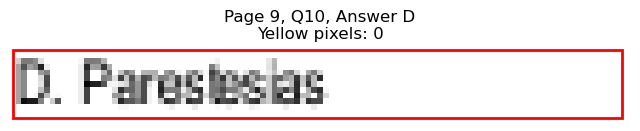

Page 9, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=384.5, y1=712.3
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 278
Page 9, Q10, E: Yellow percentage: 0.0%


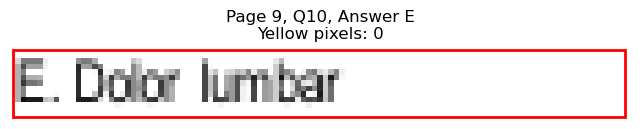


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=120.3, y1=760.4
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 198
Page 9, Q11, A: Yellow percentage: 0.0%


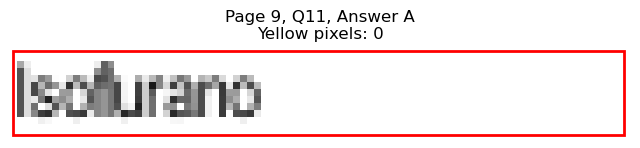

Page 9, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=127.8, y1=772.4
Page 9, Q11, B: Yellow pixels: 489
Page 9, Q11, B: Total non-white pixels: 715
Page 9, Q11, B: Yellow percentage: 68.4%


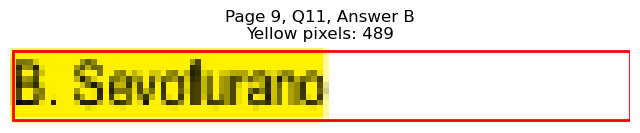

Page 9, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=116.5, y1=784.4
Page 9, Q11, C: Yellow pixels: 53
Page 9, Q11, C: Total non-white pixels: 252
Page 9, Q11, C: Yellow percentage: 21.0%


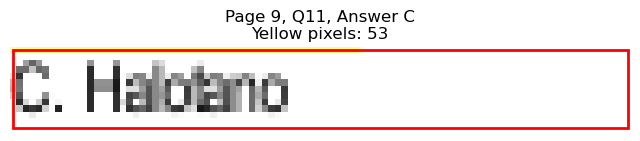

Page 9, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=360.6, y1=760.4
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 164
Page 9, Q11, D: Yellow percentage: 0.0%


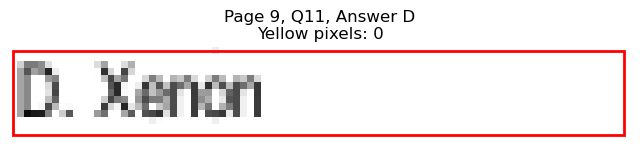

Page 9, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=379.3, y1=772.4
Page 9, Q11, E: Yellow pixels: 0
Page 9, Q11, E: Total non-white pixels: 271
Page 9, Q11, E: Yellow percentage: 0.0%


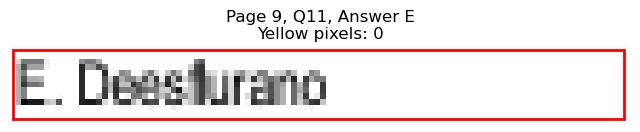


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 5 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=164.6, y1=108.8
Page 10, Q1, A: Yellow pixels: 614
Page 10, Q1, A: Total non-white pixels: 1053
Page 10, Q1, A: Yellow percentage: 58.3%


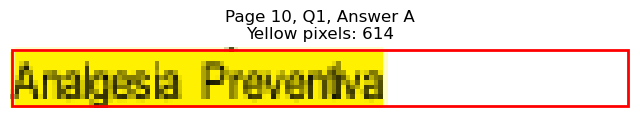

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=118.7, y1=121.6
Page 10, Q1, B: Yellow pixels: 79
Page 10, Q1, B: Total non-white pixels: 318
Page 10, Q1, B: Yellow percentage: 24.8%


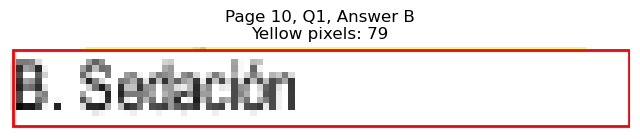

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=171.2, y1=133.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 498
Page 10, Q1, C: Yellow percentage: 0.0%


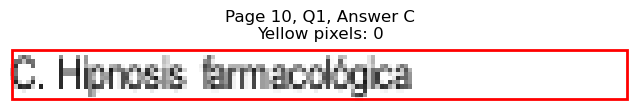

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=418.3, y1=108.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 474
Page 10, Q1, D: Yellow percentage: 0.0%


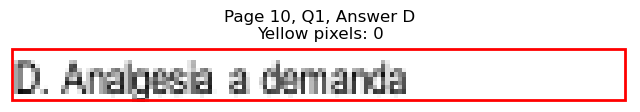

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=398.1, y1=121.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 369
Page 10, Q1, E: Yellow percentage: 0.0%


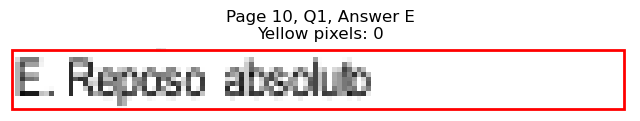


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=136.0, y1=169.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 292
Page 10, Q2, A: Yellow percentage: 0.0%


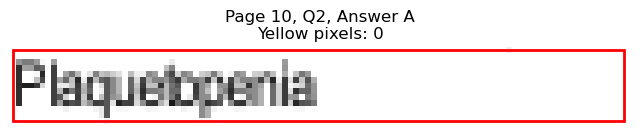

Page 10, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=138.2, y1=181.6
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 334
Page 10, Q2, B: Yellow percentage: 0.0%


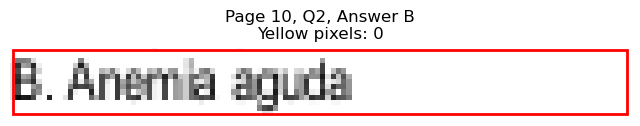

Page 10, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=180.3, y1=193.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 791
Page 10, Q2, C: Yellow percentage: 0.0%


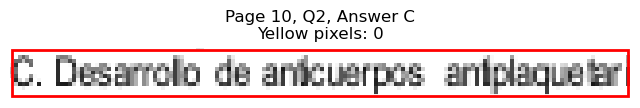

Page 10, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=453.7, y1=169.6
Page 10, Q2, D: Yellow pixels: 1006
Page 10, Q2, D: Total non-white pixels: 1690
Page 10, Q2, D: Yellow percentage: 59.5%


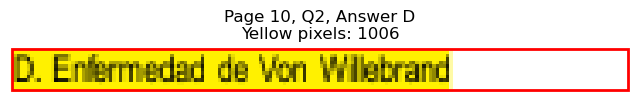

Page 10, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=409.3, y1=181.6
Page 10, Q2, E: Yellow pixels: 128
Page 10, Q2, E: Total non-white pixels: 571
Page 10, Q2, E: Yellow percentage: 22.4%


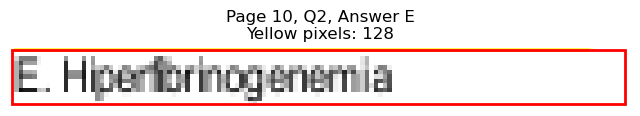


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=122.5, y1=229.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 210
Page 10, Q3, A: Yellow percentage: 0.0%


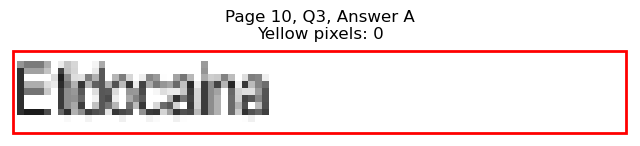

Page 10, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=130.7, y1=241.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 298
Page 10, Q3, B: Yellow percentage: 0.0%


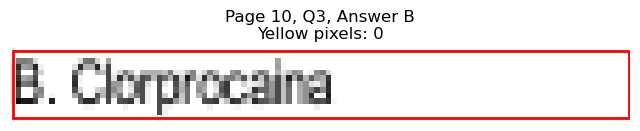

Page 10, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=119.5, y1=253.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 213
Page 10, Q3, C: Yellow percentage: 0.0%


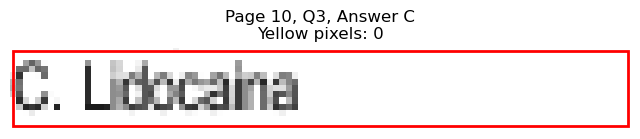

Page 10, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=381.6, y1=229.7
Page 10, Q3, D: Yellow pixels: 429
Page 10, Q3, D: Total non-white pixels: 754
Page 10, Q3, D: Yellow percentage: 56.9%


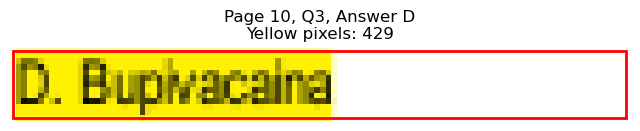

Page 10, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=368.8, y1=241.7
Page 10, Q3, E: Yellow pixels: 56
Page 10, Q3, E: Total non-white pixels: 261
Page 10, Q3, E: Yellow percentage: 21.5%


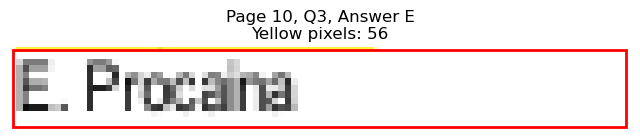


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=124.6, y0=277.7, x1=164.6, y1=289.7
Page 10, Q4, A: Yellow pixels: 296
Page 10, Q4, A: Total non-white pixels: 509
Page 10, Q4, A: Yellow percentage: 58.2%


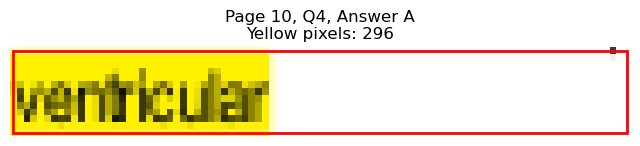

Page 10, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=148.7, y1=301.8
Page 10, Q4, B: Yellow pixels: 79
Page 10, Q4, B: Total non-white pixels: 456
Page 10, Q4, B: Yellow percentage: 17.3%


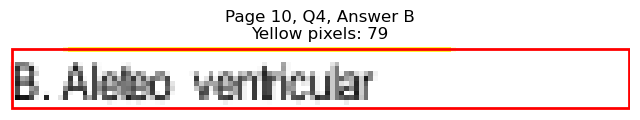

Page 10, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=171.3, y1=314.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 494
Page 10, Q4, C: Yellow percentage: 0.0%


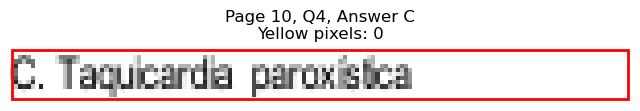

Page 10, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=385.3, y1=289.7
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 288
Page 10, Q4, D: Yellow percentage: 0.0%


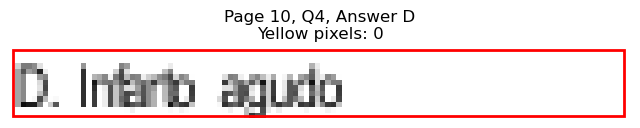

Page 10, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=380.1, y1=301.8
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 464
Page 10, Q4, E: Yellow percentage: 0.0%


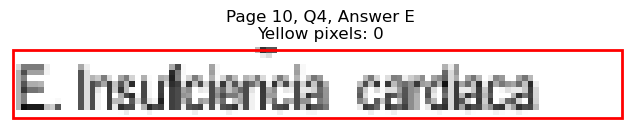


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=338.5, x1=119.5, y1=350.5
Page 10, Q5, A: Yellow pixels: 286
Page 10, Q5, A: Total non-white pixels: 469
Page 10, Q5, A: Yellow percentage: 61.0%


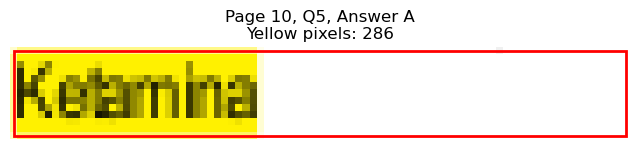

Page 10, Q5 - B: Detected box: x0=71.3, y0=350.5, x1=116.5, y1=362.5
Page 10, Q5, B: Yellow pixels: 34
Page 10, Q5, B: Total non-white pixels: 262
Page 10, Q5, B: Yellow percentage: 13.0%


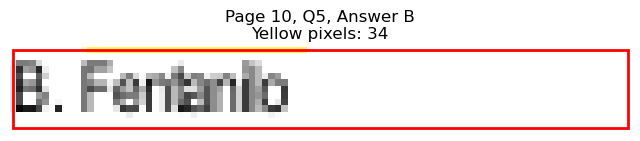

Page 10, Q5 - C: Detected box: x0=71.3, y0=362.5, x1=133.7, y1=374.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 310
Page 10, Q5, C: Yellow percentage: 0.0%


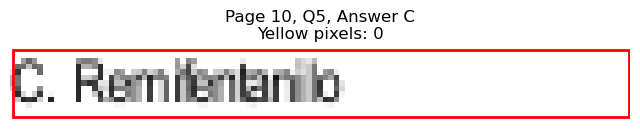

Page 10, Q5 - D: Detected box: x0=322.9, y0=338.5, x1=366.6, y1=350.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 217
Page 10, Q5, D: Yellow percentage: 0.0%


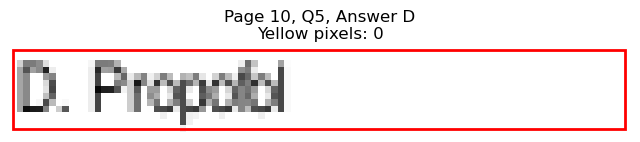

Page 10, Q5 - E: Detected box: x0=322.9, y0=350.5, x1=372.6, y1=362.5
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 257
Page 10, Q5, E: Yellow percentage: 0.0%


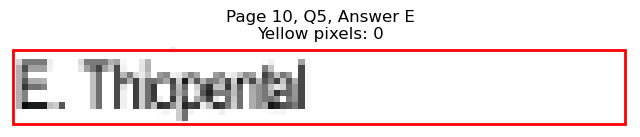


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Paciente adulto mayor sometido a anestesia gen...
1   ¿Cuál es la complicación respiratoria más frec...
2   Paciente con diagnóstico de insuficiencia card...
3   Paciente joven sometido a legrado uterino con ...
4   ¿Cuál es la causa más frecuente de arritmias p...
..                                                ...
95  ¿Cuál es la mejor manera de tratar el dolor po...
96  ¿Cuál es una indicación para el uso de criopre...
97  ¿Cuál de los anestésicos locales tiene inicio ...
98  ¿Cuál es la causa más frecuente de paro cardio...
99  Una anestesia de tipo disociativa está relacio...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                    option_B  \
0   Intoxicación por halogenado  Depresión por barbitúricos   
1                       Hipoxia                Atelectasias   
2                            II                           I   
3                      Propofol                   Midazolam   
4         Disminución de la PIC       Uso del óxido nitroso   
..                          ...                         ...   
95         Analgesia Preventiva                    Sedación   
96                Plaquetopenia                Anemia aguda   
97                   Etidocaina                Clorprocaina   
98      Fibrilación ventricular          Aleteo ventricular   
99                     Ketamina                   Fentanilo   

                                      option_C  \
0        Prolongación del efecto del relajante   
1                                Broncoespasmo   
2                                            0   
3                                    Fentanilo   
4                             Sobrehidratación   
..                                         ...   
95                      Hipnosis farmacológica   
96  Desarrollo de anticuerpos antiplaquetarios   
97                                   Lidocaina   
98                     Taquicardia paroxística   
99                               Remifentanilo   

                             option_D                option_E  
0            Intoxicación por opiáceo      Hipotermia maligna  
1                      Edema pulmonar              Neumotórax  
2                                 III                      IV  
3                       Dexametasona.                Ketamina  
4   Aumento de estimulación simpática           Uso del Xenon  
..                                ...                     ...  
95                Analgesia a demanda         Reposo absoluto  
96       Enfermedad de Von Willebrand     Hiperfibrinogenemia  
97                        Bupivacaina                Procaina  
98                      Infarto agudo  Insuficiencia cardiaca  
99                           Propofol              Thiopental  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Paciente adulto mayor sometido a anestesia gen...   
1   ¿Cuál es la complicación respiratoria más frec...   
2   Paciente con diagnóstico de insuficiencia card...   
3   Paciente joven sometido a legrado uterino con ...   
4   ¿Cuál es la causa más frecuente de arritmias p...   
..                                                ...   
95  ¿Cuál es la mejor manera de tratar el dolor po...   
96  ¿Cuál es una indicación para el uso de criopre...   
97  ¿Cuál de los anestésicos locales tiene inicio ...   
98  ¿Cuál es la causa más frecuente de paro cardio...   
99  Una anestesia de tipo disociativa está relacio...   

                       option_A                    option_B  \
0   Intoxicación por halogenado  Depresión por barbitúricos   
1                       Hipoxia                Atelectasias   
2                            II                           I   
3                      Propofol                   Midazolam   
4         Disminución de la PIC       Uso del óxido nitroso   
..                          ...                         ...   
95         Analgesia Preventiva                    Sedación   
96                Plaquetopenia                Anemia aguda   
97                   Etidocaina                Clorprocaina   
98      Fibrilación ventricular          Aleteo ventricular   
99                     Ketamina                   Fentanilo   

                                      option_C  \
0        Prolongación del efecto del relajante   
1                                Broncoespasmo   
2                                            0   
3                                    Fentanilo   
4                             Sobrehidratación   
..                                         ...   
95                      Hipnosis farmacológica   
96  Desarrollo de anticuerpos antiplaquetarios   
97                                   Lidocaina   
98                     Taquicardia paroxística   
99                               Remifentanilo   

                             option_D                option_E correct_answer  
0            Intoxicación por opiáceo      Hipotermia maligna              C  
1                      Edema pulmonar              Neumotórax              A  
2                                 III                      IV              D  
3                       Dexametasona.                Ketamina              E  
4   Aumento de estimulación simpática           Uso del Xenon              D  
..                                ...                     ...            ...  
95                Analgesia a demanda         Reposo absoluto              A  
96       Enfermedad de Von Willebrand     Hiperfibrinogenemia              D  
97                        Bupivacaina                Procaina              D  
98                      Infarto agudo  Insuficiencia cardiaca              A  
99                           Propofol              Thiopental              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/ANESTESIOLOGIA.csv
